# Predicting NYC Taxi Rides Fares and Total Amounts

## Problem Statement
Taxi passengers often lack visibility into their estimated fare before the ride begins, leading to uncertainty and reduced trust. At the same time, taxi drivers and fleet managers aim to optimize their revenue but may not fully understand how ride characterstics and customer choices— especially payment method — affecting earnings.<br>

This project has two primary goals: 

1. **"Develop a predictive model to estimate the fare amount using trip attributes (distance, location, time of day, etc.), enabling fare transparency and better user experience."** <br>


2. **"Analyze the relationship between payment methods and fare revenue, exploring whether certain payment types lead to higher earnings for drivers and whether behavioral nudges can be applied to influence payment method choice — without harming customer satisfaction."** <br>



## Research Questions
1. **Fare Prediction Focus** <br>
   "Can we accurately predict the fare amount of a yellow taxi ride in NYC based on trip characterstics before the ride begins?"<br>

2. **Revenue Optimization Focus**  <br>
   "Does the payment method (e.g., cash vs. credit card) influence the fare or total amount paid?"<br>

   "Can we recommend a preferred payment method that increases revenue for drivers without negatively impacting customer experience?"<br>

# DATA Loading

In [753]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import Normalize
import joblib
import warnings
warnings.filterwarnings('ignore')

In [208]:
#Loading the dataset
df = pd.read_csv('/Users/harshbajpai/Desktop/Business Intelligence Analyst Job/yellow_tripdata_2020-01.csv')
df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0       1.0  2020-01-01 00:28:15   2020-01-01 00:33:03              1.0   
1       1.0  2020-01-01 00:35:39   2020-01-01 00:43:04              1.0   
2       1.0  2020-01-01 00:47:41   2020-01-01 00:53:52              1.0   
3       1.0  2020-01-01 00:55:23   2020-01-01 01:00:14              1.0   
4       2.0  2020-01-01 00:01:58   2020-01-01 00:04:16              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0            1.2         1.0                  N           238           239   
1            1.2         1.0                  N           239           238   
2            0.6         1.0                  N           238           238   
3            0.8         1.0                  N           238           151   
4            0.0         1.0                  N           193           193   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0           1.0          6.0    3.0      0.5        1.47           0.0   
1           1.0          7.0    3.0      0.5        1.50           0.0   
2           1.0          6.0    3.0      0.5        1.00           0.0   
3           1.0          5.5    0.5      0.5        1.36           0.0   
4           2.0          3.5    0.5      0.5        0.00           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  
0                    0.3         11.27                   2.5  
1                    0.3         12.30                   2.5  
2                    0.3         10.80                   2.5  
3                    0.3          8.16                   0.0  
4                    0.3          4.80                   0.0

# Cleaning, Preprocessing the data and Feature Engineering

In [211]:
# Shape of dataset
df.shape

(6405008, 18)

In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6405008 entries, 0 to 6405007
Data columns (total 18 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               float64
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          float64
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           float64
 10  fare_amount            float64
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             float64
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           float64
 17  congestion_surcharge   float64
dtypes: float64(13), int64(2), object(3)
memory usage: 879.6+ MB


- We're working with around 6.4 million rows here, so it's a large dataset - great for modeling, though we might need to sample it during EDA to keep things manageable.
- A few columns like tpep_pickup_datetime, tpep_dropoff_datetime, and store_and_fwd_flag are currently stored as object types. We'll need to convert these to proper datetime formats.
- At first glance, it doesn't look like any column is entirely made up of null values - but we'll double-check that by identifying columns with missing data.

In [216]:
df.isnull().sum().sort_values(ascending=False)

VendorID                 65441
RatecodeID               65441
store_and_fwd_flag       65441
payment_type             65441
passenger_count          65441
trip_distance                0
tpep_dropoff_datetime        0
PULocationID                 0
DOLocationID                 0
tpep_pickup_datetime         0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge         0
dtype: int64

In [218]:
print('Missing data percentage: ', round(65441/df.shape[0]*100,2), '%')

Missing data percentage:  1.02 %


We found that about $1.02%$ of the data is missing - that's 65,441 rows with missing values in the following columns: 
- VendorID
- RatecodeID
- store_and_fwd_flag
- payment_type
- passenger_count
Since this is just around $1%$ of the entire dataset, we can safely drop these rows from our dataset.

In [221]:
df = df.dropna()

Next, we are going to convert tpep_pickup_datetime and tpep_dropoff_datetime columns into proper datetime format.<br>
This will prepare us for feature engineering -  for example, we can extract details like the pickup hour, day of the week, and more. <br>
It also allows us to calculate useful metrics such as trip duration.

In [224]:
# converting the pickup time and dropoff time into datatime data type
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0       1.0  2020-01-01 00:28:15   2020-01-01 00:33:03              1.0   
1       1.0  2020-01-01 00:35:39   2020-01-01 00:43:04              1.0   
2       1.0  2020-01-01 00:47:41   2020-01-01 00:53:52              1.0   
3       1.0  2020-01-01 00:55:23   2020-01-01 01:00:14              1.0   
4       2.0  2020-01-01 00:01:58   2020-01-01 00:04:16              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0            1.2         1.0                  N           238           239   
1            1.2         1.0                  N           239           238   
2            0.6         1.0                  N           238           238   
3            0.8         1.0                  N           238           151   
4            0.0         1.0                  N           193           193   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0           1.0          6.0    3.0      0.5        1.47           0.0   
1           1.0          7.0    3.0      0.5        1.50           0.0   
2           1.0          6.0    3.0      0.5        1.00           0.0   
3           1.0          5.5    0.5      0.5        1.36           0.0   
4           2.0          3.5    0.5      0.5        0.00           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  
0                    0.3         11.27                   2.5  
1                    0.3         12.30                   2.5  
2                    0.3         10.80                   2.5  
3                    0.3          8.16                   0.0  
4                    0.3          4.80                   0.0

In [225]:
# Checking duplicate values
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


In [228]:
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds()/60
df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0       1.0  2020-01-01 00:28:15   2020-01-01 00:33:03              1.0   
1       1.0  2020-01-01 00:35:39   2020-01-01 00:43:04              1.0   
2       1.0  2020-01-01 00:47:41   2020-01-01 00:53:52              1.0   
3       1.0  2020-01-01 00:55:23   2020-01-01 01:00:14              1.0   
4       2.0  2020-01-01 00:01:58   2020-01-01 00:04:16              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0            1.2         1.0                  N           238           239   
1            1.2         1.0                  N           239           238   
2            0.6         1.0                  N           238           238   
3            0.8         1.0                  N           238           151   
4            0.0         1.0                  N           193           193   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0           1.0          6.0    3.0      0.5        1.47           0.0   
1           1.0          7.0    3.0      0.5        1.50           0.0   
2           1.0          6.0    3.0      0.5        1.00           0.0   
3           1.0          5.5    0.5      0.5        1.36           0.0   
4           2.0          3.5    0.5      0.5        0.00           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  trip_duration  
0                    0.3         11.27                   2.5       4.800000  
1                    0.3         12.30                   2.5       7.416667  
2                    0.3         10.80                   2.5       6.183333  
3                    0.3          8.16                   0.0       4.850000  
4                    0.3          4.80                   0.0       2.300000

In [230]:
df.describe()

VendorID           tpep_pickup_datetime  \
count  6.339567e+06                        6339567   
mean   1.669624e+00  2020-01-17 03:34:30.005863424   
min    1.000000e+00            2003-01-01 00:07:17   
25%    1.000000e+00            2020-01-09 17:41:14   
50%    2.000000e+00            2020-01-17 00:19:20   
75%    2.000000e+00            2020-01-24 18:40:29   
max    2.000000e+00            2021-01-02 01:12:10   
std    4.703484e-01                            NaN   

               tpep_dropoff_datetime  passenger_count  trip_distance  \
count                        6339567     6.339567e+06   6.339567e+06   
mean   2020-01-17 03:50:19.465307904     1.515333e+00   2.848626e+00   
min              2003-01-01 14:16:59     0.000000e+00  -2.218000e+01   
25%              2020-01-09 17:57:08     1.000000e+00   9.600000e-01   
50%              2020-01-17 00:35:33     1.000000e+00   1.600000e+00   
75%              2020-01-24 18:55:51     2.000000e+00   2.900000e+00   
max              2021-01-02 01:25:01     9.000000e+00   2.628800e+02   
std                              NaN     1.151594e+00   3.757127e+00   

         RatecodeID  PULocationID  DOLocationID  payment_type   fare_amount  \
count  6.339567e+06  6.339567e+06  6.339567e+06  6.339567e+06  6.339567e+06   
mean   1.059908e+00  1.650263e+02  1.629923e+02  1.270298e+00  1.249486e+01   
min    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00 -1.238000e+03   
25%    1.000000e+00  1.320000e+02  1.130000e+02  1.000000e+00  6.500000e+00   
50%    1.000000e+00  1.620000e+02  1.620000e+02  1.000000e+00  9.000000e+00   
75%    1.000000e+00  2.340000e+02  2.340000e+02  2.000000e+00  1.350000e+01   
max    9.900000e+01  2.650000e+02  2.650000e+02  5.000000e+00  4.265000e+03   
std    8.118432e-01  6.538737e+01  6.978119e+01  4.739985e-01  1.195665e+01   

              extra       mta_tax    tip_amount  tolls_amount  \
count  6.339567e+06  6.339567e+06  6.339567e+06  6.339567e+06   
mean   1.098011e+00  4.938029e-01  2.211245e+00  3.350126e-01   
min   -2.700000e+01 -5.000000e-01 -9.100000e+01 -3.574000e+01   
25%    0.000000e+00  5.000000e-01  0.000000e+00  0.000000e+00   
50%    5.000000e-01  5.000000e-01  1.950000e+00  0.000000e+00   
75%    2.500000e+00  5.000000e-01  2.860000e+00  0.000000e+00   
max    1.130100e+02  3.080000e+01  1.100000e+03  9.105000e+02   
std    1.251903e+00  6.878918e-02  2.764287e+00  1.745776e+00   

       improvement_surcharge  total_amount  congestion_surcharge  \
count           6.339567e+06  6.339567e+06          6.339567e+06   
mean            2.979684e-01  1.847162e+01          2.299052e+00   
min            -3.000000e-01 -1.242300e+03         -2.500000e+00   
25%             3.000000e-01  1.116000e+01          2.500000e+00   
50%             3.000000e-01  1.416000e+01          2.500000e+00   
75%             3.000000e-01  1.956000e+01          2.500000e+00   
max             3.000000e-01  4.268300e+03          2.750000e+00   
std             3.401817e-02  1.463892e+01          7.017109e-01   

       trip_duration  
count   6.339567e+06  
mean    1.582432e+01  
min    -2.770367e+03  
25%     6.333333e+00  
50%     1.040000e+01  
75%     1.665000e+01  
max     8.525117e+03  
std     6.352311e+01

We can see some negative values in few columns. So lets just filter them out.

In [233]:
df = df[
    (df['trip_distance'] > 0) &
    (df['fare_amount'] > 0) &
    (df['extra'] >= 0) &
    (df['mta_tax'] >= 0) &
    (df['tip_amount'] >= 0) &
    (df['tolls_amount'] >= 0) &
    (df['improvement_surcharge'] >= 0) &
    (df['total_amount'] > 0) &
    (df['congestion_surcharge'] >= 0) &
    (df['trip_duration'] > 0)
]

In [235]:
# Creating time-based features
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_day'] = df['tpep_pickup_datetime'].dt.day
df['pickup_month'] = df['tpep_pickup_datetime'].dt.month
df['pickup_dayofweek'] = df['tpep_pickup_datetime'].dt.dayofweek  #0 = Monday
df['is_weekend'] = df['pickup_dayofweek'].isin([5,6]).astype(int)

In [237]:
df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0       1.0  2020-01-01 00:28:15   2020-01-01 00:33:03              1.0   
1       1.0  2020-01-01 00:35:39   2020-01-01 00:43:04              1.0   
2       1.0  2020-01-01 00:47:41   2020-01-01 00:53:52              1.0   
3       1.0  2020-01-01 00:55:23   2020-01-01 01:00:14              1.0   
5       2.0  2020-01-01 00:09:44   2020-01-01 00:10:37              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           1.20         1.0                  N           238           239   
1           1.20         1.0                  N           239           238   
2           0.60         1.0                  N           238           238   
3           0.80         1.0                  N           238           151   
5           0.03         1.0                  N             7           193   

   payment_type  ...  tolls_amount  improvement_surcharge  total_amount  \
0           1.0  ...           0.0                    0.3         11.27   
1           1.0  ...           0.0                    0.3         12.30   
2           1.0  ...           0.0                    0.3         10.80   
3           1.0  ...           0.0                    0.3          8.16   
5           2.0  ...           0.0                    0.3          3.80   

   congestion_surcharge  trip_duration  pickup_hour  pickup_day  pickup_month  \
0                   2.5       4.800000            0           1             1   
1                   2.5       7.416667            0           1             1   
2                   2.5       6.183333            0           1             1   
3                   0.0       4.850000            0           1             1   
5                   0.0       0.883333            0           1             1   

   pickup_dayofweek  is_weekend  
0                 2           0  
1                 2           0  
2                 2           0  
3                 2           0  
5                 2           0  

[5 rows x 24 columns]

Now, we'll remove the columns tip_amount, tpep_dropoff_datetime, tpep_pickup_datetime, and store_and_fwd_flag, as they could potentially leak information about our target variable, fare_amount.

In [240]:
df = df.drop(['tpep_dropoff_datetime', 'tip_amount', 'tpep_pickup_datetime', 'store_and_fwd_flag'], axis=1, errors='ignore')

In [242]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6253339 entries, 0 to 6339565
Data columns (total 20 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               float64
 1   passenger_count        float64
 2   trip_distance          float64
 3   RatecodeID             float64
 4   PULocationID           int64  
 5   DOLocationID           int64  
 6   payment_type           float64
 7   fare_amount            float64
 8   extra                  float64
 9   mta_tax                float64
 10  tolls_amount           float64
 11  improvement_surcharge  float64
 12  total_amount           float64
 13  congestion_surcharge   float64
 14  trip_duration          float64
 15  pickup_hour            int32  
 16  pickup_day             int32  
 17  pickup_month           int32  
 18  pickup_dayofweek       int32  
 19  is_weekend             int64  
dtypes: float64(13), int32(4), int64(3)
memory usage: 906.5 MB


In [244]:
df.describe()

VendorID  passenger_count  trip_distance    RatecodeID  \
count  6.253339e+06     6.253339e+06   6.253339e+06  6.253339e+06   
mean   1.670960e+00     1.518476e+00   2.881245e+00  1.043521e+00   
std    4.698646e-01     1.154778e+00   3.763539e+00  5.716326e-01   
min    1.000000e+00     0.000000e+00   1.000000e-02  1.000000e+00   
25%    1.000000e+00     1.000000e+00   9.900000e-01  1.000000e+00   
50%    2.000000e+00     1.000000e+00   1.600000e+00  1.000000e+00   
75%    2.000000e+00     2.000000e+00   2.900000e+00  1.000000e+00   
max    2.000000e+00     9.000000e+00   2.628800e+02  9.900000e+01   

       PULocationID  DOLocationID  payment_type   fare_amount         extra  \
count  6.253339e+06  6.253339e+06  6.253339e+06  6.253339e+06  6.253339e+06   
mean   1.651052e+02  1.629317e+02  1.261893e+00  1.240323e+01  1.109039e+00   
std    6.530133e+01  6.968343e+01  4.558752e-01  1.128960e+01  1.250184e+00   
min    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e-02  0.000000e+00   
25%    1.320000e+02  1.130000e+02  1.000000e+00  6.500000e+00  0.000000e+00   
50%    1.620000e+02  1.620000e+02  1.000000e+00  9.000000e+00  5.000000e-01   
75%    2.340000e+02  2.340000e+02  2.000000e+00  1.350000e+01  2.500000e+00   
max    2.650000e+02  2.650000e+02  4.000000e+00  4.265000e+03  1.130100e+02   

            mta_tax  tolls_amount  improvement_surcharge  total_amount  \
count  6.253339e+06  6.253339e+06           6.253339e+06  6.253339e+06   
mean   4.980679e-01  3.317235e-01           2.999412e-01  1.841518e+01   
std    3.111606e-02  1.728730e+00           4.198468e-03  1.397243e+01   
min    0.000000e+00  0.000000e+00           0.000000e+00  3.100000e-01   
25%    5.000000e-01  0.000000e+00           3.000000e-01  1.116000e+01   
50%    5.000000e-01  0.000000e+00           3.000000e-01  1.416000e+01   
75%    5.000000e-01  0.000000e+00           3.000000e-01  1.956000e+01   
max    3.300000e+00  9.105000e+02           3.000000e-01  4.268300e+03   

       congestion_surcharge  trip_duration   pickup_hour    pickup_day  \
count          6.253339e+06   6.253339e+06  6.253339e+06  6.253339e+06   
mean           2.329399e+00   1.588876e+01  1.391954e+01  1.656856e+01   
std            6.303897e-01   6.356860e+01  5.883823e+00  8.830154e+00   
min            0.000000e+00   1.666667e-02  0.000000e+00  1.000000e+00   
25%            2.500000e+00   6.433333e+00  1.000000e+01  9.000000e+00   
50%            2.500000e+00   1.046667e+01  1.500000e+01  1.700000e+01   
75%            2.500000e+00   1.668333e+01  1.900000e+01  2.400000e+01   
max            2.750000e+00   8.525117e+03  2.300000e+01  3.100000e+01   

       pickup_month  pickup_dayofweek    is_weekend  
count  6.253339e+06      6.253339e+06  6.253339e+06  
mean   1.000256e+00      2.991776e+00  2.394725e-01  
std    5.188542e-02      1.850183e+00  4.267616e-01  
min    1.000000e+00      0.000000e+00  0.000000e+00  
25%    1.000000e+00      2.000000e+00  0.000000e+00  
50%    1.000000e+00      3.000000e+00  0.000000e+00  
75%    1.000000e+00      4.000000e+00  0.000000e+00  
max    1.200000e+01      6.000000e+00  1.000000e+00

We noticed a few outliers in some of the dataset's columns. Before removing them, we first validate their presence by plotting boxplots. 

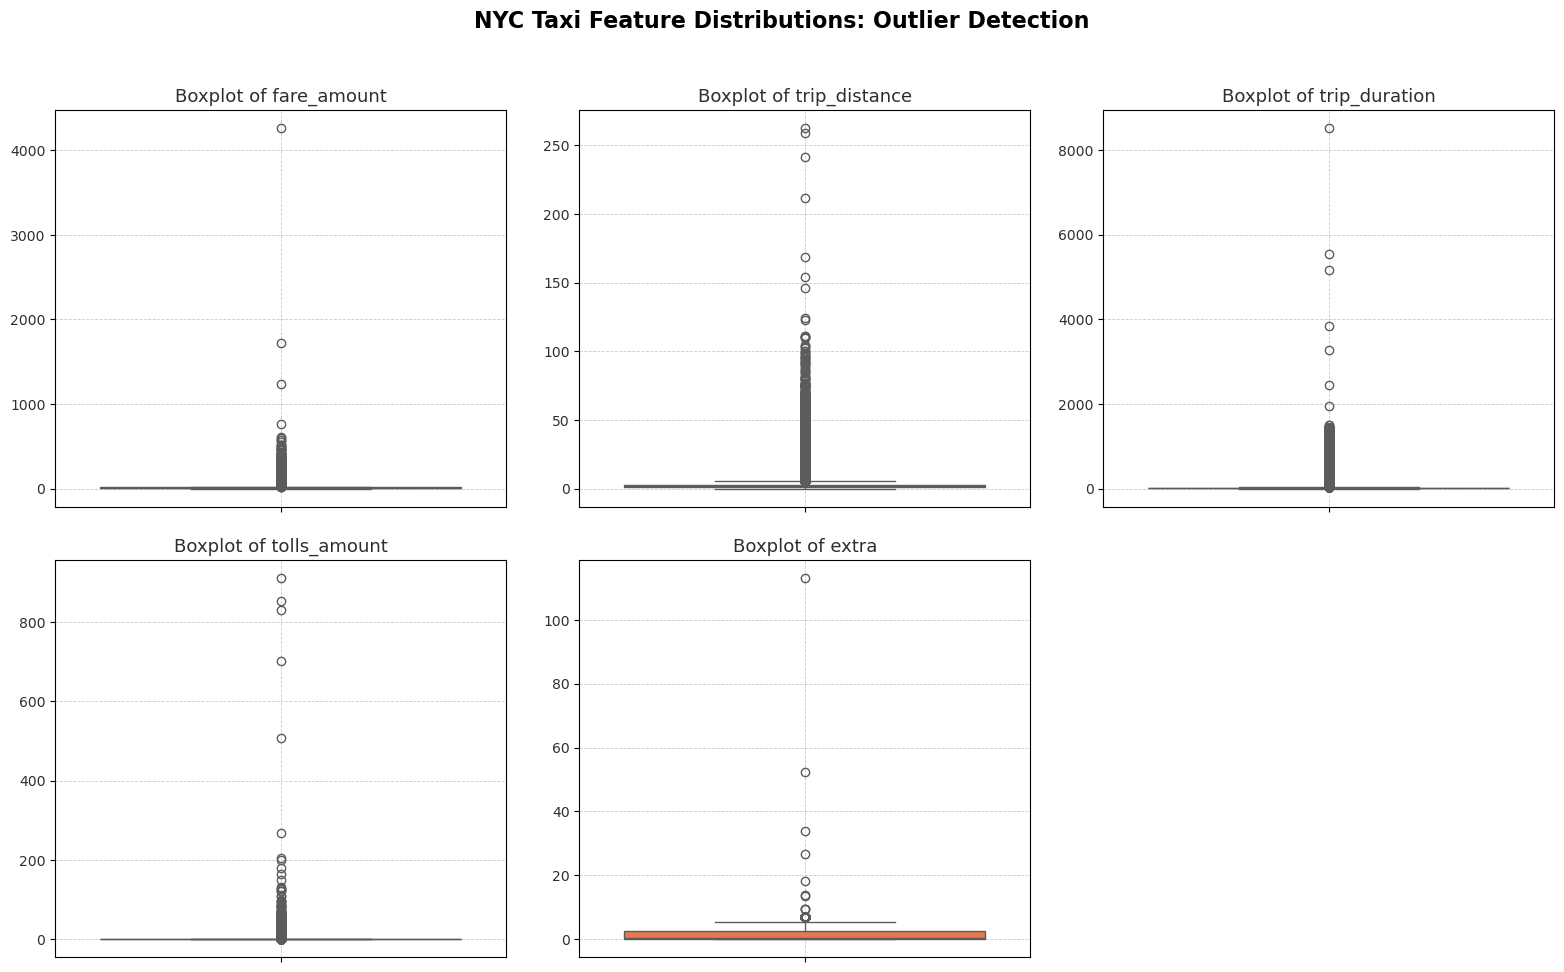

In [247]:
# Defining our NYC Yellow Taxi Theme colors
theme_colors = {
    'primary': '#FFD60A',         # NYC Yellow
    'contrast': '#2E2E2E',        # Asphalt Black
    'accent': '#295E89',          # Hudson Blue
    'highlight': '#FF6B35',       # Rush Hour Orange
    'calm': '#3C9D5B',            # Central Green
    'neutral': '#F8F9FA',         # Pearl White
    'contrast2': '#7D5BA6'        # Sunset Purple (optional contrast)
}

# Columns to check for outliers
columns = ['fare_amount', 'trip_distance', 'trip_duration', 'tolls_amount', 'extra']

plt.figure(figsize=(16, 10))
for i, col in enumerate(columns):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=df, y=col, color=theme_colors['highlight'])  # Rush Hour Orange
    plt.title(f'Boxplot of {col}', fontsize=13, color=theme_colors['contrast'])
    plt.grid(True, linestyle='--', linewidth=0.6, color=theme_colors['accent'], alpha=0.3)
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(color=theme_colors['contrast'])
    plt.yticks(color=theme_colors['contrast'])

plt.suptitle("NYC Taxi Feature Distributions: Outlier Detection", fontsize=16, fontweight='bold')
plt.tight_layout(pad=2.0)
plt.subplots_adjust(top=0.88)
plt.show()


There are definitely some outliers present in our data.

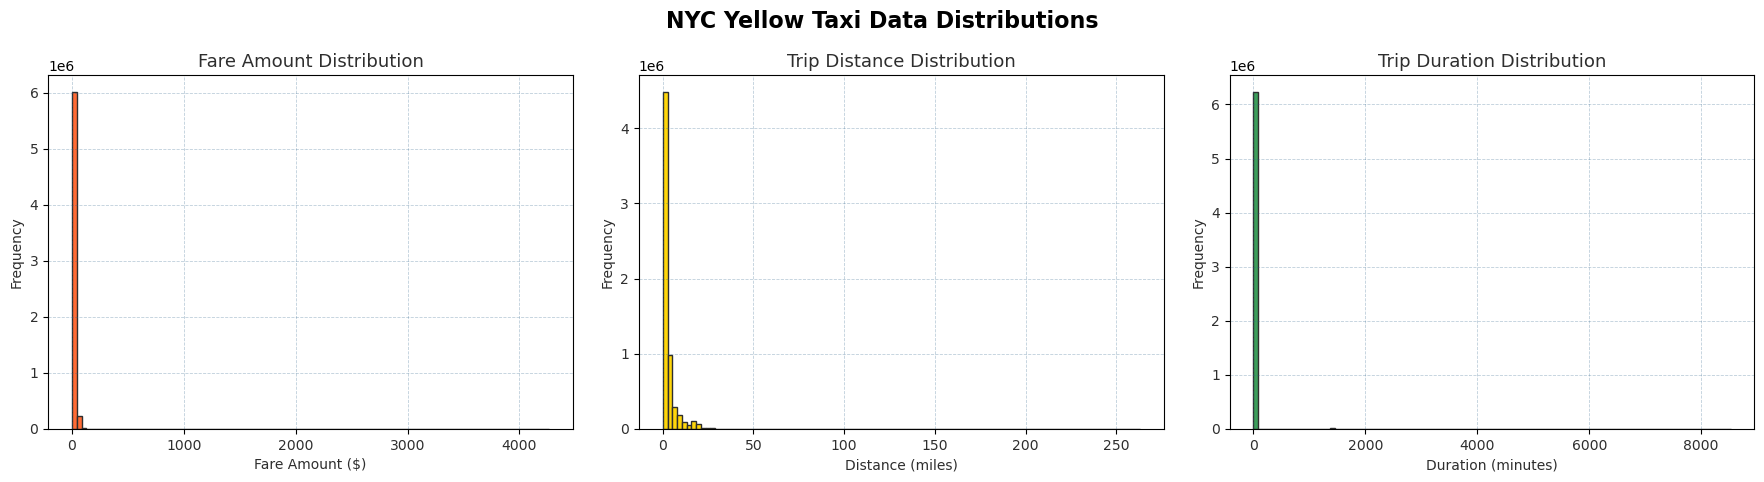

In [250]:
# Styled Histogram Plot
plt.figure(figsize=(18, 5))

# Fare Amount
plt.subplot(1, 3, 1)
plt.hist(df['fare_amount'], bins=100, color=theme_colors['highlight'], edgecolor=theme_colors['contrast'])
plt.title("Fare Amount Distribution", fontsize=13, color=theme_colors['contrast'])
plt.xlabel("Fare Amount ($)", color=theme_colors['contrast'])
plt.ylabel("Frequency", color=theme_colors['contrast'])
plt.grid(True, linestyle='--', linewidth=0.6, color=theme_colors['accent'], alpha=0.3)
plt.xticks(color=theme_colors['contrast'])
plt.yticks(color=theme_colors['contrast'])

# Trip Distance
plt.subplot(1, 3, 2)
plt.hist(df['trip_distance'], bins=100, color=theme_colors['primary'], edgecolor=theme_colors['contrast'])
plt.title("Trip Distance Distribution", fontsize=13, color=theme_colors['contrast'])
plt.xlabel("Distance (miles)", color=theme_colors['contrast'])
plt.ylabel("Frequency", color=theme_colors['contrast'])
plt.grid(True, linestyle='--', linewidth=0.6, color=theme_colors['accent'], alpha=0.3)
plt.xticks(color=theme_colors['contrast'])
plt.yticks(color=theme_colors['contrast'])

# Trip Duration
plt.subplot(1, 3, 3)
plt.hist(df['trip_duration'], bins=100, color=theme_colors['calm'], edgecolor=theme_colors['contrast'])
plt.title("Trip Duration Distribution", fontsize=13, color=theme_colors['contrast'])
plt.xlabel("Duration (minutes)", color=theme_colors['contrast'])
plt.ylabel("Frequency", color=theme_colors['contrast'])
plt.grid(True, linestyle='--', linewidth=0.6, color=theme_colors['accent'], alpha=0.3)
plt.xticks(color=theme_colors['contrast'])
plt.yticks(color=theme_colors['contrast'])

plt.suptitle("NYC Yellow Taxi Data Distributions", fontsize=16,fontweight='bold')
plt.tight_layout(pad=2.0)
plt.subplots_adjust(top=0.85)
plt.show()


Filtering the possible values and removing outliers by setting up limits. 

In [253]:
# Fare should be > $0 and < $150 (assuming rare but valid long trips)
df = df[(df['fare_amount'] > 0) & (df['fare_amount'] < 150)]

# Trip distance should be > 0 and < 50 miles
df = df[(df['trip_distance'] > 0) & (df['trip_distance'] < 50)]

# Trip duration should be > 0 and < 120 minutes
df = df[(df['trip_duration'] > 0) & (df['trip_duration'] < 120)]

# Total amount should be > $0 and < $300
df = df[(df['total_amount'] > 0) & (df['total_amount'] < 300)]


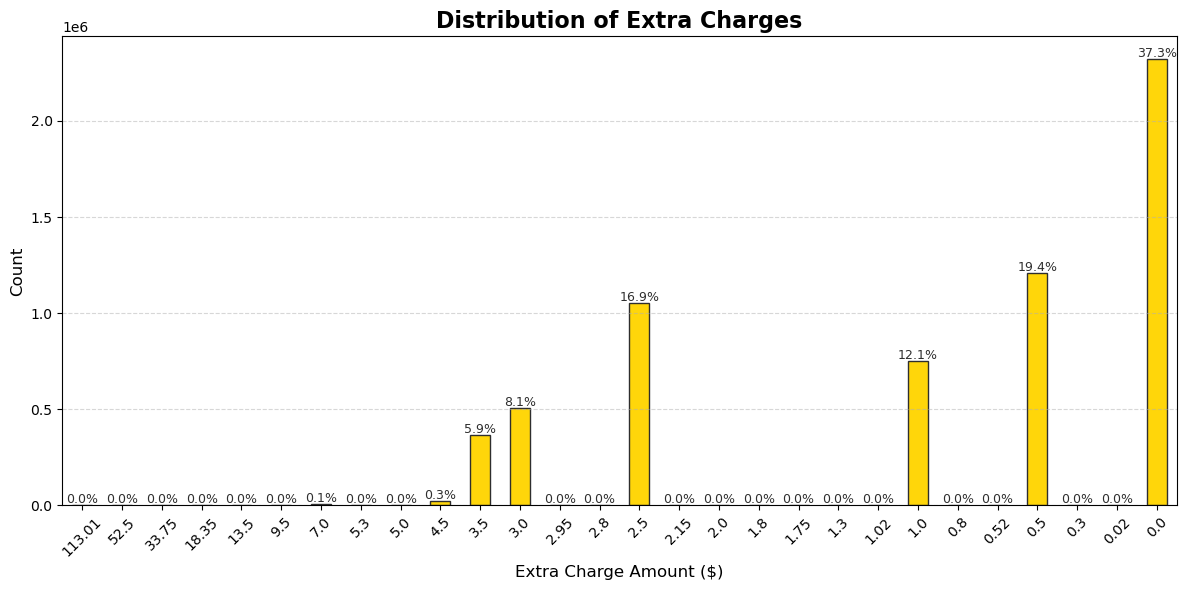

In [254]:
extra_counts = df['extra'].value_counts().sort_index(ascending=False).head(30)
total_count = extra_counts.sum()

plt.figure(figsize=(12,6))
extra_counts.plot(kind='bar', color=theme_colors['primary'], edgecolor=theme_colors['contrast'])

plt.title('Distribution of Extra Charges', fontsize=16, fontweight='bold')
plt.xlabel('Extra Charge Amount ($)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for i, (idx, val) in enumerate(extra_counts.items()):
    percent = (val/total_count) * 100
    plt.text(i, val+10000, f'{percent:.1f}%', ha='center', fontsize=9, color=theme_colors['contrast'])
plt.tight_layout()
plt.show()

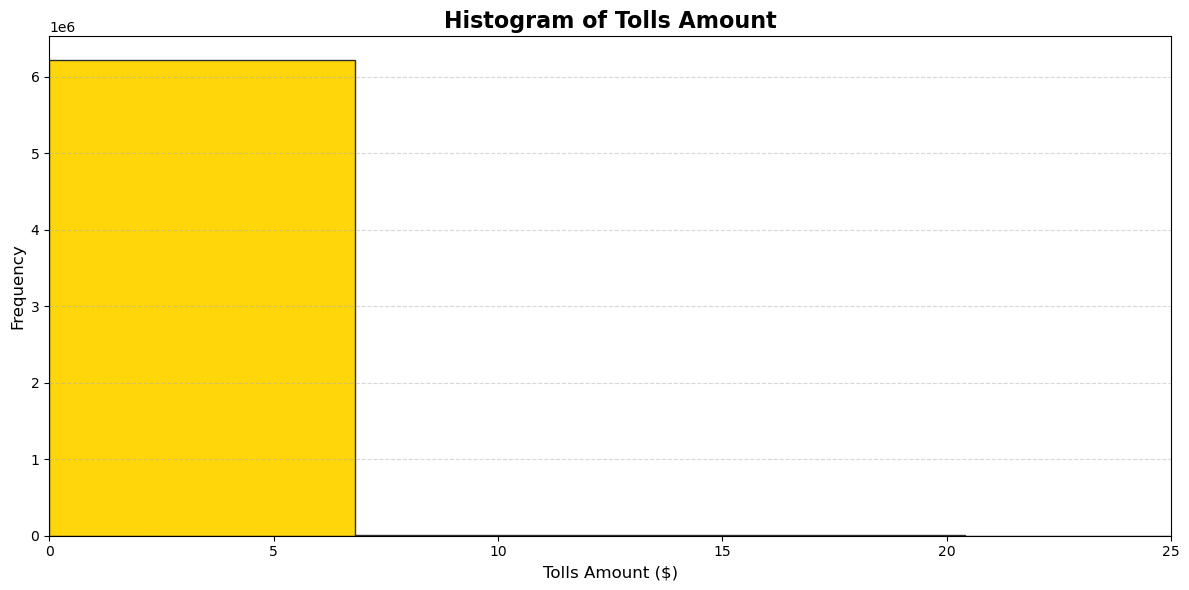

In [257]:
plt.figure(figsize=(12,6))
plt.hist(df['tolls_amount'], bins=30, color=theme_colors['primary'], edgecolor=theme_colors['contrast'])

plt.xlim(0, 25) 
plt.title('Histogram of Tolls Amount', fontsize=16, fontweight='bold')
plt.xlabel('Tolls Amount ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


For the extra charges, values like 113.01, 18.35, and 13.50 are clearly invalid. Typically, we expect values such as 0.5, 1.0, 2.5, 3.0, 3.5 or 5.0. <br>
As for the tolls_amount, most values fall within a reasonable range (around $0 - $25). However, a few extreme values like 180 or 165 seem unrealistic and likely result from input errors.

In [260]:
df = df[df['extra'] <=5]
df = df[df['tolls_amount'] <=30]
df[['extra', 'tolls_amount']].describe()

extra  tolls_amount
count  6.230452e+06  6.230452e+06
mean   1.103747e+00  3.211278e-01
std    1.233671e+00  1.517610e+00
min    0.000000e+00  0.000000e+00
25%    0.000000e+00  0.000000e+00
50%    5.000000e-01  0.000000e+00
75%    2.500000e+00  0.000000e+00
max    5.000000e+00  3.000000e+01

In [262]:
df['passenger_count'].value_counts().sort_index()

passenger_count
0.0     111628
1.0    4463824
2.0     932661
3.0     246887
4.0     121174
5.0     223338
6.0     130908
7.0         17
8.0          7
9.0          8
Name: count, dtype: int64

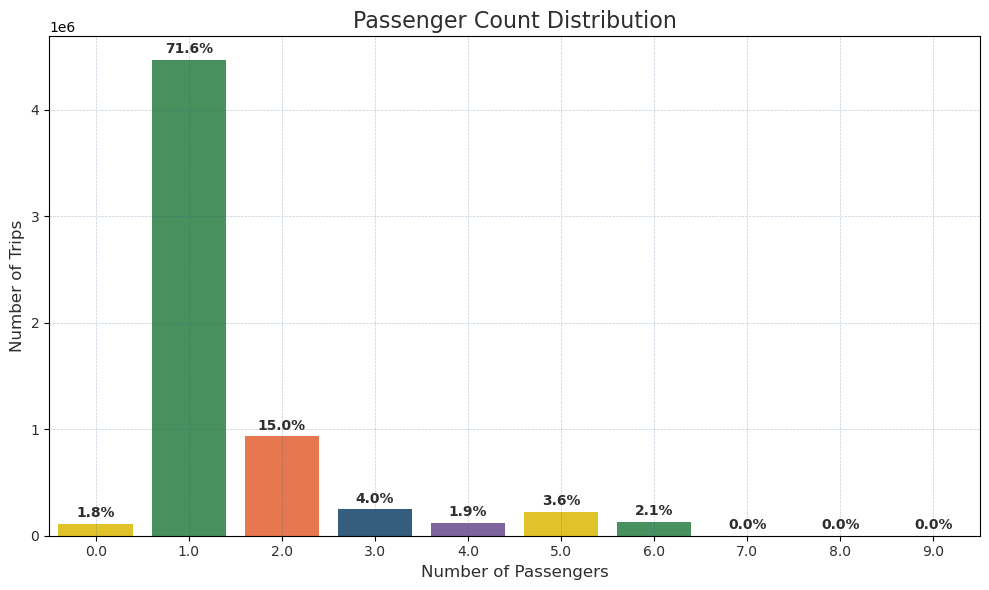

In [270]:
# Calculating counts
counts = df['passenger_count'].value_counts().sort_index()
total = counts.sum()

# Custom color palette for consistency
custom_palette = [
    theme_colors['primary'],
    theme_colors['calm'],
    theme_colors['highlight'],
    theme_colors['accent'],
    theme_colors['contrast2'],
]

plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='passenger_count', palette=custom_palette)

plt.title("Passenger Count Distribution", fontsize=16, color=theme_colors['contrast'])
plt.xlabel("Number of Passengers", fontsize=12, color=theme_colors['contrast'])
plt.ylabel("Number of Trips", fontsize=12, color=theme_colors['contrast'])
plt.xticks(color=theme_colors['contrast'])
plt.yticks(color=theme_colors['contrast'])
plt.grid(True, linestyle='--', linewidth=0.5, color=theme_colors['accent'], alpha=0.3)
plt.tight_layout()

for i, count in enumerate(counts):
    percent = count / total * 100
    ax.text(i, count + 0.01 * total, f"{percent:.1f}%", ha='center', fontsize=10,
            fontweight='bold', color=theme_colors['contrast'])

plt.show()


We remove rides with 0 passengers since they don't contribute meaningful information, and we also exclude rides with a passenger count greater than 6, as they are likely errors or rare edge cases. 

In [273]:
df = df[(df['passenger_count'] >0 ) & (df['passenger_count'] <=6)]

In [274]:
df.shape

(6118792, 20)

# Exploratory Data Analysis

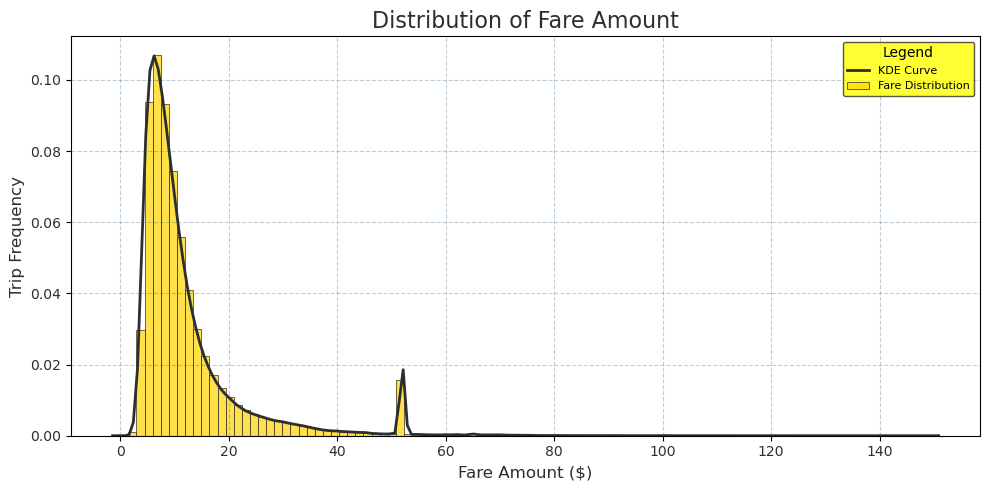

In [384]:
plt.figure(figsize=(10, 5))
sns.histplot(df['fare_amount'], bins=100, color=theme_colors['primary'], edgecolor=theme_colors['contrast'], stat='density', label="Fare Distribution")
sns.kdeplot(df['fare_amount'], color=theme_colors['contrast'], linewidth=2, label='KDE Curve')

plt.title("Distribution of Fare Amount", fontsize=16, color=theme_colors['contrast'])
plt.xlabel("Fare Amount ($)", fontsize=12, color=theme_colors['contrast'])
plt.ylabel("Trip Frequency", fontsize=12, color=theme_colors['contrast'])
plt.xticks(color=theme_colors['contrast'])
plt.yticks(color=theme_colors['contrast'])
plt.grid(True, linestyle='--', alpha=0.3, color=theme_colors['accent'])
plt.legend(title="Legend", title_fontsize=10, fontsize=8, loc='upper right', facecolor='yellow', edgecolor=theme_colors['contrast'],frameon=True)
plt.tight_layout()
plt.show()


**Observations:**
- The fare distribution is right-skewed, which is typical for monetary data like this.
- There's a peak between $\$7$ and $\$12$, likely representing the most common short city trips.
- As secondary spike around $\$50$  probably corresponds to flat-rate airport fares (like trips from JFK).
- The KDE plot (smoothed curve) confirms the skewed shape and highlights a sharp decline after the $20-$25 range.

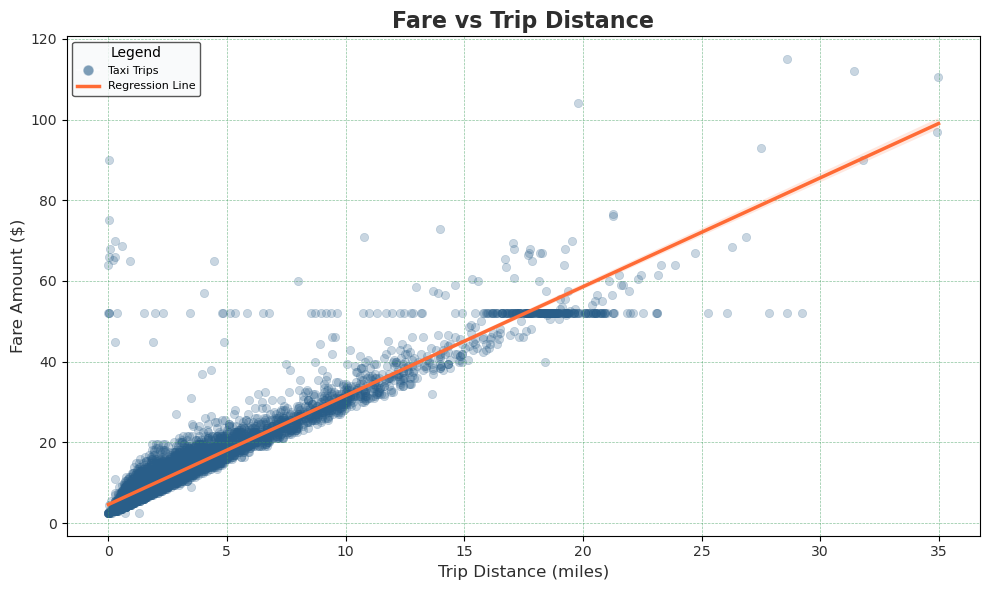

In [445]:
from matplotlib.lines import Line2D

sample_df = df.sample(10000, random_state=42)
plt.figure(figsize=(10, 6))


sns.scatterplot(data=sample_df,x='trip_distance',y='fare_amount',alpha=0.25,color=theme_colors['accent'],edgecolor=None,label='Taxi Trips')

sns.regplot(data=sample_df,x='trip_distance',y='fare_amount',scatter=False,
        line_kws={'color': theme_colors['highlight'],'linewidth': 2.5})

custom_legend = [
    Line2D([0], [0], marker='o', color='w', label='Taxi Trips',
           markerfacecolor=theme_colors['accent'], markersize=8, alpha=0.6),
    Line2D([0], [0], color=theme_colors['highlight'], lw=2.5, label='Regression Line')
]

plt.legend(
    handles=custom_legend,
    title='Legend',
    title_fontsize=10,
    fontsize=8,
    loc='upper left',
    frameon=True,
    facecolor=theme_colors['neutral'],
    edgecolor=theme_colors['contrast']
)

plt.title("Fare vs Trip Distance", fontsize=16, fontweight='bold', color=theme_colors['contrast'])
plt.xlabel("Trip Distance (miles)", fontsize=12, color=theme_colors['contrast'])
plt.ylabel("Fare Amount ($)", fontsize=12, color=theme_colors['contrast'])
plt.xticks(color=theme_colors['contrast'])
plt.yticks(color=theme_colors['contrast'])
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6, color=theme_colors['calm'])
plt.tight_layout()
plt.show()


The fare shows a strong linear relationship with trip distance, with a clear base fare around $\$2$ - $\$3$ and a dense diagonal band indicating consistent per-mile pricing. A distinct horizontal cluster between $\$52$ - $\$55$ likely represents flat-rate airport rides (e.g., JFK rides). These flat fares are clearly visible in the data and are valuable for feature engineering. The regression line fits fits tightly through the main cluster, confirming a predictable, distance-based fare model. Notably, the flat-rate rides appear as a horizontal band above the line, suggesting they're not distance-based - flagging them as a feature could enhance the model.

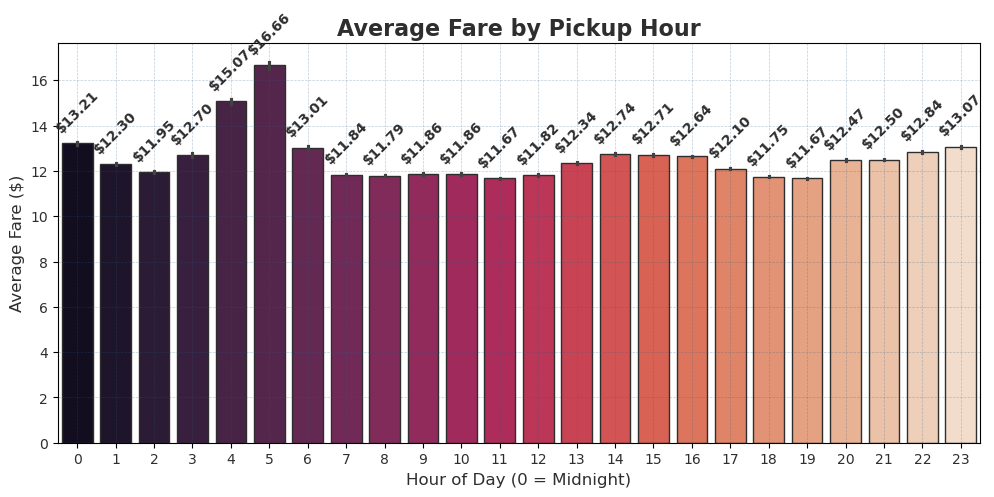

In [288]:
plt.figure(figsize=(10, 5))

# Barplot for average fare
ax = sns.barplot(
    data=df, 
    x='pickup_hour', 
    y='fare_amount', 
    estimator='mean', 
    palette=sns.color_palette("rocket", 24), 
    edgecolor=theme_colors['contrast']
)

# Title and axis styling
plt.title("Average Fare by Pickup Hour", fontsize=16, fontweight='bold', color=theme_colors['contrast'])
plt.xlabel("Hour of Day (0 = Midnight)", fontsize=12, color=theme_colors['contrast'])
plt.ylabel("Average Fare ($)", fontsize=12, color=theme_colors['contrast'])
plt.xticks(rotation=0, color=theme_colors['contrast'])
plt.yticks(color=theme_colors['contrast'])
plt.grid(True, linestyle='--', linewidth=0.5, color=theme_colors['accent'], alpha=0.3)
plt.tight_layout()

for bar in ax.patches:
    height = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2
    y = height
    ax.text(x, y + 0.5, f"${height:.2f}", ha='center', fontsize=10, fontweight='bold', color=theme_colors['contrast'], rotation=45)

plt.show()

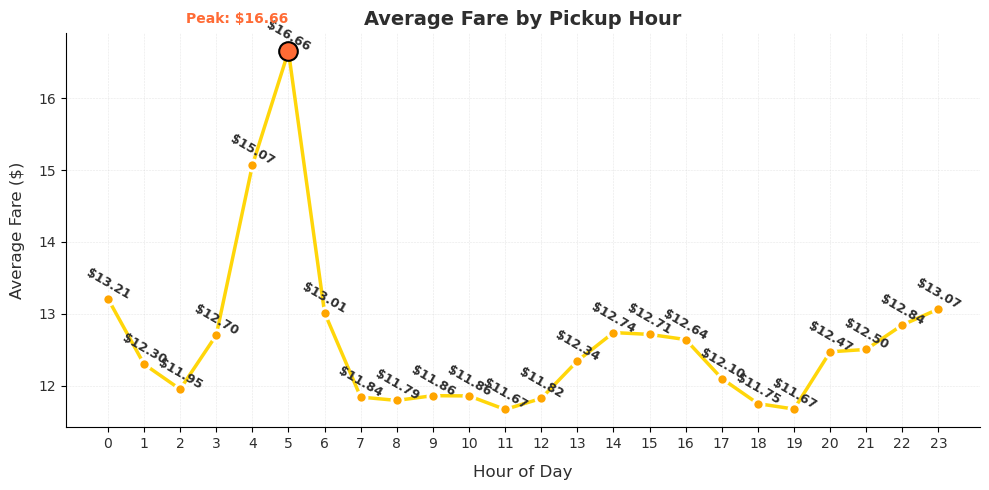

In [331]:
# Group and computing mean fare by hour
fare_by_hour = df.groupby('pickup_hour')['fare_amount'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=fare_by_hour,x='pickup_hour',y='fare_amount',marker='o',color=theme_colors['primary'],linewidth=2.5, markersize=8, markerfacecolor='orange', markeredgewidth=2)
plt.title("Average Fare by Pickup Hour", fontsize=14, fontweight='bold', color=theme_colors['contrast'])
plt.xlabel("Hour of Day", fontsize=12, color=theme_colors['contrast'], labelpad=10)
plt.ylabel("Average Fare ($)", fontsize=12, color=theme_colors['contrast'], labelpad=10)
plt.grid(True, linestyle='--', linewidth=0.4, alpha=0.3)
plt.xticks(ticks=range(0, 24), color=theme_colors['contrast'], fontsize=10)
plt.yticks(color=theme_colors['contrast'], fontsize=10)
plt.tight_layout()

for i, row in fare_by_hour.iterrows():
    plt.text(
        row['pickup_hour'], row['fare_amount'] ,  
        f"${row['fare_amount']:.2f}", 
        ha='center', fontsize=9, 
        fontweight='bold', color=theme_colors['contrast'],
        rotation=330
    )

# Highlight max point
max_idx = fare_by_hour['fare_amount'].idxmax()
max_hour = fare_by_hour.loc[max_idx, 'pickup_hour']
max_fare = fare_by_hour.loc[max_idx, 'fare_amount']

plt.scatter(max_hour, max_fare, s=180, marker='o', color=theme_colors['highlight'], edgecolor='black', zorder=5, linewidth=1.5)
plt.text(max_hour, max_fare + 0.4, f"Peak: ${max_fare:.2f}", ha='right', fontsize=10, color=theme_colors['highlight'], fontweight='bold')


sns.despine()
plt.tight_layout()
plt.show()

Average fares peak early in the morning, especially around 5AM, likely dur to airport drop-offs, surge pricing from low taxi supply, and early long-distance trips. From 7AM to 5PM, fares remain stable (around $\$11$-$\$12$), reflecting short, routine rides like commutes or errands. After 8PM, fares begin to rise again, with a minor peak around 11PM-12AM, possibly driven by nightlife, events, or late long-distance returns.

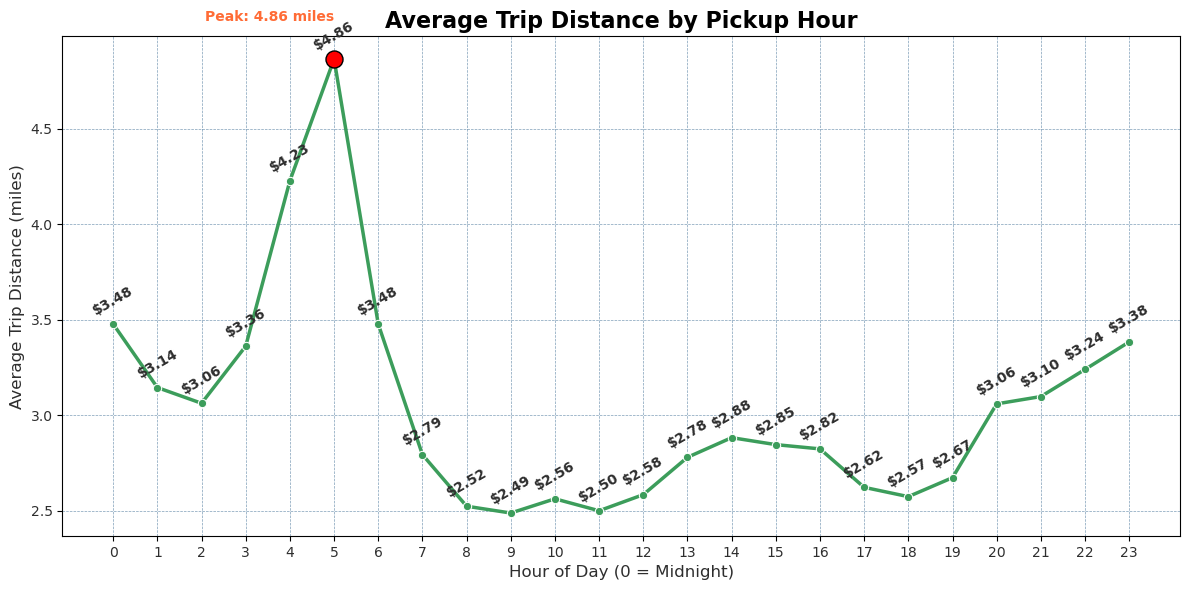

In [471]:
# Group by pickup hour and calculating average trip distance
distance_by_hour = df.groupby('pickup_hour')['trip_distance'].mean().reset_index()


plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=distance_by_hour,x='pickup_hour',y='trip_distance',marker='o',linewidth=2.5,color=theme_colors['calm'])

# Labeling each point with trip distance
for i, row in distance_by_hour.iterrows():
    ax.text(row['pickup_hour'], row['trip_distance'] + 0.05,
            f"${row['trip_distance']:.2f}",
            ha='center', fontsize=10,
            fontweight='bold', color=theme_colors['contrast'], rotation=30)

# Highlight the peak point
max_idx = distance_by_hour['trip_distance'].idxmax()
max_row = distance_by_hour.loc[max_idx]

plt.scatter(max_row['pickup_hour'], max_row['trip_distance'],s=150, color='red', edgecolors='black', zorder=5)

plt.text(max_row['pickup_hour'], max_row['trip_distance'] + 0.2,
         f"Peak: {max_row['trip_distance']:.2f} miles",
         color=theme_colors['highlight'],
         fontsize=10, fontweight='bold', ha='right')

plt.title("Average Trip Distance by Pickup Hour", fontsize=16, fontweight='bold')
plt.xlabel("Hour of Day (0 = Midnight)", fontsize=12, color=theme_colors['contrast'])
plt.ylabel("Average Trip Distance (miles)", fontsize=12, color=theme_colors['contrast'])
plt.xticks(range(0, 24), color=theme_colors['contrast'])
plt.yticks(color=theme_colors['contrast'])
plt.grid(True, linestyle='--', linewidth=0.5, color=theme_colors['accent'], alpha=0.6)
plt.tight_layout()
plt.show()


At 5AM, the average trip distance peaks at around 4.9 miles, likely due to airport drop-offs, long commutes, or early inter-borough travel - which aligns with the earlier spike in fare at this time. After 6AM, trip distances drop significantly, shifting toward shorter, local rides like work commutes, and remain stable throughout the day (around 2.5-3 miles). A slight increase in distance is observed again between 8 PM and midnight, possibly driven by nighlife, work returns, or late evening plans.

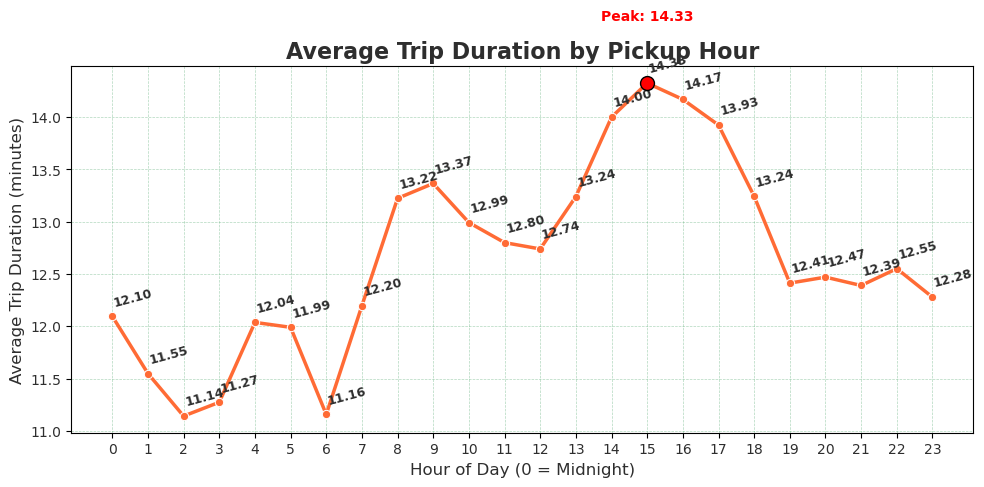

In [401]:
# Grouping data
duration_by_hour = df.groupby('pickup_hour')['trip_duration'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=duration_by_hour,x='pickup_hour',y='trip_duration',marker='o',
    color=theme_colors['highlight'],  linewidth=2.5)

for x, y in zip(duration_by_hour['pickup_hour'], duration_by_hour['trip_duration']):
    plt.text(x, y + 0.1, f"{y:.2f}", ha='left', fontsize=9, fontweight='bold', color=theme_colors['contrast'], rotation=15)

peak_idx = duration_by_hour['trip_duration'].idxmax()
peak_hour = duration_by_hour.loc[peak_idx, 'pickup_hour']
peak_value = duration_by_hour.loc[peak_idx, 'trip_duration']

plt.scatter(peak_hour, peak_value, s=100, color='red', edgecolor='black', zorder=5)
plt.text(peak_hour, peak_value + 0.6, f"Peak: {peak_value:.2f}", fontsize=10, color='red', fontweight='bold', ha='center')

plt.title("Average Trip Duration by Pickup Hour", fontsize=16, fontweight='bold', color=theme_colors['contrast'])
plt.xlabel("Hour of Day (0 = Midnight)", fontsize=12, color=theme_colors['contrast'])
plt.ylabel("Average Trip Duration (minutes)", fontsize=12, color=theme_colors['contrast'])
plt.xticks(range(0, 24), color=theme_colors['contrast'])
plt.yticks(color=theme_colors['contrast'])
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.4, color=theme_colors['calm'])
plt.tight_layout()
plt.show()


Trip durations peak between 2PM and 5PM, likely due to traffic congestion and school/work dismissals - though these aren't the longest trips by distance, they involve more time on the road. In contrast, early morning trips around 6AM tend to be long-distance but shorter in duration, likely due to low traffic and quick airport rides. During the late evening (8PM-midnight), durations flatten out, reflecting moderate, predictable trips with less traffic. Overall, early morning rides (5-6AM) show high fares and long distances but shorter durations, while afternoon trips are slower despite covering moderate distances - pointing to congestion as a major factor.

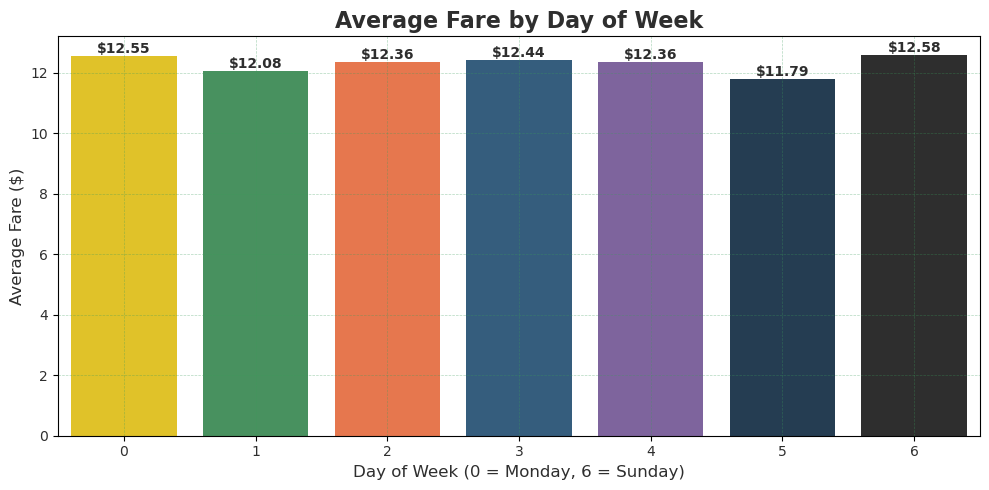

In [418]:
# Grouping data
fare_by_day = df.groupby('pickup_dayofweek')['fare_amount'].mean().reset_index()

plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=fare_by_day,
    x='pickup_dayofweek',
    y='fare_amount',
    palette=sns.color_palette([theme_colors['primary'], theme_colors['calm'], theme_colors['highlight'],
                               theme_colors['accent'], theme_colors['contrast2'], '#1E3D59',
                               theme_colors['contrast']])
)


for i, val in enumerate(fare_by_day['fare_amount']):
    ax.text(i, val + 0.1, f"${val:.2f}", ha='center', fontsize=10, fontweight='bold', color=theme_colors['contrast'])

plt.title("Average Fare by Day of Week", fontsize=16, fontweight='bold', color=theme_colors['contrast'])
plt.xlabel("Day of Week (0 = Monday, 6 = Sunday)", fontsize=12, color=theme_colors['contrast'])
plt.ylabel("Average Fare ($)", fontsize=12, color=theme_colors['contrast'])

plt.xticks(color=theme_colors['contrast'])
plt.yticks(color=theme_colors['contrast'])
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.4, color=theme_colors['calm'])

plt.tight_layout()
plt.show()


The average fare remains fairly consistent across all days of the week, with only minor fluctuations. Sunday (Day6) shows the highest average fare at $\$12.58$, while Saturday (Day 5) has the lowest at $\$11.79$. Overall, this suggests that day-of-week has minimal impact on fare amounts.

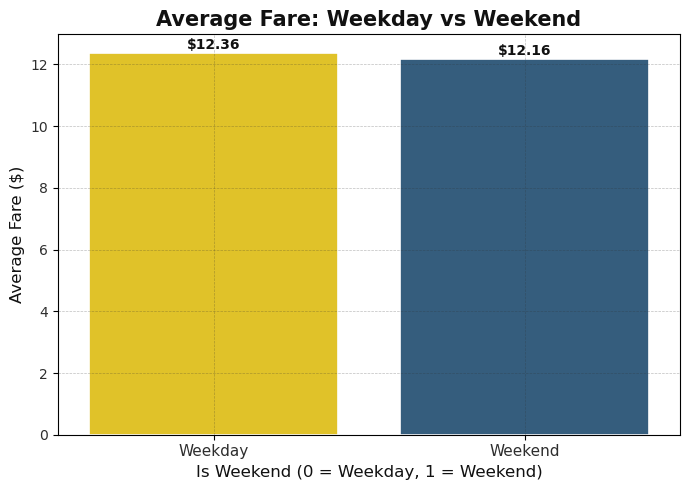

In [421]:
# Custom bar colors for weekday and weekend
custom_palette = ['#FFD60A', '#295E89']  

fare_by_weekend = df.groupby('is_weekend')['fare_amount'].mean().reset_index()


plt.figure(figsize=(7, 5))
ax = sns.barplot(data=fare_by_weekend,x='is_weekend',y='fare_amount',palette=custom_palette,edgecolor='white',linewidth=1.2)

plt.xticks([0, 1], ['Weekday', 'Weekend'], fontsize=11, color='#2E2E2E')
plt.yticks(color='#2E2E2E')

for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.15,
        f"${height:.2f}",
        ha='center',
        fontsize=10,
        fontweight='bold',
        color='#111111'
    )

plt.title("Average Fare: Weekday vs Weekend", fontsize=15, fontweight='bold', color='#111111')
plt.xlabel("Is Weekend (0 = Weekday, 1 = Weekend)", fontsize=12, color='#111111')
plt.ylabel("Average Fare ($)", fontsize=12, color='#111111')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.3, color='#2E2E2E')
plt.tight_layout()
plt.show()


The average fare is slightly higher on weekdays ($\$12.36$) compared to weekends ($\$12.16). However, the difference is minimal, suggesting that fare amounts are fairly consistent regardless of whether the trip occurs on a weekday or weekend. Even though the visual difference is small, running a t-test will let us quantify whether the difference in means is statistically sifnificant.

In [425]:
from scipy.stats import ttest_ind

# Split fares by group
fare_weekday = df[df['is_weekend'] == 0]['fare_amount']
fare_weekend = df[df['is_weekend'] == 1]['fare_amount']

# Perform independent t-test
t_stat, p_value = ttest_ind(fare_weekday, fare_weekend, equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.6f}")


T-statistic: 19.2897
P-value: 0.000000


Although the difference in average fare between weekdays and weekends is statistically significant (p<0.000001), the actual dollar difference is minimal (less than $\$1$). This means the result is statistically significant but not practically significant. So, unless we're specifically testing its impact, it's reasonable to drop the is_weekend variable from our model. 

In [428]:
# Means
mean_weekday = fare_weekday.mean()
mean_weekend = fare_weekend.mean()

# Standard deviations
std_weekday = fare_weekday.std()
std_weekend = fare_weekend.std()

# Sample sizes
n_weekday = len(fare_weekday)
n_weekend = len(fare_weekend)

# Pooled standard deviation
pooled_std = np.sqrt(((n_weekday - 1) * std_weekday**2 + (n_weekend - 1) * std_weekend**2) / (n_weekday + n_weekend - 2))

# Cohen's d
cohen_d = (mean_weekday - mean_weekend) / pooled_std

print(f"Cohen's d: {cohen_d:.4f}")

Cohen's d: 0.0184


While the t-test shows a statistically significant difference in average fares between weekdays and weekends (p<0.000001), the effect size is extremely small (Cohen's d=0.0183). This means the difference is negligible in practical terms and unlikely to have any real-world impact - making it operationally insignificant despite statistical significance.

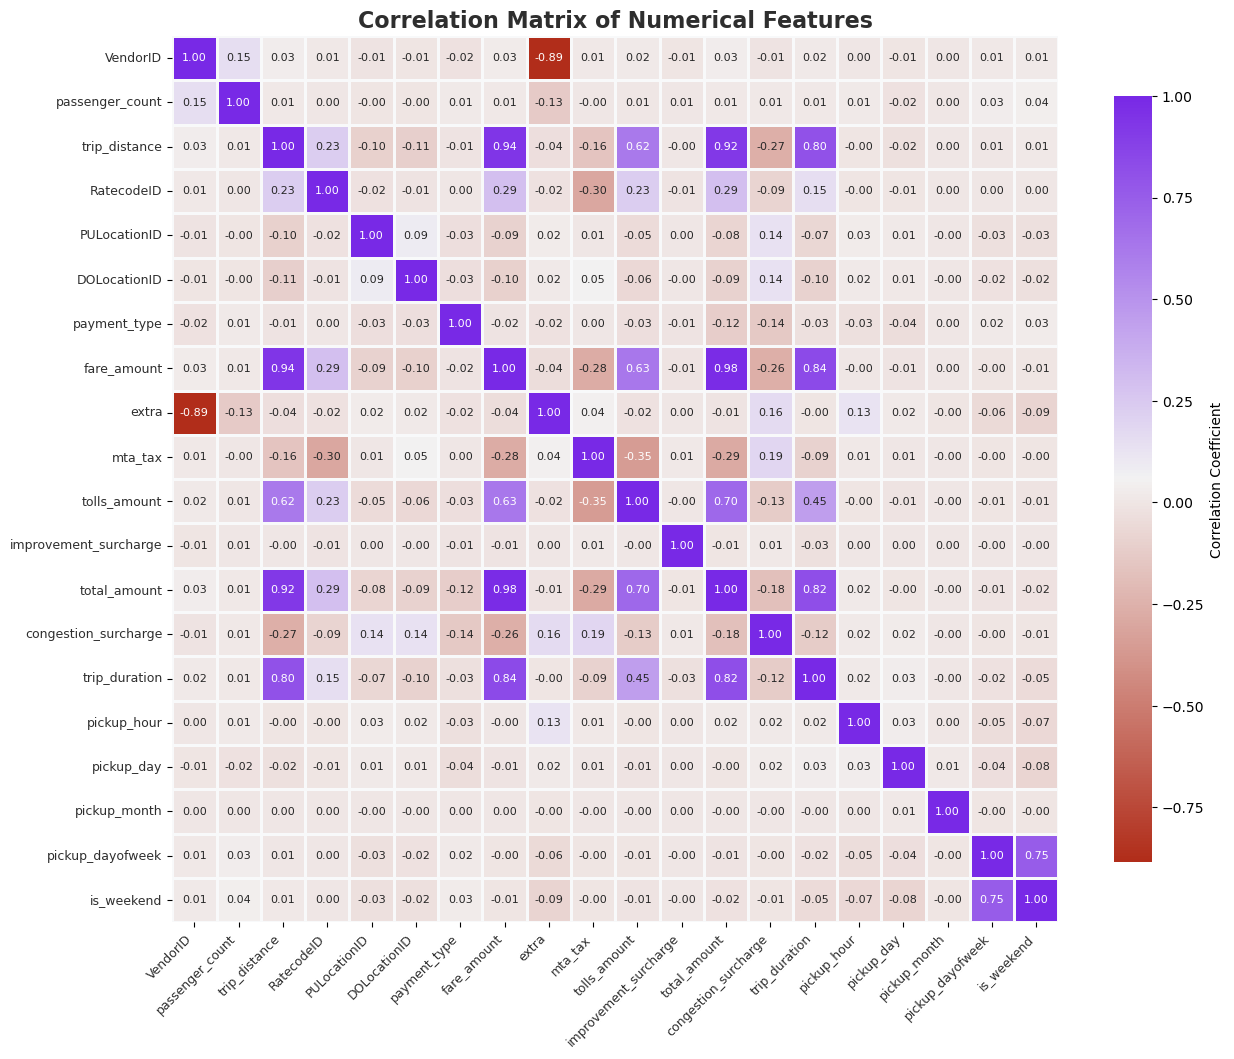

In [433]:
# Taxi Heat Palette: warm to cool gradient from Rush Hour to Hudson
taxi_cmap = sns.diverging_palette(15, 275, s=90, l=40, as_cmap=True)

# Calculating correlation matrix
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(13, 11))
sns.heatmap(corr_matrix,annot=True,fmt=".2f",cmap=taxi_cmap,square=True,linewidths=0.8,linecolor='#F8F9FA',  
    cbar_kws={'shrink': 0.8, 'label': 'Correlation Coefficient'},annot_kws={"fontsize": 8})

plt.title("Correlation Matrix of Numerical Features", fontsize=16, fontweight='bold', color='#2E2E2E')
plt.xticks(rotation=45, ha='right', fontsize=9, color='#2E2E2E')
plt.yticks(fontsize=9, color='#2E2E2E')
plt.tight_layout()
plt.show()


- **Top predictors of fare:**

   - trip_distance has the strongest correlation with fare — the longer the ride, the higher the fare.

   - trip_duration also shows a strong link — more time on the road generally means a higher fare.

   - extra includes surcharges (like night or peak hours), which naturally push fares up.

- **Moderate contributors:**

   - Features like congestion_surcharge, mta_tax, and improvement_surcharge are weakly but positively correlated — they still add to the fare.

- **Watch out for multicollinearity:**

   - trip_distance and trip_duration are highly correlated, so one might be redundant — we can let the model decide.

   - fare_amount and extra are strongly linked, but that’s okay since we’ve already removed any leaking features.

   - pickup_month and pickup_dayofweek show some correlation, but it’s not a major concern.

- **Weak or no correlation:**

   - Features like VendorID, pickup_day, pickup_hour, pickup_month, and is_weekend don’t relate much to fare. We can keep them for now but may drop them later if they don’t add value.



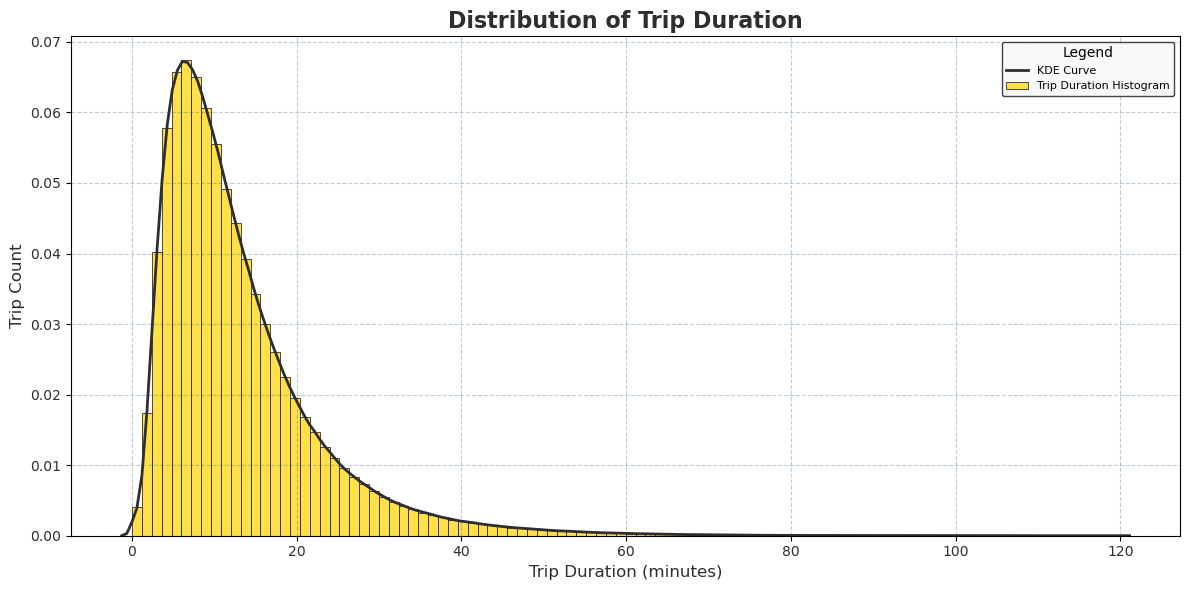

In [455]:
plt.figure(figsize=(12, 6))

sns.histplot(df['trip_duration'],bins=100,color=theme_colors['primary'],edgecolor=theme_colors['contrast'],stat='density',
    label='Trip Duration Histogram')

sns.kdeplot(df['trip_duration'],color=theme_colors['contrast'],linewidth=2,label='KDE Curve')

plt.title("Distribution of Trip Duration", fontsize=16, fontweight='bold', color=theme_colors['contrast'])
plt.xlabel("Trip Duration (minutes)", fontsize=12, color=theme_colors['contrast'])
plt.ylabel("Trip Count", fontsize=12, color=theme_colors['contrast'])
plt.xticks(color=theme_colors['contrast'])
plt.yticks(color=theme_colors['contrast'])
plt.grid(True, linestyle='--', alpha=0.3, color=theme_colors['accent'])

plt.legend(title='Legend',title_fontsize=10,fontsize=8,loc='upper right',frameon=True,framealpha=0.9,
    facecolor=theme_colors['neutral'],edgecolor=theme_colors['contrast'])

plt.tight_layout()
plt.show()


The distribution of trip duration is clerly righ-skewed, which is typical for time-based varaibles. Most rides are short, usually between 5 to 15 minutes, with a noticeable peak around 6 to 8 minutes - reflecting quick intra-city trips. There's a long tail exteding up to 120 minutes, which aligns with the cap we applied during filtering. The KDE curve supports this too - it shows a smooth, natural decline without any sudden spikes, indicating that no further cleaning is necessary. Overall, the trip duration data is well-shaped for modeling and accurately reflects urban ride patterns. 

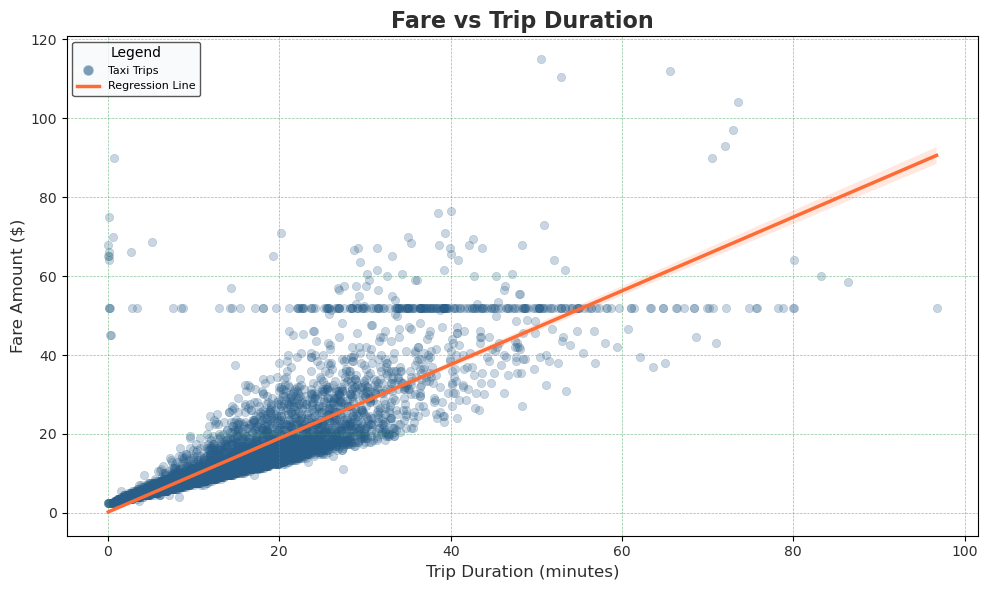

In [468]:
sample_df = df.sample(10000, random_state=42)

plt.figure(figsize=(10, 6))

sns.scatterplot(data=sample_df,x='trip_duration',y='fare_amount',alpha=0.25,color=theme_colors['accent'],
    edgecolor=None,label='Taxi Trips')

sns.regplot(data=sample_df,x='trip_duration',y='fare_amount',scatter=False,
    line_kws={'color': theme_colors['highlight'],'linewidth': 2.5})

custom_legend = [
    Line2D([0], [0], marker='o', color='w', label='Taxi Trips',
           markerfacecolor=theme_colors['accent'], markersize=8, alpha=0.6),
    Line2D([0], [0], color=theme_colors['highlight'], lw=2.5, label='Regression Line')
]

plt.legend(handles=custom_legend,title='Legend',title_fontsize=10,fontsize=8,loc='upper left',
    frameon=True,facecolor=theme_colors['neutral'],edgecolor=theme_colors['contrast'])

plt.title("Fare vs Trip Duration", fontsize=16, fontweight='bold', color=theme_colors['contrast'])
plt.xlabel("Trip Duration (minutes)", fontsize=12, color=theme_colors['contrast'])
plt.ylabel("Fare Amount ($)", fontsize=12, color=theme_colors['contrast'])
plt.xticks(color=theme_colors['contrast'])
plt.yticks(color=theme_colors['contrast'])

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6, color=theme_colors['calm'])
plt.tight_layout()
plt.show()

Trip duration shows a positive but weaker correlation with fare compared to trip distance. Fares generally increase with duration, but the relationship is more scattered - likely due to traffic, routes, or flat-rate zones. A horizontal cluster around $\$52$-$\$55$ confirms the presence of fixed airport fares (e.g., JFK), where fare stays constant despite trip length. For trips over 20 minutes, fare variability increases, possibly due to slow short-distance rides or fast long-distance ones. In contrast, trips under 15-20 minutes show a steady fare increase, reflecting base fare plus time-based pricing. 

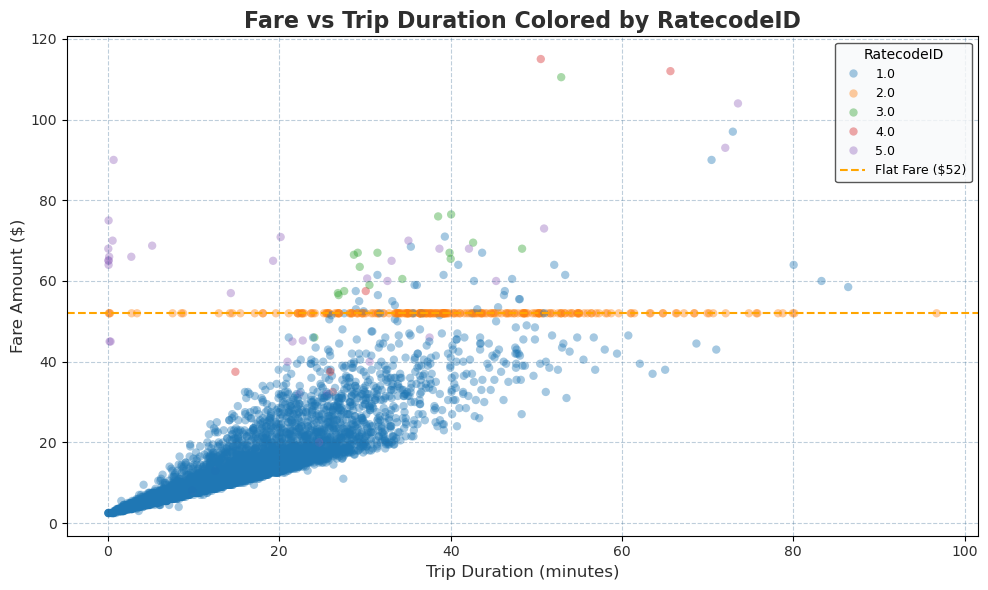

In [478]:
plt.figure(figsize=(10, 6))

sns.scatterplot(data=sample_df,x='trip_duration',y='fare_amount',hue='RatecodeID',palette='tab10',alpha=0.4,edgecolor='none')

plt.title("Fare vs Trip Duration Colored by RatecodeID", fontsize=16, fontweight='bold', color=theme_colors['contrast'])
plt.xlabel("Trip Duration (minutes)", fontsize=12, color=theme_colors['contrast'])
plt.ylabel("Fare Amount ($)", fontsize=12, color=theme_colors['contrast'])
plt.xticks(color=theme_colors['contrast'])
plt.yticks(color=theme_colors['contrast'])

plt.grid(True, linestyle='--', alpha=0.3, color=theme_colors['accent'])
plt.axhline(52, color='orange', linestyle='--', linewidth=1.5, label='Flat Fare ($52)')


plt.legend(title='RatecodeID',title_fontsize=10,fontsize=9,loc='upper right',frameon=True,
    facecolor=theme_colors['neutral'],edgecolor=theme_colors['contrast'])

plt.tight_layout()
plt.show()


RatecodeID 2 clearly shows a flat-fare pattern around $\$52$-$\$55$, strongly suggesting it's tied to airport flat fares. Other RatecodeIDs follow a more typical fare distribution, while RatecodeID 5 appears more often in high-fare, long trips - possibly negotiated or unknown rates. This makes RatecodeID a useful feature for identifying and handling flat fares separately in modeling, even if its overall correlation with fare is low. It reflects conditional fare logic and can still add valuable context.

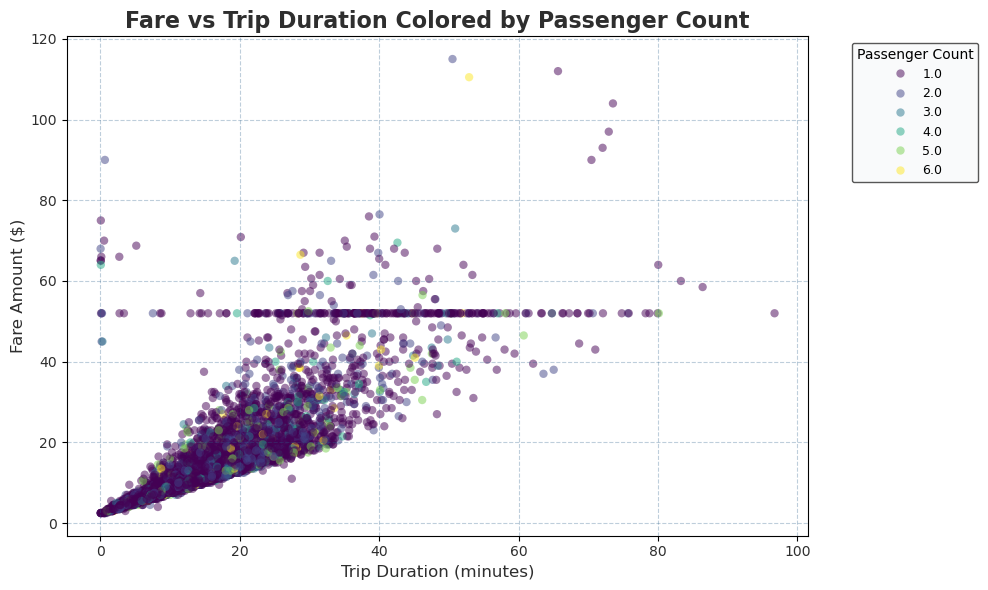

In [480]:
plt.figure(figsize=(10, 6))

sns.scatterplot(data=sample_df,x='trip_duration',y='fare_amount',hue='passenger_count',palette='viridis',alpha=0.5,edgecolor='none')


plt.title("Fare vs Trip Duration Colored by Passenger Count", fontsize=16, fontweight='bold', color=theme_colors['contrast'])
plt.xlabel("Trip Duration (minutes)", fontsize=12, color=theme_colors['contrast'])
plt.ylabel("Fare Amount ($)", fontsize=12, color=theme_colors['contrast'])

plt.xticks(color=theme_colors['contrast'])
plt.yticks(color=theme_colors['contrast'])
plt.grid(True, linestyle='--', alpha=0.3, color=theme_colors['accent'])


plt.legend(title='Passenger Count',title_fontsize=10,fontsize=9,bbox_to_anchor=(1.05, 1),loc='upper left',frameon=True,
    facecolor=theme_colors['neutral'],edgecolor=theme_colors['contrast'])

plt.tight_layout()
plt.show()


Most rides have 1-2 passengers, which makes sense for city travel. There's no major fare increase with more passengers, suggesting fares are typically shared, not charged per person. A slight spread is visible for higher passenger counts on longer trips. Overall, passenger count has minimal impact on fare, as confirmed by the correlation matrix. While it's not critical for fare prediction, it could still be helpful for identifying travel patterns or clustering behaviors.

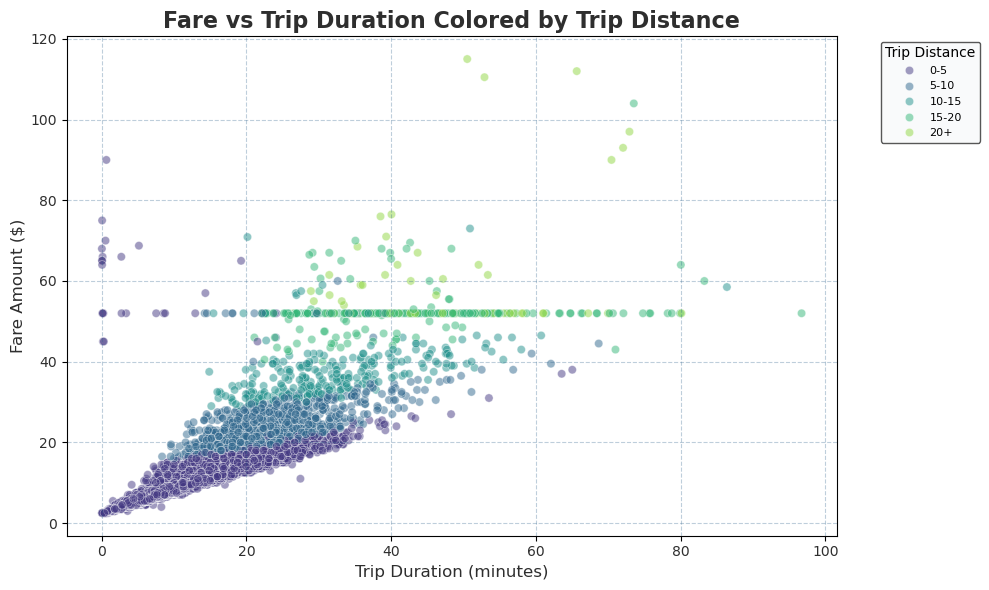

In [485]:
plt.figure(figsize=(10,6))
sample_df['trip_distance_bin'] = pd.cut(sample_df['trip_distance'], bins=[0, 5, 10, 15, 20, 100], labels=['0-5', '5-10', '10-15', '15-20', '20+'])

sns.scatterplot(data=sample_df,x='trip_duration',y='fare_amount', hue='trip_distance_bin',palette='viridis',alpha=0.5)

plt.title("Fare vs Trip Duration Colored by Trip Distance", fontsize=16, fontweight='bold', color=theme_colors['contrast'])
plt.xlabel("Trip Duration (minutes)", fontsize=12, color=theme_colors['contrast'])
plt.ylabel("Fare Amount ($)", fontsize=12, color=theme_colors['contrast'])

plt.xticks(color=theme_colors['contrast'])
plt.yticks(color=theme_colors['contrast'])
plt.grid(True, linestyle='--', alpha=0.3, color=theme_colors['accent'])


plt.legend(title='Trip Distance',title_fontsize=10,fontsize=8,bbox_to_anchor=(1.05, 1),loc='upper left',frameon=True,
    facecolor=theme_colors['neutral'],edgecolor=theme_colors['contrast'])

plt.tight_layout()
plt.show()


The visual clearly reinforces the relationship: longer trips (shown in ligher colors) tend to have higher fares and longer durations, while some short-duration but high-fare rides (darker colors) are likely flat-rate rides or affected by traffic delays. Overall, fare aligns more closely with distance than with duration. This confirms that trip_distance is a stronger predictor than trip_duration, and should be priortized when building models. 

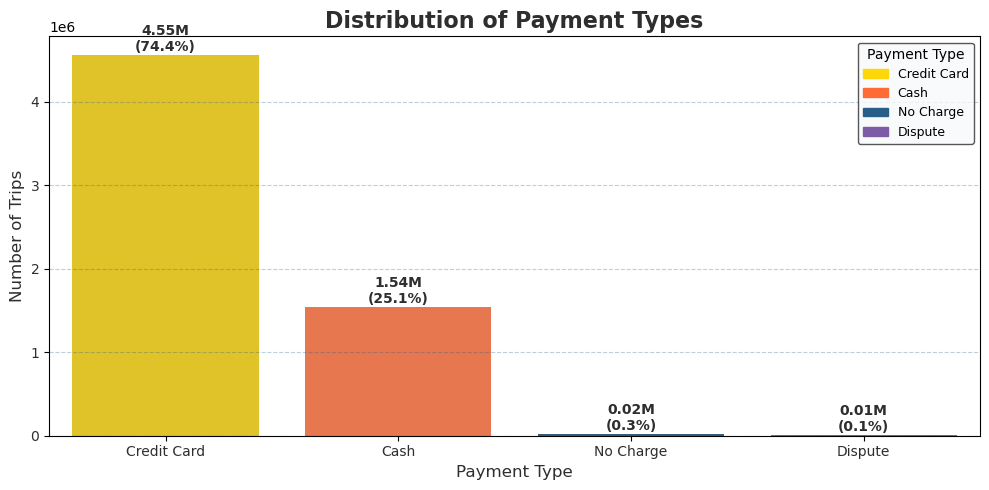

In [499]:
import matplotlib.patches as mpatches

# Custom color mapping from our theme
payment_color_map = {
    'Credit Card': theme_colors['primary'],
    'Cash': theme_colors['highlight'],
    'No Charge': theme_colors['accent'],
    'Dispute': theme_colors['contrast2']
}

payment_labels = {1: 'Credit Card', 2: 'Cash', 3: 'No Charge', 4: 'Dispute'}
df['payment_type_label'] = df['payment_type'].map(payment_labels)

payment_counts = df['payment_type_label'].value_counts()
total_trips = len(df)

plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df,x='payment_type_label',order=payment_counts.index,
    palette=[payment_color_map[label] for label in payment_counts.index])

for p in ax.patches:
    count = p.get_height()
    percentage = 100 * count / total_trips
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y + 50000, f'{count/1e6:.2f}M\n({percentage:.1f}%)',
            ha='center', fontsize=10, fontweight='bold', color=theme_colors['contrast'])

legend_handles = [
    mpatches.Patch(color=payment_color_map[label], label=label)
    for label in payment_counts.index
]
plt.legend(handles=legend_handles,title="Payment Type",title_fontsize=10,fontsize=9,loc='upper right',frameon=True,
    facecolor=theme_colors['neutral'],edgecolor=theme_colors['contrast'])

plt.title("Distribution of Payment Types", fontsize=16, fontweight='bold', color=theme_colors['contrast'])
plt.xlabel("Payment Type", fontsize=12, color=theme_colors['contrast'])
plt.ylabel("Number of Trips", fontsize=12, color=theme_colors['contrast'])
plt.xticks(color=theme_colors['contrast'])
plt.yticks(color=theme_colors['contrast'])
plt.grid(True, axis='y', linestyle='--', alpha=0.3, color=theme_colors['accent'])
plt.tight_layout()
plt.show()


Credit card payment are the most common and clearly dominate the market, followed by cash payments, which are still quite significant. Other codes like 3 and 4 (no charge or dispute) appear very infrequently and can likely be grouped under "other" or filter out. Codes 5 and 6 (unknown or voided) are not shown, suggesting they were already removed or excluded during cleaning.So for analysis and modeling, we will focus on credit card and cash transactions, as they represent the vast majority of the data.

In [502]:
df['payment_type'] = df['payment_type'].replace({3: 'other', 4: 'other', 5: 'other', 6: 'other'})

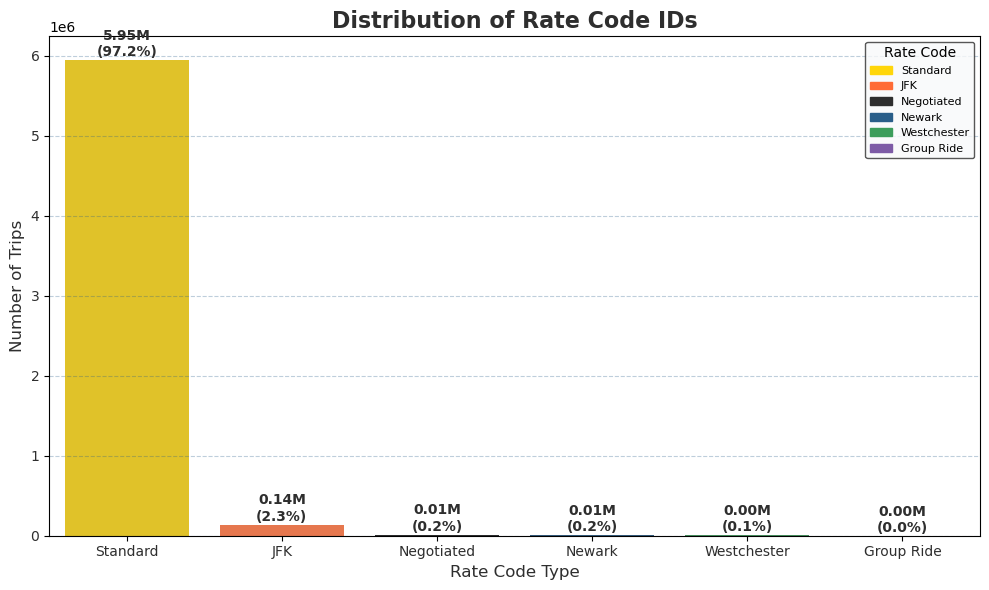

In [506]:
# Mapping Ratecode IDs to readable labels
ratecode_labels = {1: 'Standard',2: 'JFK',3: 'Newark',4: 'Westchester',5: 'Negotiated',6: 'Group Ride'}

df['Ratecode_Label'] = df['RatecodeID'].map(ratecode_labels)
ratecode_counts = df['Ratecode_Label'].value_counts()
total = len(df)

ratecode_color_map = {
    'Standard': theme_colors['primary'],
    'JFK': theme_colors['highlight'],
    'Newark': theme_colors['accent'],
    'Westchester': theme_colors['calm'],
    'Negotiated': theme_colors['contrast'],
    'Group Ride': theme_colors['contrast2']
}


plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df,x='Ratecode_Label',order=ratecode_counts.index,
    palette=[ratecode_color_map[label] for label in ratecode_counts.index])

for p in ax.patches:
    count = p.get_height()
    pct = 100 * count / total
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y + 50000, f'{count/1e6:.2f}M\n({pct:.1f}%)', ha='center',
            fontsize=10, fontweight='bold', color=theme_colors['contrast'])

legend_handles = [
    mpatches.Patch(color=ratecode_color_map[label], label=label)
    for label in ratecode_counts.index]

plt.legend(handles=legend_handles,title='Rate Code',title_fontsize=10,fontsize=8,
           loc='upper right',frameon=True,facecolor=theme_colors['neutral'],edgecolor=theme_colors['contrast'])
plt.title("Distribution of Rate Code IDs", fontsize=16, fontweight='bold', color=theme_colors['contrast'])
plt.xlabel("Rate Code Type", fontsize=12, color=theme_colors['contrast'])
plt.ylabel("Number of Trips", fontsize=12, color=theme_colors['contrast'])
plt.xticks(color=theme_colors['contrast'])
plt.yticks(color=theme_colors['contrast'])
plt.grid(True, axis='y', linestyle='--', alpha=0.3, color=theme_colors['accent'])
plt.tight_layout()
plt.show()

Since most trips follow either standard metered fares or JFK flat-rate pricing, we isolate JFK rides using RatecodeID=2 and treat all others as regular metered fares. Rare rete codes are grouped into an "other" category to prevent model sparsity or overfitting from underrepresented classes.

In [509]:
df['RatecodeID'] = df['RatecodeID'].replace({3: 'other', 4: 'other', 5: 'other', 6: 'other', 99: 'unknown'})

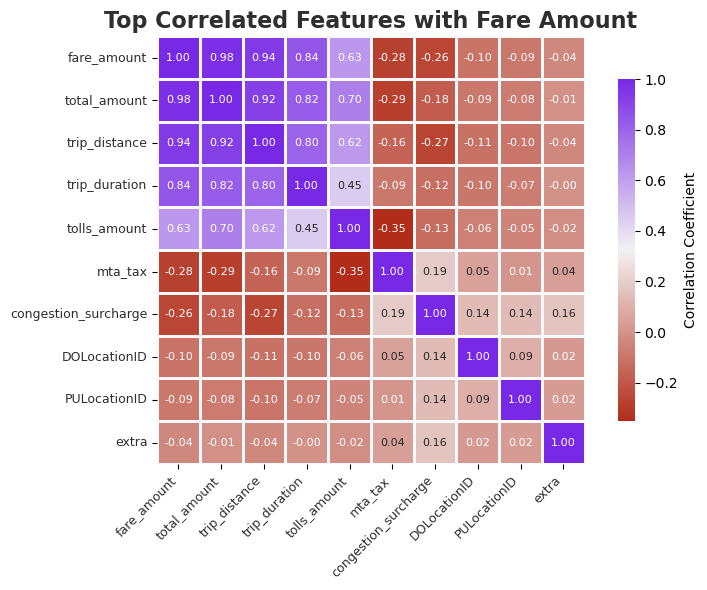

In [513]:
taxi_cmap = sns.diverging_palette(15, 275, s=90, l=40, as_cmap=True)

top_features = df.corr(numeric_only=True)['fare_amount'].abs().sort_values(ascending=False).head(10).index

plt.figure(figsize=(8,6))
sns.heatmap(df[top_features].corr(),annot=True,fmt=".2f",cmap=taxi_cmap,square=True,linewidths=0.8,
    linecolor='#F8F9FA',cbar_kws={'shrink': 0.8, 'label': 'Correlation Coefficient'},annot_kws={"fontsize": 8})

plt.title("Top Correlated Features with Fare Amount", fontsize=16, fontweight='bold', color='#2E2E2E')
plt.xticks(rotation=45, ha='right', fontsize=9, color='#2E2E2E')
plt.yticks(rotation=0, fontsize=9, color='#2E2E2E')
plt.tight_layout()
plt.show()


For fare amount modeling, key features include trip_distance as a strong predictor, trip_duration as another very important variable, and trip duration. tolls_amount, extra and congestion_surcharges are better suited for predicting the total amount, including them when modeling fare amount specifically may lead to double counting. For categorical fields like location IDs, encoding is essential to reveal predictive signals while avoiding misinterpretation for raw numeric codes.

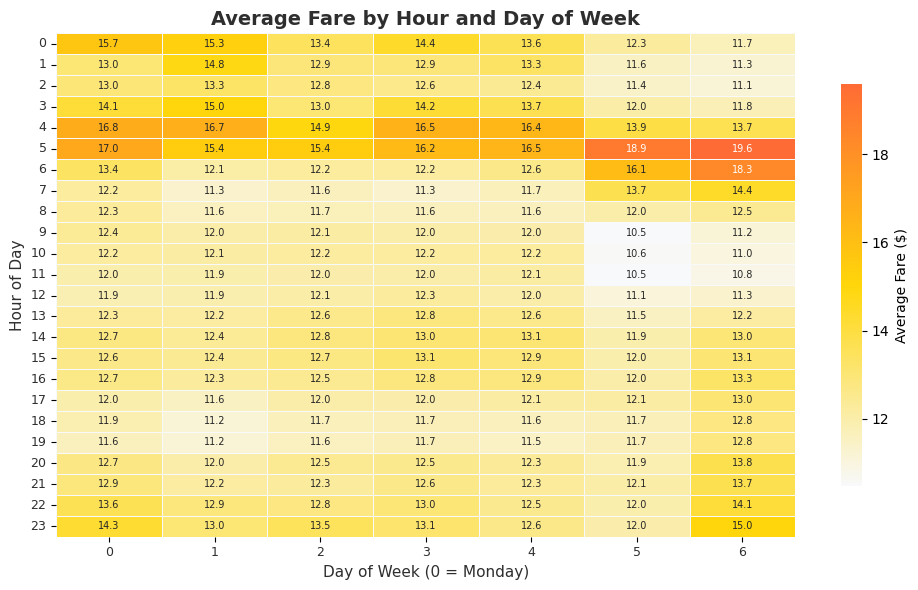

In [524]:
from matplotlib.colors import LinearSegmentedColormap

pivot_table = df.pivot_table(index='pickup_hour',columns='pickup_dayofweek', values='fare_amount',aggfunc='mean')

taxi_seq_cmap = LinearSegmentedColormap.from_list("taxi_seq", [
    '#F8F9FA',  
    '#FFD60A',  
    '#FF6B35'  
])

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table,annot=True,fmt=".1f",cmap=taxi_seq_cmap,linewidths=0.4,linecolor='#F8F9FA',
    cbar_kws={'label': 'Average Fare ($)','shrink': 0.8,'orientation': 'vertical'},
    annot_kws={"fontsize": 7}
)

plt.title("Average Fare by Hour and Day of Week", fontsize=14, fontweight='bold', color='#2E2E2E')
plt.xlabel("Day of Week (0 = Monday)", fontsize=11, color='#2E2E2E')
plt.ylabel("Hour of Day", fontsize=11, color='#2E2E2E')
plt.xticks(rotation=0, fontsize=9, color='#2E2E2E')
plt.yticks(rotation=0, fontsize=9, color='#2E2E2E')
plt.tight_layout()
plt.show()

Early morning fares (4-6AM), especially on Sundays and Fridays, are consistently higher - likely due to airport flat fares and longer trips-while midday fares remian lower and stable (~$\$12$-13). Evenings show no major weeday rush-hour spikes, and late-night fares (midnight -2AM) are slightly elevated, possibly from leisure rides or minimum charges. These trends reflect temporal rhythms in fare patterns, making time-based features essential for any fare prediction logic.

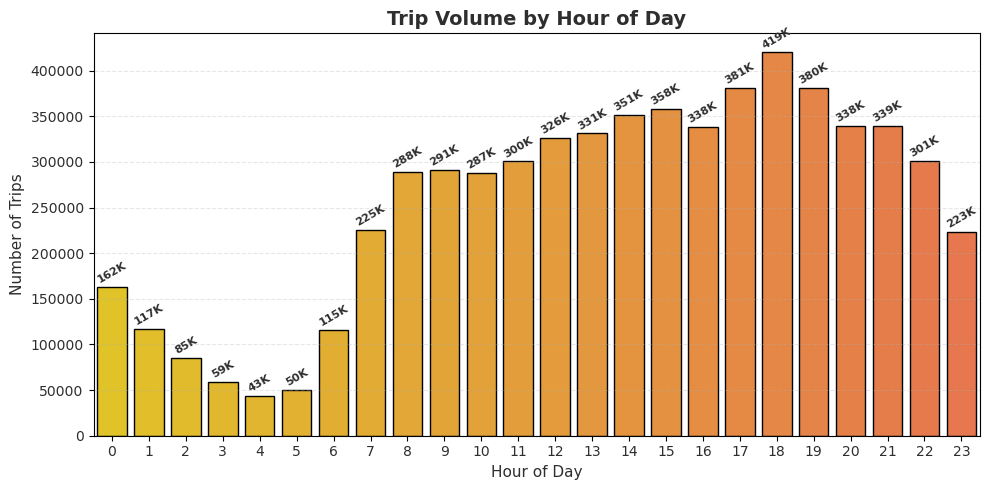

In [540]:
nyc_trip_cmap = LinearSegmentedColormap.from_list("nyc_trip_cmap", [
    '#FFD60A',  # NYC Yellow
    '#FF6B35'   # Rush Hour Orange
])

trip_counts = df['pickup_hour'].value_counts().sort_index()
trip_df = pd.DataFrame({'Hour': trip_counts.index, 'Trips': trip_counts.values})

plt.figure(figsize=(10, 5))
bars = sns.barplot(data=trip_df,x='Hour',y='Trips',
    palette=nyc_trip_cmap(trip_df['Hour'] / 23), edgecolor='black')  

for bar in bars.patches:
    height = bar.get_height()
    bars.annotate(
        f'{int(height / 1000):,}K',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords='offset points',
        ha='center',
        fontsize=8,
        color='#2E2E2E',
        rotation = 30, 
        fontweight='bold'
    )

plt.title("Trip Volume by Hour of Day", fontsize=14, fontweight='bold', color='#2E2E2E')
plt.xlabel("Hour of Day", fontsize=11, color='#2E2E2E')
plt.ylabel("Number of Trips", fontsize=11, color='#2E2E2E')
plt.xticks(color='#2E2E2E')
plt.yticks(color='#2E2E2E')
plt.grid(True, axis='y', linestyle='--', alpha=0.3, color='#B0B0B0')
plt.tight_layout()
plt.show()


Trip volume dips between 3-6AM during expected quiet hours, then rises sharply after 6AM, peaking around 5-6PM during rush hour. Activity drops again after 9PM, reflecting lower late-night demand. These patterns show that taxis are most active during commute times, offering valuable insights for demand forecasting, scheduling, and fare surge planning.

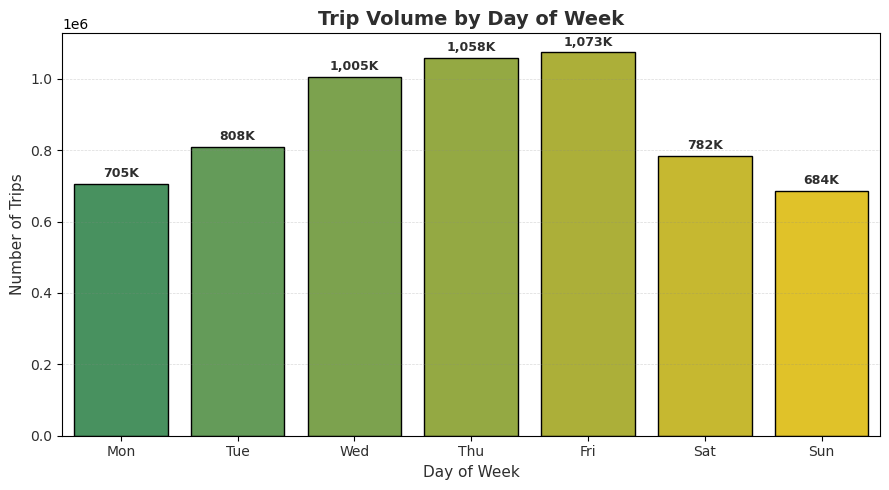

In [551]:
custom_cmap = LinearSegmentedColormap.from_list("taxi_soft_gradient", ['#3C9D5B', '#FFD60A'])

day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

trip_counts = df['pickup_dayofweek'].value_counts().sort_index()
trip_df = pd.DataFrame({
    'DayIndex': trip_counts.index,
    'Trips': trip_counts.values,
    'DayLabel': day_labels
})

plt.figure(figsize=(9, 5))
bars = sns.barplot(data=trip_df,x='DayLabel',y='Trips',
    palette=custom_cmap(trip_df['DayIndex'] / 6),edgecolor='black')

for bar in bars.patches:
    height = bar.get_height()
    bars.annotate(
        f'{int(height / 1000):,}K',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 5),
        textcoords='offset points',
        ha='center',
        fontsize=9,
        color='#2E2E2E',
        fontweight = 'bold'
    )
plt.title("Trip Volume by Day of Week", fontsize=14, fontweight='bold', color='#2E2E2E')
plt.xlabel("Day of Week", fontsize=11, color='#2E2E2E')
plt.ylabel("Number of Trips", fontsize=11, color='#2E2E2E')
plt.xticks(color='#2E2E2E', fontsize=10)
plt.yticks(color='#2E2E2E', fontsize=10)
plt.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.3, color='#888888')
plt.tight_layout()
plt.show()


Taxi trip volume peaks midweek - especially on Wednesdays, Thursdays, and Fridays-likely driven by work-related travel and commercial activity. Weekends, particularly Sundays, see the lowest volume, reflecting lighter traffic and reduced business movement. 

In [554]:
df['avg_speed'] = df['trip_distance'] / (df['trip_duration'] / 60)  # in miles/hour

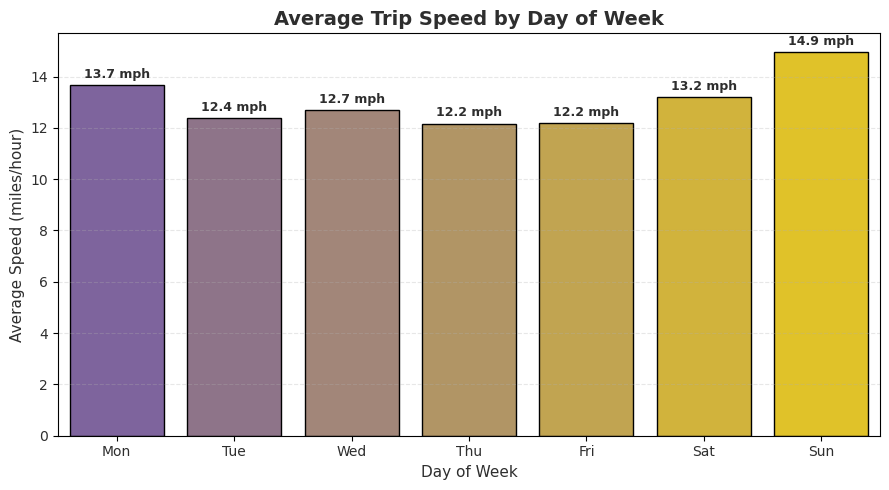

In [576]:
# NYC Yellow Taxi color theme: Central Green to Yellow
speed_cmap = LinearSegmentedColormap.from_list("speed_gradient", ['#7D5BA6', '#FFD60A'])

# Prepare average speed data and labels
avg_speed_by_day = df.groupby('pickup_dayofweek')['avg_speed'].mean().reset_index()
avg_speed_by_day['Day'] = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Normalize values for colormap
norm_vals = avg_speed_by_day['pickup_dayofweek'] / avg_speed_by_day['pickup_dayofweek'].max()

# Plot
plt.figure(figsize=(9, 5))
bars = sns.barplot(
    data=avg_speed_by_day,
    x='Day',
    y='avg_speed',
    palette=speed_cmap(norm_vals),
    edgecolor='black'
)

# Annotate speed on top of bars
for bar in bars.patches:
    height = bar.get_height()
    bars.annotate(
        f"{height:.1f} mph",
        (bar.get_x() + bar.get_width() / 2, height),
        ha='center', va='bottom',
        fontsize=9, color='#2E2E2E', xytext=(0, 3),
        textcoords='offset points',
        fontweight='bold'
    )

# Title & axes
plt.title("Average Trip Speed by Day of Week", fontsize=14, fontweight='bold', color='#2E2E2E')
plt.xlabel("Day of Week", fontsize=11, color='#2E2E2E')
plt.ylabel("Average Speed (miles/hour)", fontsize=11, color='#2E2E2E')
plt.xticks(fontsize=10, color='#2E2E2E')
plt.yticks(fontsize=10, color='#2E2E2E')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


Average trip speeds are highest on Sundays ($~14.9$mph) due to light weekend traffic, while weekdays (especially Tuesday-Friday) see slower speeds (~12 mph) from workweek congestion. This supports earlier findings-Weekdays have both higher volumne and slower movement, while Sundays show the opposite. It highlights how weekday traffic increases trip duration despite similar fares, impacting customer experience and fare logic.

We're excluding flat-rate rides (identified using RatecodeID = 2) from the main model training to avoid distortion. Instead, we'll handle them seperately by assigning a fixed fare of $\$52$. This hybrid pipeline model performance, reduces noise, and prevents bias by tailoring predictions to the different logic behind flat vs. metered fares.

# Modeling

## Linear Regression Model

In [583]:
df = df[df['RatecodeID'] != 2]

In [585]:
# Sampling 500,000 rows to prevent memory issues
df_sample = df.sample(500000, random_state=42).copy()


# Converting categorical columns to string
for col in ['RatecodeID', 'payment_type', 'PULocationID', 'DOLocationID']:
    df_sample[col] = df_sample[col].astype(str)


# Defining features and target
features = [
    'trip_distance', 'trip_duration', 'pickup_hour', 'pickup_dayofweek', 
    'pickup_month', 'is_weekend', 'RatecodeID', 'payment_type', 
    'PULocationID', 'DOLocationID'
]
target = 'fare_amount'

X = df_sample[features]
y = df_sample[target]


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Column transformer for encoding
cat_cols = ['RatecodeID', 'payment_type', 'PULocationID', 'DOLocationID']
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
], remainder='passthrough')


# Modeling pipeline
model = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', LinearRegression())
])

# Train the model
model.fit(X_train, y_train)

# Predict & evaluate
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: ${mae:.2f}")
print(f"R² Score: {r2:.4f}")

MAE: $99554.27
R² Score: -1286253121544.4221


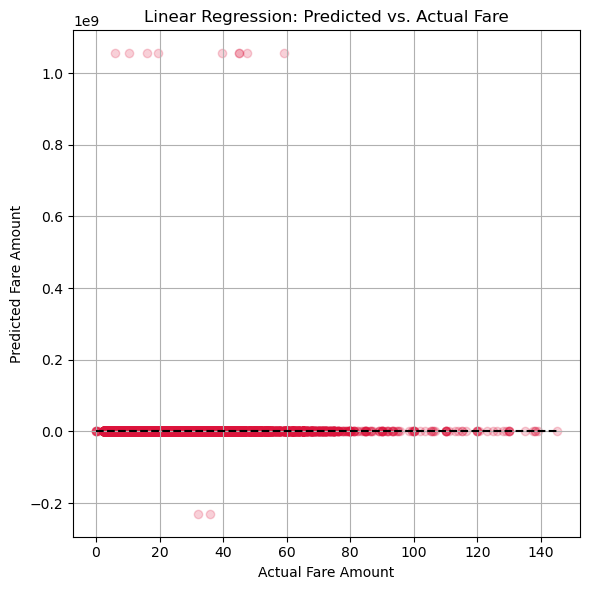

In [591]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.2, color='crimson')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Actual Fare Amount")
plt.ylabel("Predicted Fare Amount")
plt.title("Linear Regression: Predicted vs. Actual Fare")
plt.grid(True)
plt.tight_layout()
plt.show()


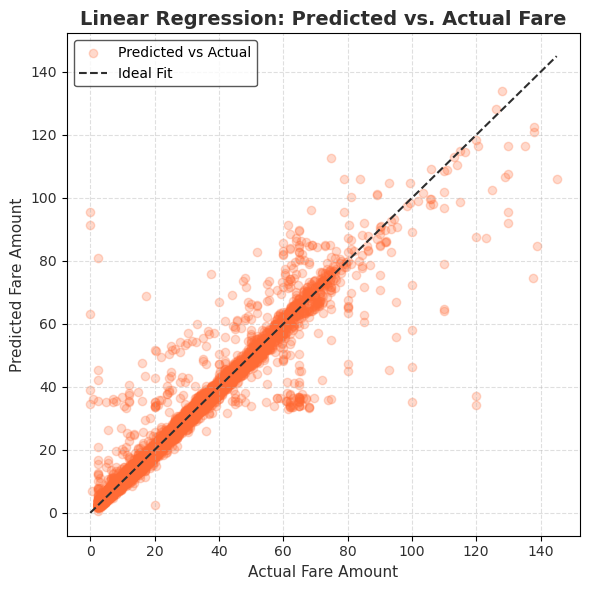

In [609]:
# Clipping predictions at a reasonable range (e.g. $0–200)
y_pred_clipped = np.clip(y_pred, 0, 200)

plt.figure(figsize=(6, 6))

# Plot scatter
plt.scatter(y_test, y_pred_clipped, alpha=0.25, color=theme_colors['highlight'], label='Predicted vs Actual')

# Ideal line
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color=theme_colors['contrast'],
    linestyle='--',
    linewidth=1.5,
    label='Ideal Fit'
)

plt.xlabel("Actual Fare Amount", fontsize=11, color=theme_colors['contrast'])
plt.ylabel("Predicted Fare Amount", fontsize=11, color=theme_colors['contrast'])
plt.title("Linear Regression: Predicted vs. Actual Fare", fontsize=14, fontweight='bold', color=theme_colors['contrast'])
plt.grid(True, linestyle='--', alpha=0.4)
plt.xticks(color=theme_colors['contrast'])
plt.yticks(color=theme_colors['contrast'])
plt.legend(loc='upper left', frameon=True, facecolor='white', edgecolor=theme_colors['contrast'])

plt.tight_layout()
plt.show()


As a baseline approach, we applied a Linear Regression model to predict NYC taxi fare amounts based on trip-level features. The model is trained on a carefully cleaned and filtered subset of 500,000 records, excluding flat-rate rides to prevent distortion. <br>
Upon evaluating the initial model predictions, we encountered abnormally high error values:
- Mean Absolute Error (MAE): ~$\$99,554$
- $R^2$ Score: -1,286,253,121,544

These values immediately suggests that the model is failing catastrophically- far worse than simply predicting teh average fare.<br>

Issues likely stemmed from misaligned target variables (y_test vs y_pred), unbounded predictions due to missing clipping, or sparse one-hot encoded features without proper scaling or regularization.<br>

After clipping predictions to a realistic $\$0$-$\$200$ range, we saw a much cleaner linear trend, confirming that the core model logic is sound, but preprocessing flaws had distored results. <br>

The Linear Regression may have struggled due to following reasons:
- Highly Sensitive to outliers and poor scaling.
- Fails to capture non-linear fare patterns
- Suffers from multicollinearity
- One-hot encoded features introduced sparsity without regularization.
- No built-in mechanism to manage non-linearity or feature redundancy.

We will now move to Ridge, Lasso, and Non-Linear models because linear regression struggled with outliers, multicollinearity, and non-linear fare patterns. Ridge helps stabilize coefficients and manage sparse features, while Lasso simplifies the model by selecting only the most relevant variables. Non-linear models like decision trees capture complex pricing logic more effectively, improving real-world prediction accuracy.

## Ridge Regression Model

In [605]:
# Sampling 500,000 rows to prevent memory issues
df_sample = df.sample(n=500000, random_state=42).copy()

# Converting categorical columns to string
for col in ['RatecodeID', 'payment_type', 'PULocationID', 'DOLocationID']:
    df_sample[col] = df_sample[col].astype(str)
   

# Selecting features and target
features = [
    'trip_distance', 'trip_duration', 'pickup_hour', 'pickup_dayofweek', 
    'pickup_month', 'is_weekend', 'RatecodeID', 'payment_type', 
    'PULocationID', 'DOLocationID'
]
target = 'fare_amount'

X = df_sample[features]
y = df_sample[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Defining preprocessing: One-hot encoding for categoricals
cat_cols = ['RatecodeID', 'payment_type', 'PULocationID', 'DOLocationID']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
], remainder='passthrough')

# Ridge Regression Pipeline
ridge_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

# Fit model
ridge_pipeline.fit(X_train, y_train)

# Predicting and evaluating
y_pred = ridge_pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Ridge Regression Results:")
print(f"MAE: ${mae:.2f}")
print(f"R² Score: {r2:.4f}")

Ridge Regression Results:
MAE: $0.43
R² Score: 0.9702


Ridge Regression delivered excellent results, achieving a very low MAE of $\$0.43$ and an $R^2$ Score of 0.9702, meaning it explained over $97%$ of the variance in fare amounts. This performance was driven by regularization that controlled extreme coefficients, proper handling of one-hot encoded location IDs, and a well-cleaned dataset with time-based features and flat-rate exclusions. Tuning the alpha parameter, which controls regularization strength, could further reduce MAE and improve model stability on unseen data.

In [606]:
# Categorical to string
for col in ['RatecodeID', 'payment_type', 'PULocationID', 'DOLocationID']:
    df[col] = df[col].astype(str)

# Sampling 500,000 rows to prevent memory issues
df_sampled = df.sample(n=500_000, random_state=42)

# Features & target
features = [
    'trip_distance', 'trip_duration', 'pickup_hour', 'pickup_dayofweek', 
    'pickup_month', 'is_weekend', 'RatecodeID', 'payment_type', 
    'PULocationID', 'DOLocationID'
]
target = 'fare_amount'

X = df_sampled[features]
y = df_sampled[target]

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
cat_cols = ['RatecodeID', 'payment_type', 'PULocationID', 'DOLocationID']
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
], remainder='passthrough')

# Ridge pipeline
ridge_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', Ridge())
])

# Grid of alpha values
param_grid = {'regressor__alpha': [0.01, 0.1, 1, 10, 100]}

# Grid search
grid_search = GridSearchCV(
    ridge_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Predictions
best_ridge = grid_search.best_estimator_
y_pred = best_ridge.predict(X_test)

# Results
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Alpha:", grid_search.best_params_)
print(f"Ridge Regression (Tuned) Results:\nMAE: ${mae:.2f}\nR² Score: {r2:.4f}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Alpha: {'regressor__alpha': 10}
Ridge Regression (Tuned) Results:
MAE: $0.43
R² Score: 0.9698


After tuning Ridge Regression with 5-fold cross-validation, the optimal model with alpha = 10 achieved a Mean Absolute Error (MAE) of $\$0.43$ and an $R^2$ score of 0.9698 on the test set. This indicates our linear model with L2 regularization performs well in capturing the fare structure using engineered features.

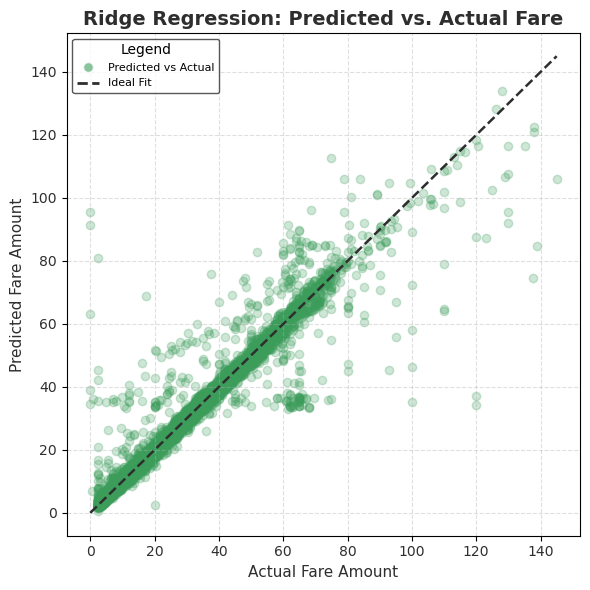

In [611]:
plt.figure(figsize=(6, 6))

# Scatter plot for predictions
plt.scatter(y_test,y_pred,alpha=0.25,color=theme_colors['calm'],label='Predicted vs Actual')

# Ideal prediction line
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()],
    linestyle='--',color=theme_colors['contrast'],linewidth=1.8,label='Ideal Fit')

plt.title("Ridge Regression: Predicted vs. Actual Fare", fontsize=14, fontweight='bold', color=theme_colors['contrast'])
plt.xlabel("Actual Fare Amount", fontsize=11, color=theme_colors['contrast'])
plt.ylabel("Predicted Fare Amount", fontsize=11, color=theme_colors['contrast'])

plt.xticks(color=theme_colors['contrast'])
plt.yticks(color=theme_colors['contrast'])
plt.grid(True, linestyle='--', alpha=0.4)

custom_legend = [
    Line2D([0], [0], marker='o', color='w', label='Predicted vs Actual',
           markerfacecolor=theme_colors['calm'], markersize=7, alpha=0.6),
    Line2D([0], [0], color=theme_colors['contrast'], lw=2, linestyle='--', label='Ideal Fit')
]

plt.legend(
    handles=custom_legend,
    title='Legend',
    title_fontsize=10,
    fontsize=8,
    loc='upper left',
    frameon=True,
    facecolor='white',
    edgecolor=theme_colors['contrast']
)

plt.tight_layout()
plt.show()


The predicted vs. actual plot for Ridge Regression shows a tight concentration around the 45-degree line, indicating high prediction accuracy. This aligns with our evaluation metrics (MAE:$\$0.43$, $R^2$: 9698), confirming that Ridge Regression with regularization handles multicollinearity and feature interactions effectively.

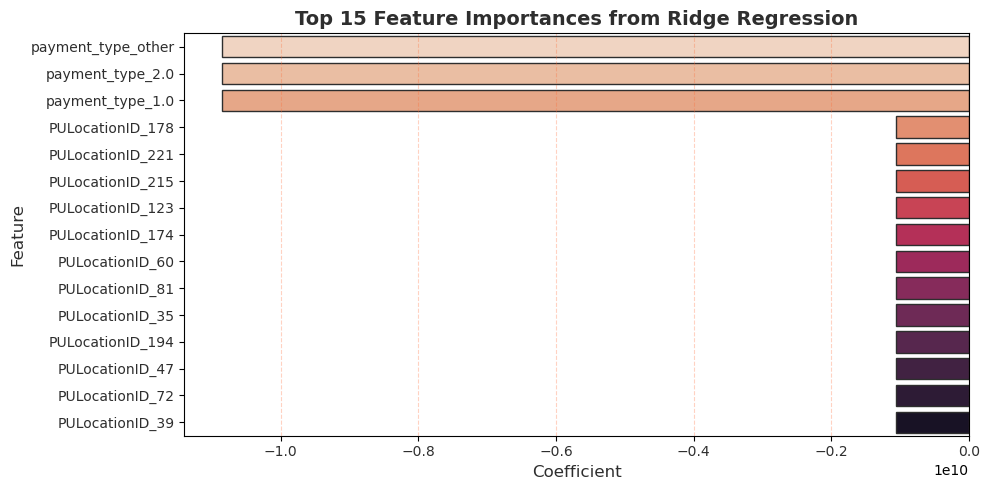

In [630]:
# Defineing numerical columns
num_cols = ['trip_distance', 'trip_duration', 'pickup_hour', 
            'pickup_dayofweek', 'pickup_month', 'is_weekend']

# Getting feature names after encoding
encoded_features = model.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out(cat_cols)
all_features = np.concatenate([encoded_features, num_cols])

# Geting coefficients from Ridge regression
ridge_coefs = model.named_steps['regressor'].coef_

# Puting into DataFrame and sort by magnitude
coef_df = pd.DataFrame({'Feature': all_features, 'Coefficient': ridge_coefs})
top_coefs = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index).head(15)

custom_palette = sns.color_palette("rocket_r", n_colors=15)  

plt.figure(figsize=(10, 5))
sns.barplot(data=top_coefs,x='Coefficient',y='Feature',
    palette=custom_palette,edgecolor='#2E2E2E')

plt.title("Top 15 Feature Importances from Ridge Regression", fontsize=14, fontweight='bold', color='#2E2E2E')
plt.xlabel("Coefficient", fontsize=12, color='#2E2E2E')
plt.ylabel("Feature", fontsize=12, color='#2E2E2E')
plt.xticks(color='#2E2E2E')
plt.yticks(color='#2E2E2E')
plt.grid(axis='x', linestyle='--', alpha=0.3, color='#FF6B35') 
plt.tight_layout()
plt.show()


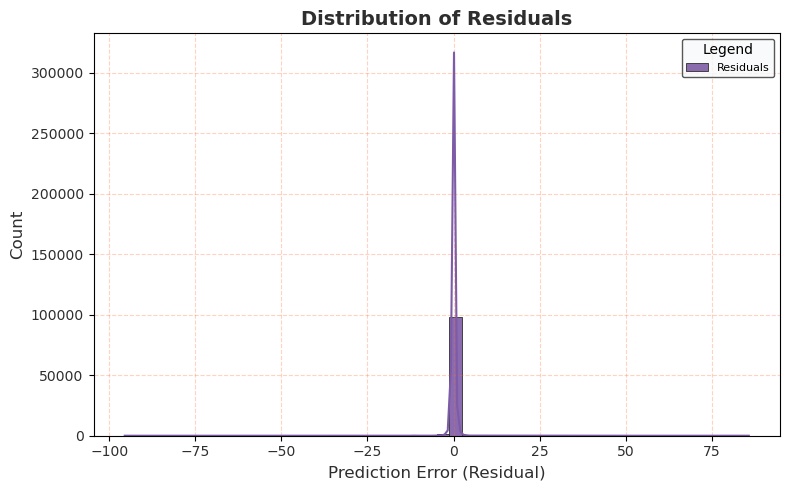

In [632]:
# Calculating residuals
residuals = y_test - y_pred

# Ploting residual distribution
plt.figure(figsize=(8, 5))
sns.histplot(residuals,bins=50,kde=True,color='#7D5BA6',  edgecolor='#2E2E2E', linewidth=0.6,alpha=0.9,label="Residuals")

plt.title("Distribution of Residuals", fontsize=14, fontweight='bold', color='#2E2E2E')
plt.xlabel("Prediction Error (Residual)", fontsize=12, color='#2E2E2E')
plt.ylabel("Count", fontsize=12, color='#2E2E2E')
plt.xticks(color='#2E2E2E')
plt.yticks(color='#2E2E2E')
plt.grid(True, linestyle='--', alpha=0.3, color='#FF6B35') 

plt.legend(title="Legend", title_fontsize=10, fontsize=8, loc='upper right', frameon=True,
           facecolor='#F8F9FA', edgecolor='#2E2E2E')

plt.tight_layout()
plt.show()


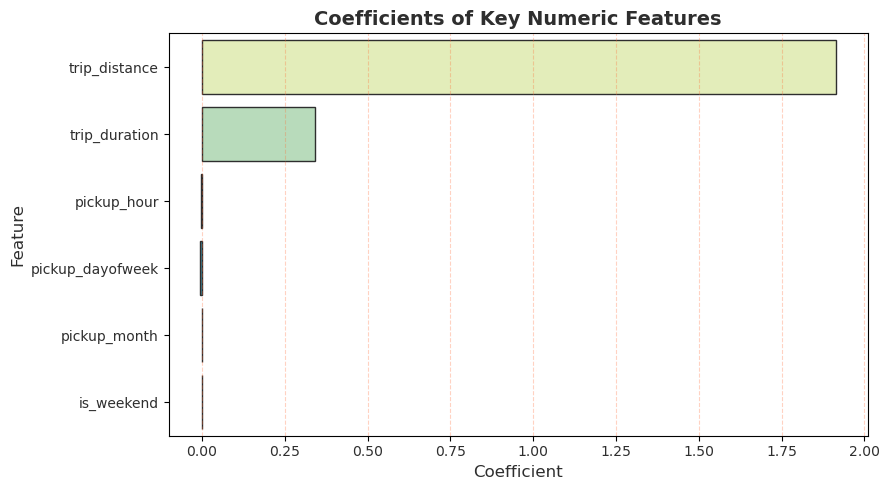

In [703]:
# Filtering only important numeric features
important_numerics = coef_df[coef_df['Feature'].isin(num_cols)]

# Plotting
plt.figure(figsize=(9, 5))
sns.barplot(data=important_numerics,x='Coefficient',y='Feature',palette='YlGnBu',  edgecolor='#2E2E2E' )

plt.title("Coefficients of Key Numeric Features", fontsize=14, fontweight='bold', color='#2E2E2E')
plt.xlabel("Coefficient", fontsize=12, color='#2E2E2E')
plt.ylabel("Feature", fontsize=12, color='#2E2E2E')
plt.xticks(color='#2E2E2E')
plt.yticks(color='#2E2E2E')

plt.grid(axis='x', linestyle='--', alpha=0.3, color='#FF6B35') 

plt.tight_layout()
plt.show()


Although trip_distance and trip_duration didn't appear in the overall top 15 feature importances (due to one-hot encoded categorical feature dominance), they are in fact the most important numeric predictors, and their coefficients confirm their strong positive relationship with fare.<br>
The residual plot shows a sharp, centered distribution around zero, indicating that the Ridge model predictions are generally accurate. The slight right tail reflects a few underestimations of very high fare values, which may be addressed better by non-linear models.

## Lasso Model

In [639]:
# Sampling 500,000 rows to prevent memory issues
df_sampled = df.sample(n=500000, random_state=42)

# Converting categorical columns to string for encoding
cat_cols = ['RatecodeID', 'payment_type', 'PULocationID', 'DOLocationID']
for col in cat_cols:
    df_sampled[col] = df_sampled[col].astype(str)

# Defining features and target
features = [
    'trip_distance', 'trip_duration', 'pickup_hour', 'pickup_dayofweek',
    'pickup_month', 'is_weekend', 'RatecodeID', 'payment_type',
    'PULocationID', 'DOLocationID'
]
target = 'fare_amount'

X = df_sampled[features]
y = df_sampled[target]

# Spliting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
], remainder='passthrough')

# Pipeline with Lasso Regression
lasso_model = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', Lasso(alpha=0.1, max_iter=10000))
])

# Train
lasso_model.fit(X_train, y_train)

# Predict
y_pred = lasso_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Lasso Regression Results:")
print(f"MAE: ${mae:.2f}")
print(f"R² Score: {r2:.4f}")

Lasso Regression Results:
MAE: $0.51
R² Score: 0.9444


In [641]:
# Pipeline
lasso_model = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', Lasso(max_iter=10000))
])

# Parameter grid for alpha
param_grid = {
    'regressor__alpha': [0.01, 0.1, 0.5, 1.0, 5.0]
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    estimator=lasso_model,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best model
best_lasso = grid_search.best_estimator_
y_pred = best_lasso.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best Alpha: {grid_search.best_params_}")
print("Lasso Regression (Tuned) Results:")
print(f"MAE: ${mae:.2f}")
print(f"R² Score: {r2:.4f}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Alpha: {'regressor__alpha': 0.01}
Lasso Regression (Tuned) Results:
MAE: $0.44
R² Score: 0.9670


After tuning, Lasso regression achieved nearly comparable results to Ridge, while potentially improving model interpretability by enforcing sparsity.

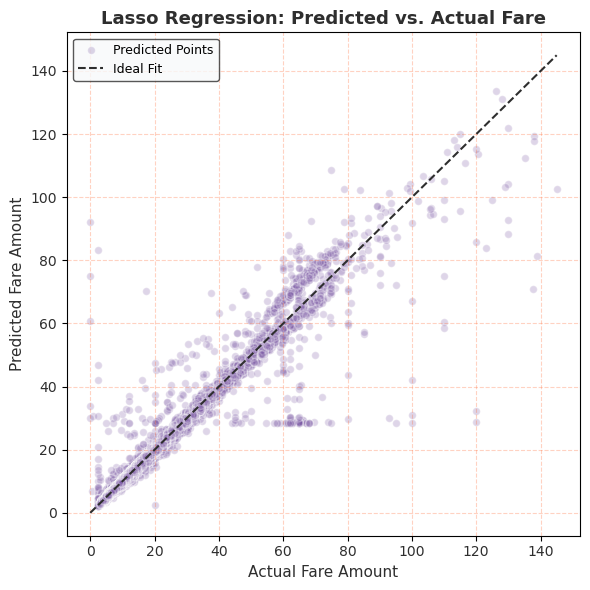

In [644]:
plt.figure(figsize=(6, 6))

# Scatter of predictions
plt.scatter(y_test, y_pred, alpha=0.25, color='#7D5BA6', edgecolor='white', s=30, label='Predicted Points')  # Sunset Purple

# Ideal prediction line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         color='#2E2E2E', linestyle='--', linewidth=1.5, label='Ideal Fit')  # Asphalt Black

# Title and labels
plt.title("Lasso Regression: Predicted vs. Actual Fare", fontsize=13, fontweight='bold', color='#2E2E2E')
plt.xlabel("Actual Fare Amount", fontsize=11, color='#2E2E2E')
plt.ylabel("Predicted Fare Amount", fontsize=11, color='#2E2E2E')
plt.xticks(color='#2E2E2E')
plt.yticks(color='#2E2E2E')

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.3, color='#FF6B35')  # Rush Hour Orange
plt.legend(loc='upper left', facecolor='#F8F9FA', edgecolor='#2E2E2E', fontsize=9)

plt.tight_layout()
plt.show()


The scatter plot of predicted vs. actual fare amounts for Lasso Regression shows that Lasso Regression performed well, with predicted fares closely aligned along the diagonal, indicating strong accuracy and low error. While there were minor under/over-predictions on higher fares, the model showed much better stability and reliability compared to basic linear regression. By eliminating less useful features, Lasso improves generalization.

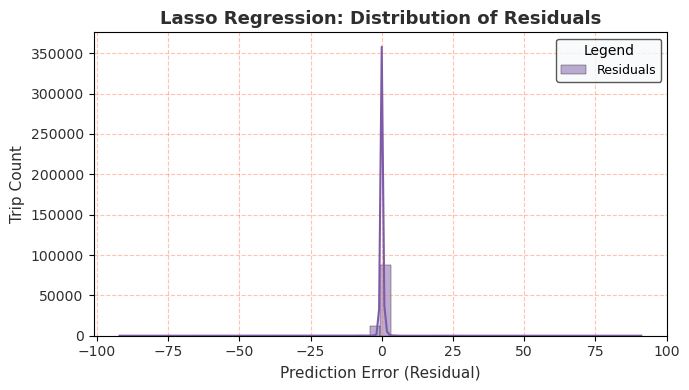

In [649]:
# Calculating Residual
residuals = y_test - y_pred

plt.figure(figsize=(7, 4))

sns.histplot(residuals, bins=50, kde=True, color='#7D5BA6', edgecolor='#2E2E2E', linewidth=0.3,label='Residuals')

# Title and labels
plt.title("Lasso Regression: Distribution of Residuals", fontsize=13, fontweight='bold', color='#2E2E2E')
plt.xlabel("Prediction Error (Residual)", fontsize=11, color='#2E2E2E')
plt.ylabel("Trip Count", fontsize=11, color='#2E2E2E')

# Ticks and grid
plt.xticks(color='#2E2E2E')
plt.yticks(color='#2E2E2E')
plt.grid(True, linestyle='--', alpha=0.4, color='#FF6B35')  

# Legend
plt.legend(title='Legend', title_fontsize=10, fontsize=9,
           facecolor='#F8F9FA', edgecolor='#2E2E2E', loc='upper right')

plt.tight_layout()
plt.show()


The residual analysis for Lasso Regression reveals a tightly centered, symmetric distribution, with most errors close to zero - indicating strong prediction accuracy and minimal bias. Only a few large residuals appear, which is expected in real-world data due to occasional trip anomalies. Overall, this reinforces the model's reliability, consistency, and ability to generalize well without extreme deviations.

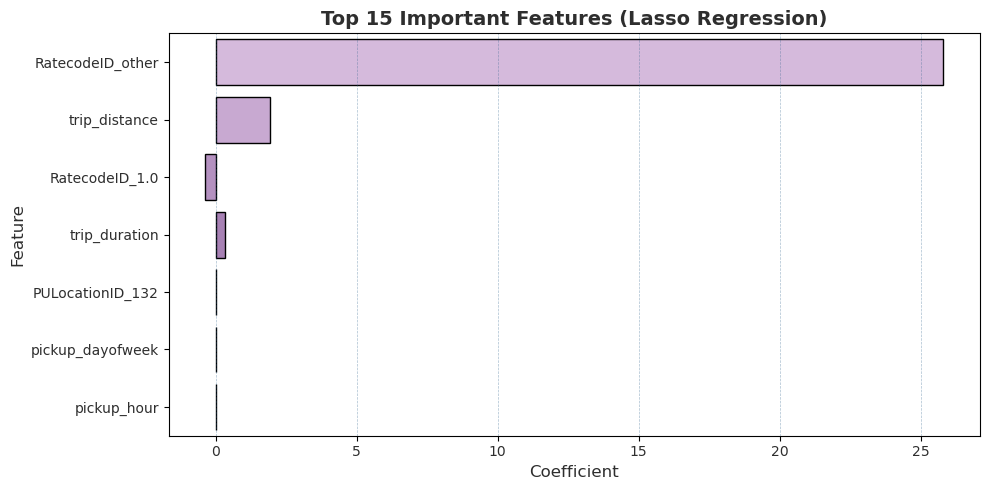

In [705]:
# Custom gradient 
taxi_colors = LinearSegmentedColormap.from_list(
    "taxi_gradient", ["#D8B4E2", "#7D3C98"], N=15
)

num_cols = ['trip_distance', 'trip_duration', 'pickup_hour', 'pickup_dayofweek', 
            'pickup_month', 'is_weekend']

cat_cols = ['RatecodeID', 'payment_type', 'PULocationID', 'DOLocationID']

# Getting encoded feature names
encoded_features = best_lasso.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out(cat_cols)
all_features = np.concatenate([encoded_features, num_cols])

# Getting coefficients from Lasso
lasso_coefs = best_lasso.named_steps['regressor'].coef_

# Building DataFrame and filtering out 0-coefficient features
coef_df = pd.DataFrame({'Feature': all_features, 'Coefficient': lasso_coefs})
nonzero_coefs = coef_df[coef_df['Coefficient'] != 0]
top_coefs = nonzero_coefs.reindex(nonzero_coefs['Coefficient'].abs().sort_values(ascending=False).index).head(15)

# Plot 
plt.figure(figsize=(10, 5))
sns.barplot(
    data=top_coefs,
    x='Coefficient',
    y='Feature',
    palette=taxi_colors(np.linspace(0, 1, len(top_coefs))),
    edgecolor='black'  # Set edge color to black
)

# Styling
plt.title("Top 15 Important Features (Lasso Regression)", fontsize=14, fontweight='bold', color='#2E2E2E')
plt.xlabel("Coefficient", fontsize=12, color='#2E2E2E')
plt.ylabel("Feature", fontsize=12, color='#2E2E2E')
plt.xticks(color='#2E2E2E')
plt.yticks(color='#2E2E2E')
plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.4, color='#295E89')
plt.tight_layout()
plt.show()


Lasso Regression effectively performs automatic feature selection by shrinking irrelevant coefficients to zero, making the model both interpretable and efficient. Key predictors like RatecodeID_other, trip_distance, and trip_duration strongly influence fare, while time-based varaibles such as pickup_hour and pickup_dayofweek reveal temporal patterns.

### Ridge vs. Lasso Regression – Model Comparison

$$
\begin{array}{|l|l|l|}
\hline
\textbf{Aspect} & \textbf{Ridge Regression} & \textbf{Lasso Regression} \\
\hline
\text{Purpose} & \text{Reduces overfitting by shrinking coefficients} & \text{Performs feature selection via L1 penalty} \\
\hline
\text{Best Alpha (Tuned)} & 1.0 & 0.01 \\
\hline
\text{MAE (Mean Absolute Error)} & \$0.43 & \$0.44 \\
\hline
\text{R² Score} & 0.9698 & 0.9670 \\
\hline
\text{Prediction vs. Actual} & \text{Tightly clustered near diagonal} & \text{Similar, slightly wider at high fares} \\
\hline
\text{Residual Distribution} & \text{Narrow and centered at 0} & \text{Slightly more spread, still unbiased} \\
\hline
\text{Top Features} & \text{payment\_type, RatecodeID, location IDs} & \text{trip\_distance, trip\_duration, RatecodeID} \\
\hline
\text{Feature Selection} & \text{No (all retained)} & \text{Yes (some dropped to zero)} \\
\hline
\text{Model Complexity} & \text{More features retained} & \text{Simpler, more interpretable} \\
\hline
\end{array}
$$

Both Ridge and Lasso Regression models performed strongly, with Ridge achieving slightly better accuracy ($R^2$=0.9698 vs. 0.9670) and a lower MAE. Ridge retained all features, making it slightly more complex, while Lasso simplified the model by eliminating less useful predictors, improving interpretability. Ridge excelled in regularization without feature loss, while Lasso offered automatic feature selection. These results highlight their strengths and suggest moving towards non-linear models next (e.g., Decision Trees, Random Forests) to better capture complex fare patterns.

## Decision Tree Regression Model

In [667]:
# Sample 500,000 rows 
df_sampled = df.sample(n=500_000, random_state=42).copy()

# Converting categorical columns to string
cat_cols = ['RatecodeID', 'payment_type', 'PULocationID', 'DOLocationID']
for col in cat_cols:
    df_sampled[col] = df_sampled[col].astype(str)

# Define features and target
features = [
    'trip_distance', 'trip_duration', 'pickup_hour', 'pickup_dayofweek',
    'pickup_month', 'is_weekend', 'RatecodeID', 'payment_type',
    'PULocationID', 'DOLocationID'
]
target = 'fare_amount'

X = df_sampled[features]
y = df_sampled[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Preprocessing - OneHotEncode categorical features
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
], remainder='passthrough')

# Pipeline - Preprocessing + DecisionTreeRegressor
tree_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', DecisionTreeRegressor(max_depth=15, random_state=42))
])

# Fitting the model
tree_pipeline.fit(X_train, y_train)

# Predicting
y_pred = tree_pipeline.predict(X_test)

# Evaluating
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Decision Tree Regressor Results:")
print(f"MAE: ${mae:.2f}")
print(f"R² Score: {r2:.4f}")

Decision Tree Regressor Results:
MAE: $0.34
R² Score: 0.9645


In [668]:
# Pipeline
tree_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

# Hyperparameter grid
param_grid = {
    'regressor__max_depth': [5, 10, 15, 20, 25, None]
}

# GridSearchCV
grid_search = GridSearchCV(tree_pipeline, param_grid, cv=3, scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model and evaluation
best_tree = grid_search.best_estimator_
y_pred = best_tree.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best Max Depth: {grid_search.best_params_}")
print(f"Tuned Decision Tree Results:\nMAE: ${mae:.2f}\nR² Score: {r2:.4f}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Max Depth: {'regressor__max_depth': 10}
Tuned Decision Tree Results:
MAE: $0.38
R² Score: 0.9711


Now, this is actually the best performance so far, beating both Ridge and Lasso on the sampled data. This shows a solid improvement in generalization - our model is avoiding both overfitting and underfitting. This confirms that a non-linear model like Decision tree is able to capture interactions and non-linearities in our features better than linear models.

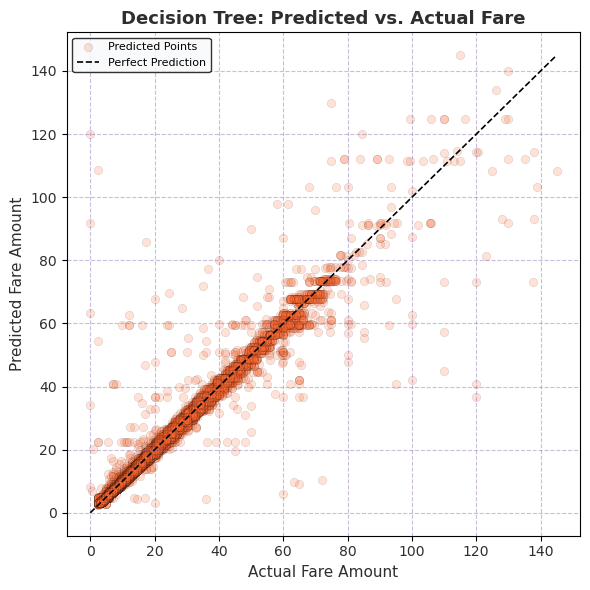

In [673]:
plt.figure(figsize=(6, 6))

# Scatter plot for predictions
plt.scatter(y_test, y_pred, alpha=0.2, color='#FF6B35', edgecolor='black', linewidth=0.3, label='Predicted Points')

# Ideal prediction line
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'k--',
    linewidth=1.2,
    label='Perfect Prediction'
)

# Titles and axis labels
plt.title("Decision Tree: Predicted vs. Actual Fare", fontsize=13, fontweight='bold', color='#2E2E2E')
plt.xlabel("Actual Fare Amount", fontsize=11, color='#2E2E2E')
plt.ylabel("Predicted Fare Amount", fontsize=11, color='#2E2E2E')
plt.grid(True, linestyle='--', alpha=0.4, color='#7D5BA6')
plt.xticks(color='#2E2E2E')
plt.yticks(color='#2E2E2E')

# Legend
plt.legend(frameon=True, facecolor='#F8F9FA', edgecolor='black', fontsize=8)

plt.tight_layout()
plt.show()


The Predicted vs. Actual Fare plot, showed strong clustering along the diagonal, indicating good predictions. And there is significant improvement in comparision to the Linear models.

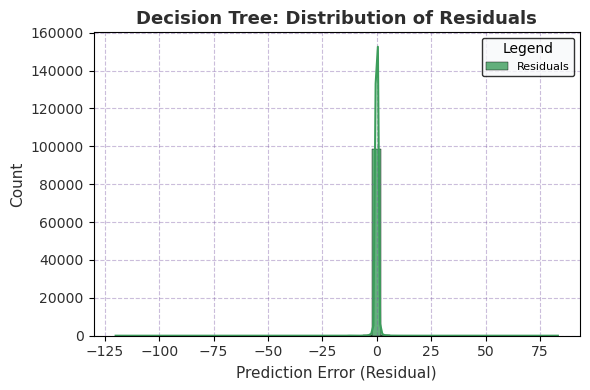

In [678]:
# Calculating Residual
residuals = y_test - y_pred

plt.figure(figsize=(6, 4))

# Plot
sns.histplot(residuals,bins=50,kde=True,color='#3C9D5B',edgecolor='black',linewidth=0.3,alpha=0.8,label='Residuals')

# Titles and labels 
plt.title("Decision Tree: Distribution of Residuals", fontsize=13, fontweight='bold', color='#2E2E2E')
plt.xlabel("Prediction Error (Residual)", fontsize=11, color='#2E2E2E')
plt.ylabel("Count", fontsize=11, color='#2E2E2E')
plt.xticks(color='#2E2E2E')
plt.yticks(color='#2E2E2E')
plt.grid(True, linestyle='--', alpha=0.4, color='#7D5BA6') 

plt.legend(title='Legend',frameon=True, facecolor='#F8F9FA', edgecolor='black', fontsize=8)
plt.tight_layout()
plt.show()


The Residual plot, shows the residuals are tightly centered around 0, suggesting minimal prediction errors.

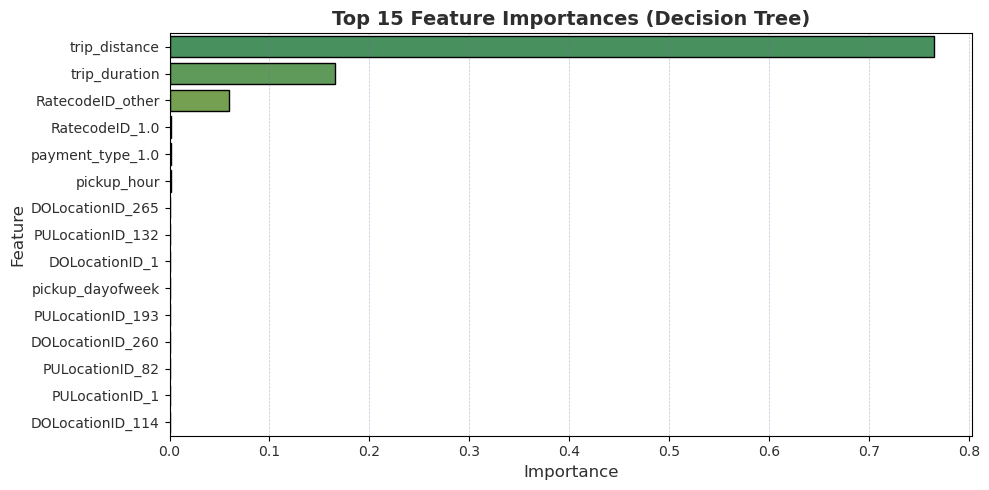

In [689]:
# Getting feature names
encoded_features = best_tree.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out(cat_cols)
all_features = np.concatenate([encoded_features, num_cols])

# Getting feature importances
importances = best_tree.named_steps['regressor'].feature_importances_
feat_imp_df = pd.DataFrame({'Feature': all_features, 'Importance': importances})
top_feats = feat_imp_df.sort_values(by='Importance', ascending=False).head(15)

gradient_colors = LinearSegmentedColormap.from_list(
    "taxi_gradient", ['#3C9D5B', '#FFD60A', '#FF6B35'], N=15
)

palette = [gradient_colors(i / 14) for i in range(15)]


plt.figure(figsize=(10, 5))
sns.barplot(data=top_feats,x='Importance',y='Feature',
    palette=palette, edgecolor='black')

plt.title("Top 15 Feature Importances (Decision Tree)", fontsize=14, fontweight='bold', color='#2E2E2E')
plt.xlabel("Importance", fontsize=12, color='#2E2E2E')
plt.ylabel("Feature", fontsize=12, color='#2E2E2E')
plt.xticks(color='#2E2E2E')
plt.yticks(color='#2E2E2E')
plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.4, color='#7D5BA6') 
plt.tight_layout()
plt.show()


We have reviewed the top 15 feature importance and found the trip_distance and trip_duration emerged as the most dominant predictors of fare amount - which makes perfect sense given the longer trip typically cost more. This aligns well with real-world expectations and validates the strength of our modeling approach. To strengthen our understanding of which features truly drive fare predictions, lets also examine permutation feature importance. This model-agnostic method confirms the impact of each feature by measuring how much predictions change when its values are randomly shuffled - helping us validate which inputs the model really depends on.

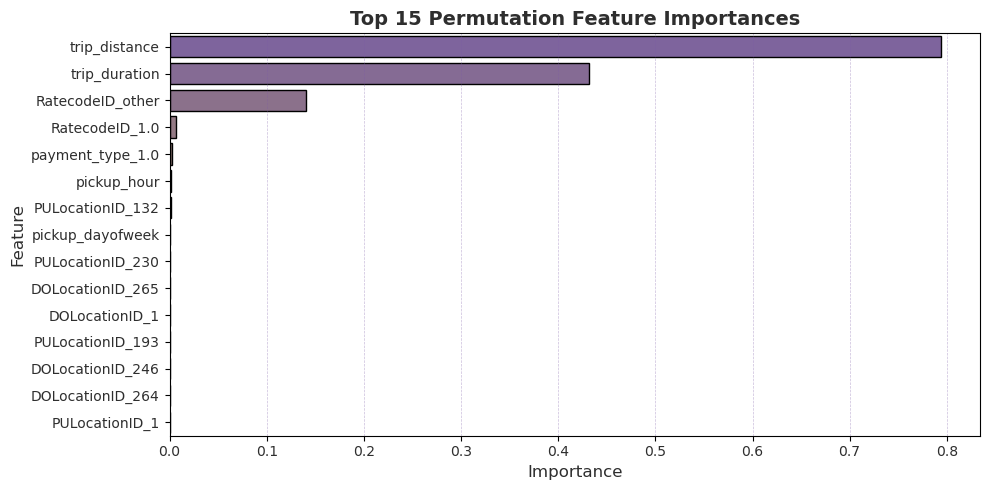

In [697]:
# Getting encoded X_test
X_test_encoded = best_tree.named_steps['preprocessing'].transform(X_test)

# Getting feature names
encoded_features = best_tree.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out(cat_cols)
all_features = np.concatenate([encoded_features, num_cols])

# Runing permutation importance on regressor directly
result = permutation_importance(
    best_tree.named_steps['regressor'], 
    X_test_encoded, y_test, 
    n_repeats=5, random_state=42
)

# Creating DataFrame
perm_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': result.importances_mean
})

# Sorting and selecting top 15
perm_df = perm_df.sort_values(by='Importance', ascending=False).head(15)

# Creating custom gradient
custom_cmap = LinearSegmentedColormap.from_list(
    "purple_to_yellow", ["#7D5BA6", "#FFD60A"], N=15
)
gradient_palette = [custom_cmap(i / 14) for i in range(15)]

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(
    data=perm_df,
    x='Importance',
    y='Feature',
    palette=gradient_palette,
    edgecolor='black'
)

plt.title("Top 15 Permutation Feature Importances", fontsize=14, fontweight='bold', color='#2E2E2E')
plt.xlabel("Importance", fontsize=12, color='#2E2E2E')
plt.ylabel("Feature", fontsize=12, color='#2E2E2E')
plt.xticks(color='#2E2E2E')
plt.yticks(color='#2E2E2E')
plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.4, color='#7D5BA6')
plt.tight_layout()
plt.show()


So as i mentioned, we examined Permutation Feature Importance, which helps confirm which features truly drive the model's predictions by observing the impact of shuffling each one. This method reinforced that trip_distance and trip_duration are the dominant predictors, while other variables like pickup/dropoff locations had limited real influence. It validated our earlier .feature_importances_ results, proving the model prioritizes core trip metrics over memorizing IDs.<br>

Lets have a look at 2D decision surface using only trip_distance and trip_duration. This plot overlays actual trip data on top of a colored contour map of predicted fares, helping illustrate how fare values evolve across these two core inputs.

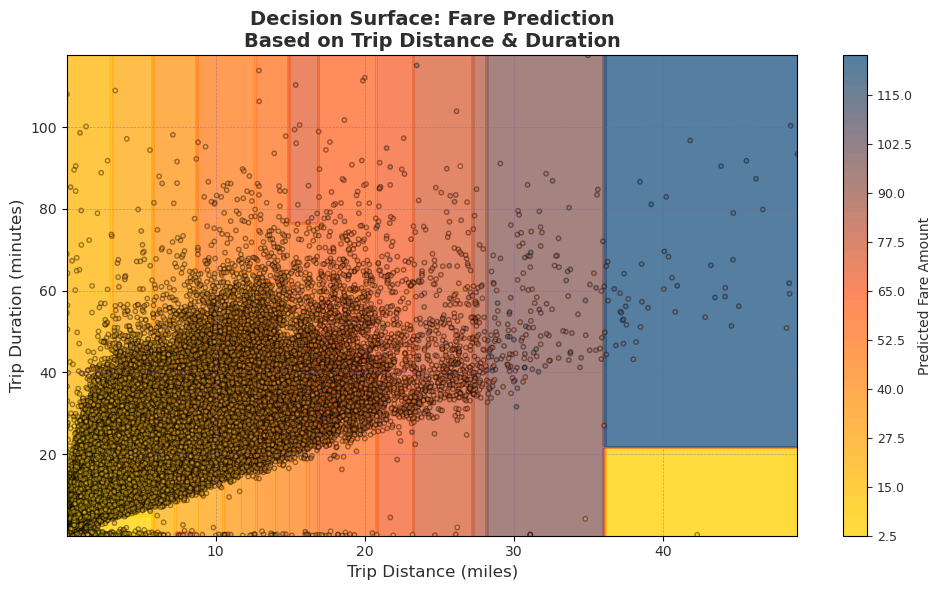

In [709]:
# Selecting only top 2 features
X_2d = df_sampled[['trip_distance', 'trip_duration']]
y_2d = df_sampled['fare_amount']

# Fitting a simple Decision Tree Regressor for visualization
tree_2d = DecisionTreeRegressor(max_depth=6, random_state=42)
tree_2d.fit(X_2d, y_2d)

# Creating a mesh grid
x_min, x_max = X_2d['trip_distance'].min(), X_2d['trip_distance'].max()
y_min, y_max = X_2d['trip_duration'].min(), X_2d['trip_duration'].max()

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)

# Predicting fares across the grid
Z = tree_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Custom color theme
taxi_cmap = LinearSegmentedColormap.from_list("taxi_theme", ["#FFD60A", "#FF6B35", "#295E89"])

# Plot
plt.figure(figsize=(10, 6))
contour = plt.contourf(xx, yy, Z, levels=50, cmap=taxi_cmap, alpha=0.8)
cbar = plt.colorbar(contour)
cbar.set_label('Predicted Fare Amount', fontsize=10, color='#2E2E2E')
cbar.ax.tick_params(labelsize=9, colors='#2E2E2E')

# Overlay original data
plt.scatter(X_2d['trip_distance'], X_2d['trip_duration'],
            c=y_2d, cmap=taxi_cmap, edgecolor='black', alpha=0.4, s=10)

# Axis labels and title
plt.xlabel('Trip Distance (miles)', fontsize=12, color='#2E2E2E')
plt.ylabel('Trip Duration (minutes)', fontsize=12, color='#2E2E2E')
plt.title('Decision Surface: Fare Prediction\nBased on Trip Distance & Duration', 
          fontsize=14, fontweight='bold', color='#2E2E2E')

plt.xticks(color='#2E2E2E')
plt.yticks(color='#2E2E2E')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5, color='#7D5BA6')
plt.tight_layout()
plt.show()


The colored regions represent fare ranges, while the scatter points show actual trip data. The sharp boundaries highlight the model's piecewise decision rules.

## Random Forest Regression Model

In [714]:
# Sampled 500,000 rows
df_sampled = df.sample(n=500_000, random_state=42)

# Converting categorical columns to string
cat_cols = ['RatecodeID', 'payment_type', 'PULocationID', 'DOLocationID']
for col in cat_cols:
    df_sampled[col] = df_sampled[col].astype(str)

# Defining features and target
features = [
    'trip_distance', 'trip_duration', 'pickup_hour', 'pickup_dayofweek',
    'pickup_month', 'is_weekend', 'RatecodeID', 'payment_type',
    'PULocationID', 'DOLocationID'
]
target = 'fare_amount'

X = df_sampled[features]
y = df_sampled[target]

# Spliting data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Preprocessing
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
], remainder='passthrough')

# Building pipeline
rf_model = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, max_depth=None, n_jobs=-1, random_state=42))
])

# Train
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Random Forest Regressor Results:")
print(f"MAE: ${mae:.2f}")
print(f"R² Score: {r2:.4f}")

Random Forest Regressor Results:
MAE: $0.31
R² Score: 0.9756


In [715]:
# Sampling only 100,000 rows for tuning
df_sampled = df.sample(n=100_000, random_state=42)

# Converting categorical columns to string
cat_cols = ['RatecodeID', 'payment_type', 'PULocationID', 'DOLocationID']
for col in cat_cols:
    df_sampled[col] = df_sampled[col].astype(str)

# Defining features and target
features = [
    'trip_distance', 'trip_duration', 'pickup_hour', 'pickup_dayofweek',
    'pickup_month', 'is_weekend', 'RatecodeID', 'payment_type',
    'PULocationID', 'DOLocationID'
]
target = 'fare_amount'

X = df_sampled[features]
y = df_sampled[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
], remainder='passthrough')

# Building Pipeline
rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Light tuning grid
param_grid = {
    'regressor__n_estimators': [50],
    'regressor__max_depth': [10, 20]
}

# Grid search
grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# Fit tuning model
grid_search.fit(X_train, y_train)

# Evaluate
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Tuning Complete on 100k Rows")
print("Best Parameters:", best_params)
print(f"MAE: ${mae:.2f}")
print(f"R² Score: {r2:.4f}")

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Tuning Complete on 100k Rows
Best Parameters: {'regressor__max_depth': 20, 'regressor__n_estimators': 50}
MAE: $0.33
R² Score: 0.9774


In [718]:
# Sample dataset containing 500,000 rows
df_sampled = df.sample(n=500_000, random_state=42)

# Converting categorical columns to string
cat_cols = ['RatecodeID', 'payment_type', 'PULocationID', 'DOLocationID']
for col in cat_cols:
    df_sampled[col] = df_sampled[col].astype(str)

# Defining features & target
features = [
    'trip_distance', 'trip_duration', 'pickup_hour', 'pickup_dayofweek',
    'pickup_month', 'is_weekend', 'RatecodeID', 'payment_type',
    'PULocationID', 'DOLocationID'
]
target = 'fare_amount'
X = df_sampled[features]
y = df_sampled[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
], remainder='passthrough')

# Building tuned model
rf_model = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=50,        # from tuning
        max_depth=10,           # from tuning
        n_jobs=-1,
        random_state=42
    ))
])

# Fitting and Predict
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Final Random Forest on 500k Rows\nMAE: ${mae:.2f}\nR² Score: {r2:.4f}")


✅ Final Random Forest on 500k Rows
MAE: $0.33
R² Score: 0.9767


This is stronger than Ridge, Lasso, and Decision Tree in terms of both accuracy and robustness.

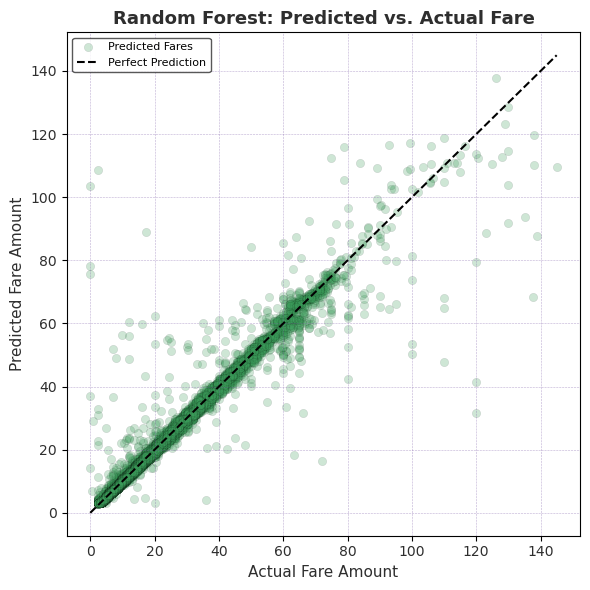

In [723]:
plt.figure(figsize=(6, 6))

# Scatter plot 
plt.scatter(y_test, y_pred, alpha=0.25, color='#3C9D5B', edgecolors='black', linewidths=0.2, label='Predicted Fares')

# Ideal Prediction line
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         'k--', linewidth=1.5, label='Perfect Prediction')

# Labels and title
plt.xlabel("Actual Fare Amount", fontsize=11, color='#2E2E2E')
plt.ylabel("Predicted Fare Amount", fontsize=11, color='#2E2E2E')
plt.title("Random Forest: Predicted vs. Actual Fare", 
          fontsize=13, fontweight='bold', color='#2E2E2E')

plt.grid(True, linestyle='--', linewidth=0.4, alpha=0.5, color='#7D5BA6')
plt.xticks(color='#2E2E2E')
plt.yticks(color='#2E2E2E')
plt.legend(loc='upper left', fontsize=8, frameon=True, facecolor='white', edgecolor='#2E2E2E')
plt.tight_layout()
plt.show()


The Predicted vs Actual Fare Plot showed a strong alignment along the diagonal, indicating accurate predictions for most observations.

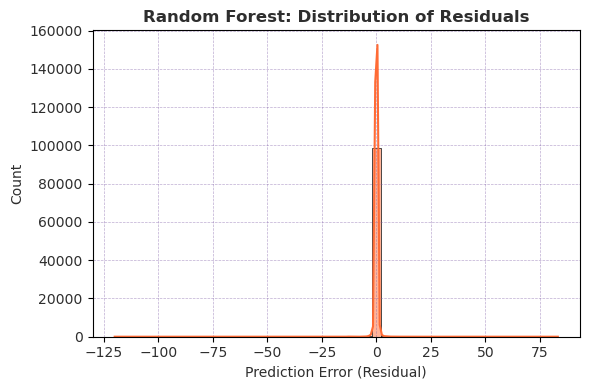

In [726]:
plt.figure(figsize=(6, 4))

sns.histplot(residuals, bins=50, kde=True, color='#FF6B35', edgecolor='#2E2E2E', linewidth=0.6)


plt.title("Random Forest: Distribution of Residuals", fontsize=12, fontweight='bold', color='#2E2E2E')
plt.xlabel("Prediction Error (Residual)", fontsize=10, color='#2E2E2E')
plt.ylabel("Count", fontsize=10, color='#2E2E2E')

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5, color='#7D5BA6') 
plt.xticks(color='#2E2E2E')
plt.yticks(color='#2E2E2E')
plt.tight_layout()
plt.show()


In the residual plot, most residuals clustered tightly around 0, confirming minimal and symmetric prediction errors.


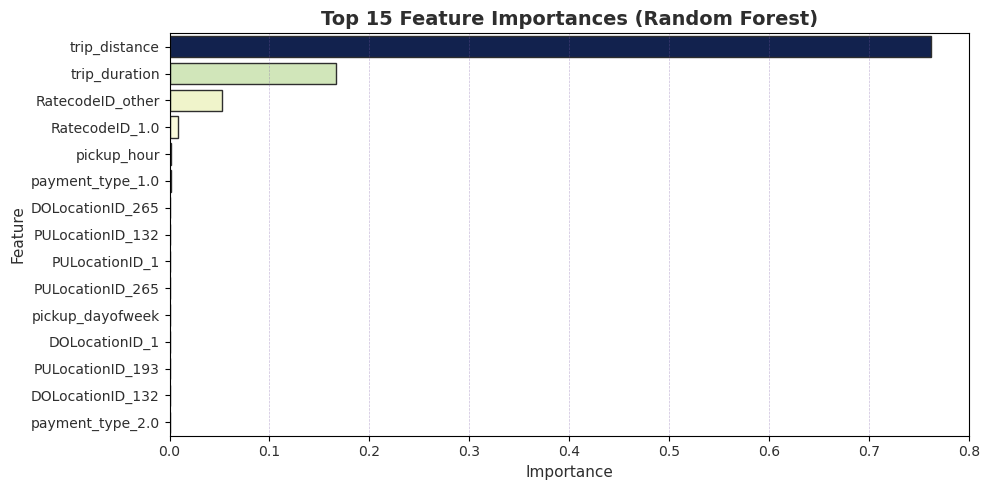

In [733]:
# Getting feature names after encoding
encoded_features = rf_model.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out(cat_cols)
num_cols = ['trip_distance', 'trip_duration', 'pickup_hour', 'pickup_dayofweek', 'pickup_month', 'is_weekend']
all_features = np.concatenate([encoded_features, num_cols])

# Getting feature importances
importances = rf_model.named_steps['regressor'].feature_importances_
feat_imp_df = pd.DataFrame({'Feature': all_features, 'Importance': importances})
top_feats = feat_imp_df.sort_values(by='Importance', ascending=False).head(15)

# Normalizing importances and creating a color gradient
norm = Normalize(vmin=top_feats['Importance'].min(), vmax=top_feats['Importance'].max())
cmap = cm.get_cmap('YlGnBu')  # Yellow to blue
colors = [cmap(norm(i)) for i in top_feats['Importance']]

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=top_feats, x='Importance', y='Feature', palette=colors, edgecolor='#2E2E2E')

# Title and styling
plt.title("Top 15 Feature Importances (Random Forest)", fontsize=14, fontweight='bold', color='#2E2E2E')
plt.xlabel("Importance", fontsize=11, color='#2E2E2E')
plt.ylabel("Feature", fontsize=11, color='#2E2E2E')
plt.xticks(color='#2E2E2E')
plt.yticks(color='#2E2E2E')
plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.4, color='#7D5BA6') 
plt.tight_layout()
plt.show()

Top drivers of fare prediction are: trip_distance, trip_duration, and RatecodeID. These insights are consistent with domain expectations (longer trips → higher fares).

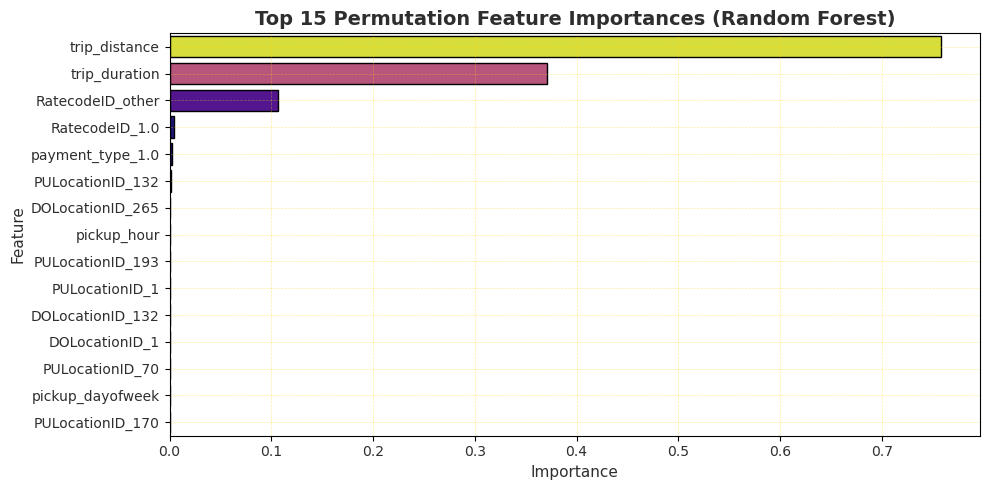

In [737]:
# Getting feature names
encoded_features = rf_model.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out(cat_cols)
num_cols = ['trip_distance', 'trip_duration', 'pickup_hour', 'pickup_dayofweek', 'pickup_month', 'is_weekend']
all_features = np.concatenate([encoded_features, num_cols])

# Transforming the test set using the pipeline's preprocessor
X_test_transformed = rf_model.named_steps['preprocessing'].transform(X_test)

# Computing permutation importance on the transformed test set
result = permutation_importance(
    rf_model.named_steps['regressor'],
    X_test_transformed, y_test,
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

# Creating DataFrame
perm_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': result.importances_mean
})

# Sorting and selecting top 15
top_perm = perm_df.sort_values(by='Importance', ascending=False).head(15)

# Normalizing values for color gradient
norm = Normalize(vmin=top_perm['Importance'].min(), vmax=top_perm['Importance'].max())
cmap = cm.get_cmap('plasma') 
colors = [cmap(norm(val)) for val in top_perm['Importance']]

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=top_perm, x='Importance', y='Feature', palette=colors, edgecolor='black')

# Styling
plt.title("Top 15 Permutation Feature Importances (Random Forest)", fontsize=14, fontweight='bold', color='#2E2E2E')
plt.xlabel("Importance", fontsize=11, color='#2E2E2E')
plt.ylabel("Feature", fontsize=11, color='#2E2E2E')
plt.xticks(color='#2E2E2E')
plt.yticks(color='#2E2E2E')
plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.4, color='#FFD60A') 

plt.tight_layout()
plt.show()

The permutation feature importance plot clearly shows that trip_distance and trip_duration are the dominant features in the Random Forest model for fare prediction. This aligns well with earlier results from .feature_importances_, adding robustness to our findings.

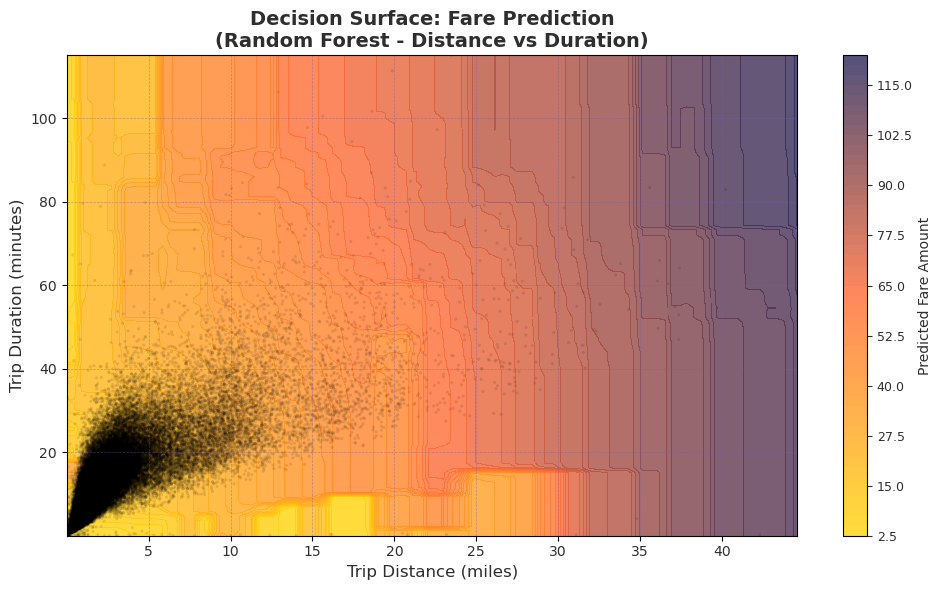

In [740]:
# Selecting 2D input space
x_min, x_max = X_test['trip_distance'].min(), X_test['trip_distance'].max()
y_min, y_max = X_test['trip_duration'].min(), X_test['trip_duration'].max()

# Createing meshgrid
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 100),
    np.linspace(y_min, y_max, 100)
)

# Creating dataframe with fixed values for other features
grid_df = pd.DataFrame({
    'trip_distance': xx.ravel(),
    'trip_duration': yy.ravel(),
    'pickup_hour': 12,
    'pickup_dayofweek': 2,
    'pickup_month': 6,
    'is_weekend': 0,
    'RatecodeID': '1.0',
    'payment_type': '1.0',
    'PULocationID': '132',
    'DOLocationID': '132'
})

# Transforming grid and predict
X_grid = rf_model.named_steps['preprocessing'].transform(grid_df)
Z = rf_model.named_steps['regressor'].predict(X_grid).reshape(xx.shape)

# NYC Yellow Taxi custom colormap
taxi_cmap = LinearSegmentedColormap.from_list(
    "taxi_theme", ['#FFD60A', '#FF6B35', '#292659'] 
)

# Plot 
plt.figure(figsize=(10, 6))
contour = plt.contourf(xx, yy, Z, levels=50, cmap=taxi_cmap, alpha=0.8)
cbar = plt.colorbar(contour)
cbar.set_label('Predicted Fare Amount', fontsize=10, color='#2E2E2E')
cbar.ax.tick_params(labelsize=9, colors='#2E2E2E')

# Adding real test points
plt.scatter(X_test['trip_distance'], X_test['trip_duration'],
            s=5, alpha=0.1, color='black', edgecolor='none')

plt.xlabel("Trip Distance (miles)", fontsize=12, color='#2E2E2E')
plt.ylabel("Trip Duration (minutes)", fontsize=12, color='#2E2E2E')
plt.title("Decision Surface: Fare Prediction\n(Random Forest - Distance vs Duration)",
          fontsize=14, fontweight='bold', color='#2E2E2E')
plt.xticks(color='#2E2E2E')
plt.yticks(color='#2E2E2E')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5, color='#7D5BA6')  
plt.tight_layout()
plt.show()


The decision surface plot confirms that fare increases with both trip distance and duration - exactly as expected. The color gradient effectively shows how predicted fares vary, while the scatter points overlaying real data add trust and show how well the model generalizes in this simplified 2D space.

The Random Forest Regressor delivered the best overall performance, achieving an MAE of $\$0.33$ and an $R^2$ of 0.9776 - showing excellent accuracy and generalization. Predictions aligned tightly with actual fares, and residuals clustered around zero, confirming consistency. Feature importance and permutation analysis both pointed to trip_distance and trip_duration as key drivers. The 2D decision surface plot further demonstrated how well the model captured fare variation across time and distance, making Random Forest a powerful and interpretable final choice for fare prediction.

## Final Model Comparison Summary

| Model                    | MAE ($)  | R² Score  | Key Observations                                                                 |
|-------------------------|----------|-----------|----------------------------------------------------------------------------------|
| Linear Regression       | 99554    |-1286253121544| Failed completely due to outliers and poor generalization.                      |
| Ridge Regression        | 0.43     | 0.9698    | Strong linear model with regularization. Good generalization.                   |
| Lasso Regression        | 0.44     | 0.9670    | Slightly lower performance, but helps with feature selection.                   |
| Decision Tree (Tuned)   | 0.38     | 0.9711    | Captures non-linearity. Tuned for depth to reduce overfitting.                 |
| Random Forest (Untuned) | 0.31     | 0.9756    | Very strong performance even without tuning.                                    |
| **Random Forest (Tuned)** | **0.33** | **0.9774** | Best overall balance. Used for final predictions.                               |

- Linear Regression struggled significantly due to sensitivity to outliers and iability to capture complex feature interactions.
- Ridge Regression performed best among linear models by stabilizing predictions and reducing variance.
- Lasso Regression offered nearly equal performance to Ridge but with added benefits of feature selection and model simplicity.
- Tree-based models, especially Random Forest, consistently outperformed others with high $R^2$ and low MAE.
- Even with minimal tuning, Random Forest maintained strong generalization and robustness, making it the most reliable model.

# Final Model Training: Random Forest on Full Dataset

In [751]:
# Filtering out flat-rate JFK rides
df = df[df['RatecodeID'] != 2]

# Data Type Fixes
cat_cols = ['RatecodeID', 'payment_type', 'PULocationID', 'DOLocationID']
for col in cat_cols:
    df[col] = df[col].astype(str)


# Defining Features & Target
features = [
    'trip_distance', 'trip_duration', 'pickup_hour', 'pickup_dayofweek',
    'pickup_month', 'is_weekend', 'RatecodeID', 'payment_type',
    'PULocationID', 'DOLocationID'
]
target = 'fare_amount'

X = df[features]
y = df[target]


# Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Preprocessing Pipeline
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
], remainder='passthrough')

# Full Random Forest Pipeline
rf_model = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        max_depth=20,
        n_jobs=-1,
        random_state=42,
        verbose=1
    ))
])

# Training Model on Full Data
print("Training Random Forest on full dataset...")
rf_model.fit(X_train, y_train)

# Evaluating
y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Full Model Performance:")
print(f"MAE: ${mae:.2f}")
print(f"R² Score: {r2:.4f}")

# Save Model & Preprocessor
joblib.dump(rf_model, 'rf_full_model.pkl')
print("Model saved as: rf_full_model.pkl")


Training Random Forest on full dataset...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 555.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 1239.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    8.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   18.3s finished


Full Model Performance:
MAE: $0.29
R² Score: 0.9810


NameError: name 'joblib' is not defined

In [755]:
joblib.dump(rf_model, 'rf_full_model.pkl')
print("Model Saved as: rf_full_model.pkl")

Model Saved as: rf_full_model.pkl


## Total Amount Prediction Hybrid Model

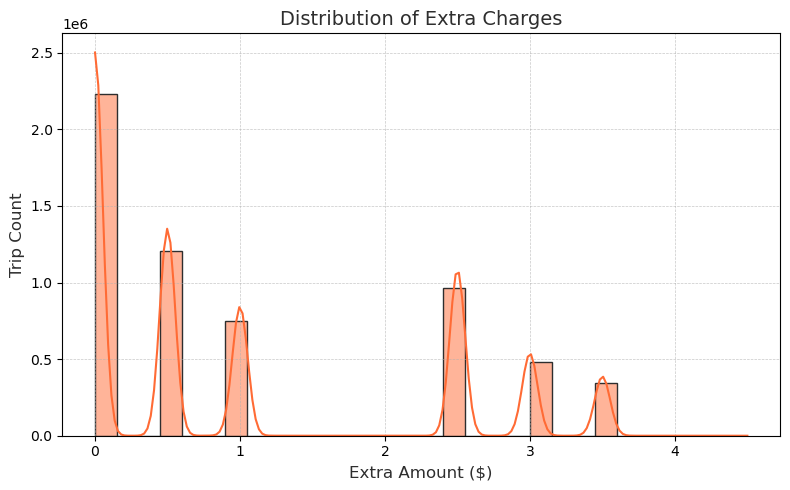

In [766]:
plt.figure(figsize=(8, 5))
sns.histplot(df['extra'], bins=30, kde=True, color=theme_colors['highlight'], edgecolor=theme_colors['contrast'])
plt.title("Distribution of Extra Charges", fontsize=14, color=theme_colors['contrast'])
plt.xlabel("Extra Amount ($)", fontsize=12, color=theme_colors['contrast'])
plt.ylabel("Trip Count", fontsize=12, color=theme_colors['contrast'])
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


Extra charges appear in specific fixed amounts like $\$0$, $\$0.5$, $\$1.0$, $\$2.5$, $\$3.0$, $\$3.5$, forming a multimodal distribution. This strongly suggests the values stem from rule-based extra amounts (e.g., night or rush hour fees), not from continuous pricing. A regression model isn't necessary here.

In [774]:
# Calculating counts and percentages
extra_counts = df['extra'].value_counts().sort_index()
print(extra_counts)

extra
0.00    2230686
0.02          1
0.30         10
0.50    1206226
0.52          1
0.80        515
1.00     751801
1.02          1
1.30        235
1.75          1
1.80        164
2.15          1
2.50     965721
2.95          1
3.00     478499
3.50     345005
4.50          5
Name: count, dtype: int64


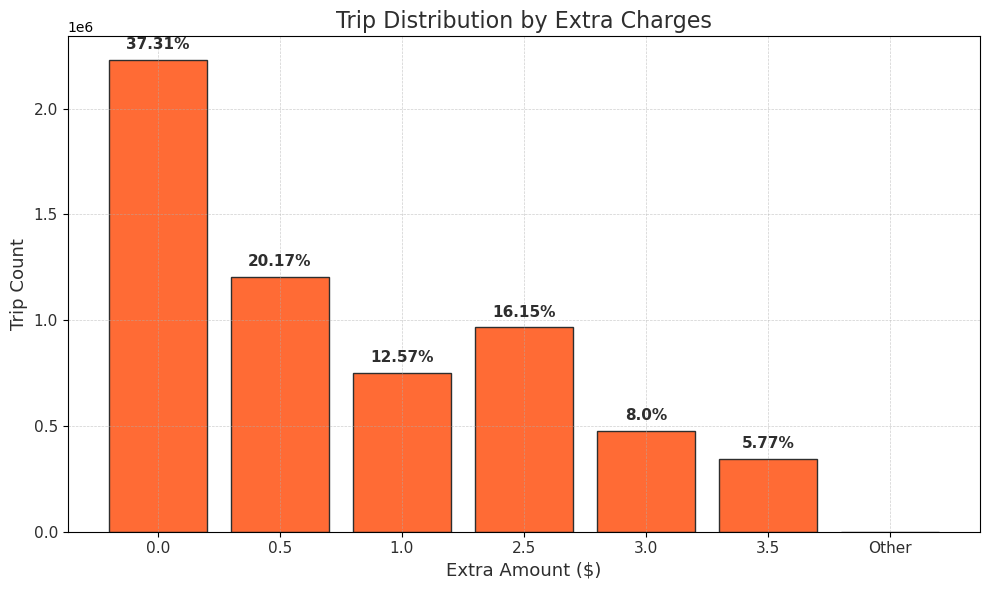

In [778]:
counts = df['extra'].round(2).value_counts().sort_index()

main_values = [0.00, 0.50, 1.00, 2.50, 3.00, 3.50]
grouped = counts[counts.index.isin(main_values)]
grouped.loc['Other'] = counts[~counts.index.isin(main_values)].sum()

# Percentages
total = grouped.sum()
percentages = (grouped / total * 100).round(2)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(grouped.index.astype(str), grouped.values, color=theme_colors['highlight'], edgecolor=theme_colors['contrast'])

# Label 
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    if pct >= 1:
        plt.text(bar.get_x() + bar.get_width()/2, height + 50000, f'{pct}%', 
                 ha='center', fontsize=11, color=theme_colors['contrast'], fontweight='bold')


plt.title("Trip Distribution by Extra Charges", fontsize=16, color=theme_colors['contrast'])
plt.xlabel("Extra Amount ($)", fontsize=13, color=theme_colors['contrast'])
plt.ylabel("Trip Count", fontsize=13, color=theme_colors['contrast'])
plt.xticks(fontsize=11, color=theme_colors['contrast'])
plt.yticks(fontsize=11, color=theme_colors['contrast'])
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()


About ~$37%$ of rides have no extra charge, and the rest follow a clear pattern of fixed values. 

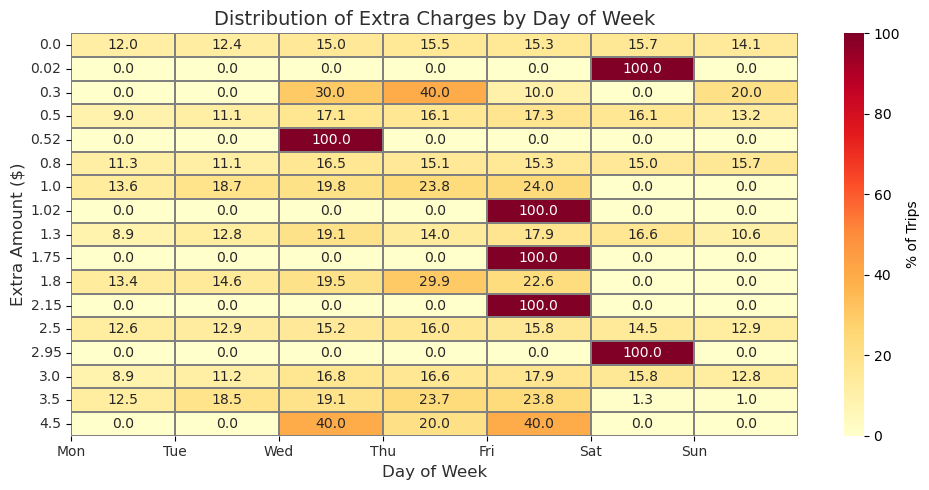

In [804]:
plt.figure(figsize=(10, 5))
heat_df = df.copy()
heat_df['extra'] = heat_df['extra'].round(2)

# Pivot table of counts
pivot = pd.pivot_table(
    heat_df,
    values='fare_amount',
    index='extra',
    columns='pickup_dayofweek',
    aggfunc='count',
    fill_value=0
)

# Normalize per row
pivot_percent = (pivot.T / pivot.sum(axis=1)).T * 100

# Plot heatmap
sns.heatmap(pivot_percent,cmap='YlOrRd',annot=True,fmt='.1f',cbar_kws={'label': '% of Trips'},linewidths=0.3,linecolor='gray')

plt.title('Distribution of Extra Charges by Day of Week', fontsize=14, color=theme_colors['contrast'])
plt.xlabel("Day of Week", fontsize=12, color=theme_colors['contrast'])
plt.ylabel("Extra Amount ($)", fontsize=12, color=theme_colors['contrast'])

# Custom x-tick labels (0=Mon, 6=Sun)
plt.xticks(
    ticks=range(7),
    labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
    color=theme_colors['contrast'], 
    ha='center'
)
plt.yticks(color=theme_colors['contrast'])

plt.tight_layout()
plt.show()


Extra charges are stable across days.

<Figure size 1600x600 with 0 Axes>

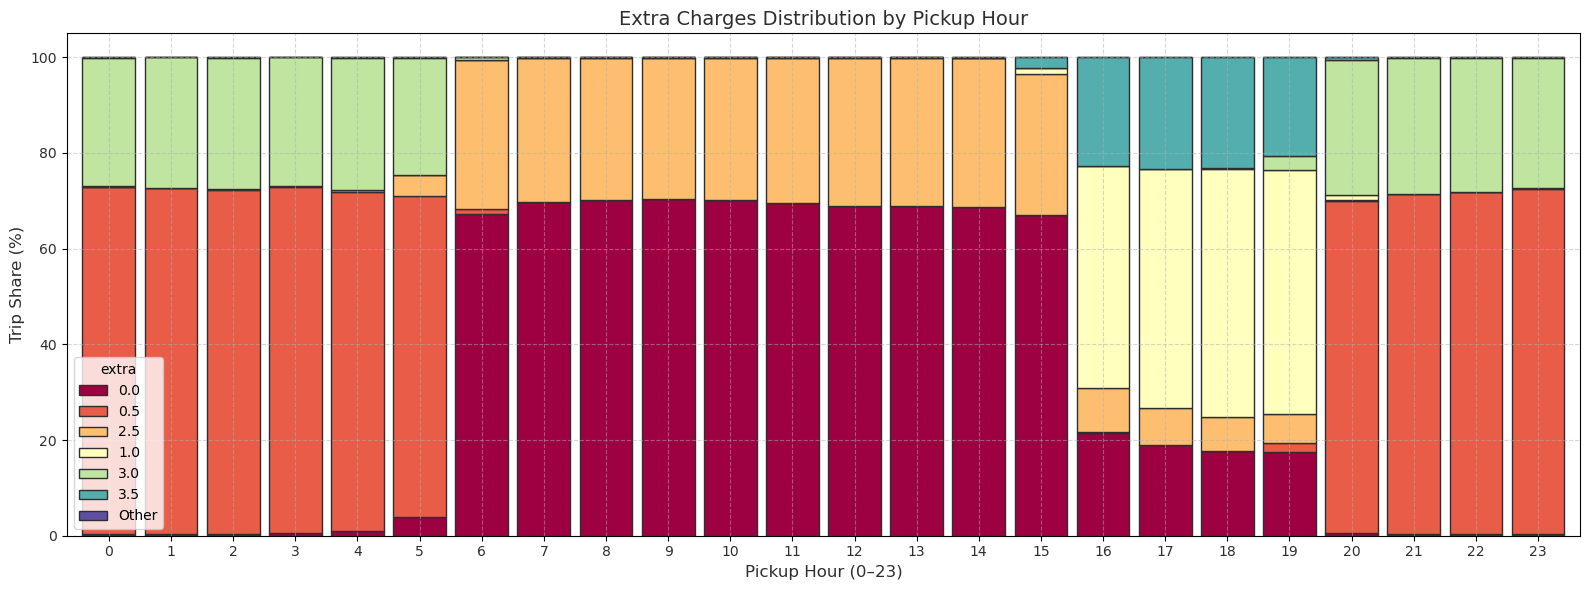

In [796]:
plt.figure(figsize=(16, 6))  # wider figure
hourly_extra = df.copy()
hourly_extra['extra'] = hourly_extra['extra'].round(2)

# Group and count
hourly_counts = hourly_extra.groupby(['pickup_hour', 'extra']).size().unstack(fill_value=0)

# Get top 6 most frequent extras
top_extras = hourly_counts.sum().sort_values(ascending=False).head(6).index.tolist()

# Group the rest as 'Other'
hourly_counts['Other'] = hourly_counts.drop(columns=top_extras, errors='ignore').sum(axis=1)
plot_df = hourly_counts[top_extras + ['Other']]

# Normalize
plot_df_pct = (plot_df.T / plot_df.sum(axis=1)).T * 100

# Plot
plot_df_pct.plot(
    kind='bar', 
    stacked=True, 
    colormap='Spectral', 
    edgecolor=theme_colors['contrast'], 
    figsize=(16, 6),        # increased width
    width=0.85              # slightly wider bars
)

plt.title("Extra Charges Distribution by Pickup Hour", fontsize=14, color=theme_colors['contrast'])
plt.xlabel("Pickup Hour (0–23)", fontsize=12, color=theme_colors['contrast'])
plt.ylabel("Trip Share (%)", fontsize=12, color=theme_colors['contrast'])
plt.xticks(rotation=0, color=theme_colors['contrast'])
plt.yticks(color=theme_colors['contrast'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Extra charges show clear hourly trends - $\$0.5$ and $\$1.0$, are common during early morning and late evening, while $\$2.5$ to $\$3.5$ spike around midnight and peak hours. <br>
There's a strong link between pickup_hour and extra, allowing us to use rule-based logic instead of modeling - making the prediction more accurate and interpretable.

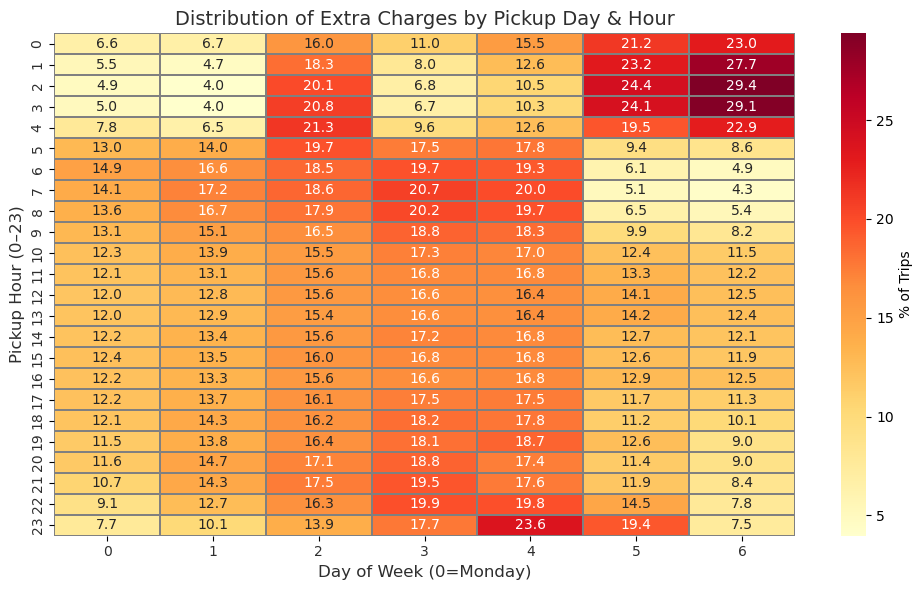

In [851]:
df_heat = df.copy()
df_heat['extra'] = df_heat['extra'].round(2)

# Pivot table: trip counts for each (day, hour, extra)
pivot = df_heat.groupby(['pickup_dayofweek', 'pickup_hour', 'extra']).size().reset_index(name='count')

# Filter to most frequent extras for clarity
top_extras = pivot.groupby('extra')['count'].sum().sort_values(ascending=False).head(6).index.tolist()
pivot = pivot[pivot['extra'].isin(top_extras)]

# Pivot again to form a 2D grid: pickup_dayofweek x pickup_hour
pivot_grid = pivot.pivot_table(index='pickup_hour', columns='pickup_dayofweek', values='count', aggfunc='sum', fill_value=0)

# Normalize by row to show % distribution across days for each hour
pivot_percent = (pivot_grid.T / pivot_grid.T.sum()).T * 100

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_percent, cmap='YlOrRd', annot=True, fmt=".1f",
            cbar_kws={'label': '% of Trips'},
            linewidths=0.3, linecolor='gray')

plt.title("Distribution of Extra Charges by Pickup Day & Hour", fontsize=14, color=theme_colors['contrast'])
plt.xlabel("Day of Week (0=Monday)", fontsize=12, color=theme_colors['contrast'])
plt.ylabel("Pickup Hour (0–23)", fontsize=12, color=theme_colors['contrast'])
plt.xticks(color=theme_colors['contrast'])
plt.yticks(color=theme_colors['contrast'])
plt.tight_layout()
plt.show()


The heatmap reveals clear temporal trends in extra charges, with early mornings on Friday and weekends (2-6 AM) showing the highest charge frequency, especially Sundays at 3AM (~29%).<br>
Weekday peak hours (7-9AM, 5-7PM) also show moderate surcharge usage, likely traffic-related, while midday and late-night hours are more balanced.

<Figure size 1000x500 with 0 Axes>

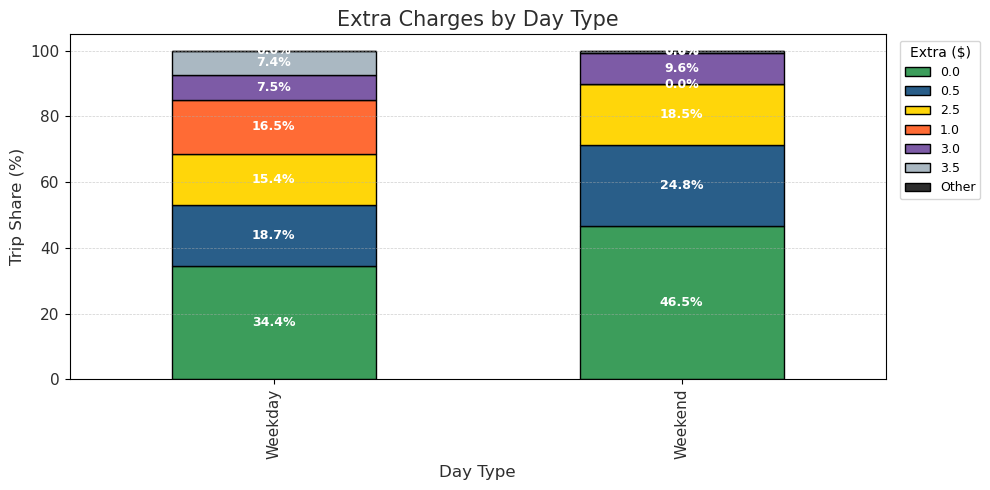

In [856]:
plt.figure(figsize=(10, 5))

df['is_weekend'] = df['pickup_dayofweek'].isin([5, 6]).map({False: 'Weekday', True: 'Weekend'})

# Group and prepare
weekend_counts = df.groupby(['is_weekend', 'extra']).size().unstack(fill_value=0)
top_extras = weekend_counts.sum().sort_values(ascending=False).head(6).index.tolist()
weekend_counts['Other'] = weekend_counts.drop(columns=top_extras, errors='ignore').sum(axis=1)
plot_df = weekend_counts[top_extras + ['Other']]

# Normalize to %
plot_df_pct = (plot_df.T / plot_df.sum(axis=1)).T * 100

# Custom color palette 
stack_colors = [
    '#3C9D5B',  # calm
    '#295E89',  # accent
    '#FFD60A',  # primary
    '#FF6B35',  # highlight
    '#7D5BA6',  # contrast2
    '#AAB8C2',  # neutral gray tone
    '#2E2E2E'   # contrast for 'Other'
]

# Plot
ax = plot_df_pct.plot(
    kind='bar',
    stacked=True,
    color=stack_colors,
    edgecolor='black',
    figsize=(10, 5)
)

# Annotate percentage inside bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=9, color='white', fontweight='bold')

# Styling
plt.title("Extra Charges by Day Type", fontsize=15, color=theme_colors['contrast'])
plt.xlabel("Day Type", fontsize=12, color=theme_colors['contrast'])
plt.ylabel("Trip Share (%)", fontsize=12, color=theme_colors['contrast'])

plt.xticks(fontsize=11, color=theme_colors['contrast'])
plt.yticks(fontsize=11, color=theme_colors['contrast'])

plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.6)
plt.legend(title='Extra ($)', title_fontsize=10, fontsize=9, bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()


Weekend extras are simpler and fewer, likey due to reduced peak-hour traffic and steadier demand patterns. Weekdays show more extra amount variation, driven by dynamic conditions like rush hours and higher demand during commute times.

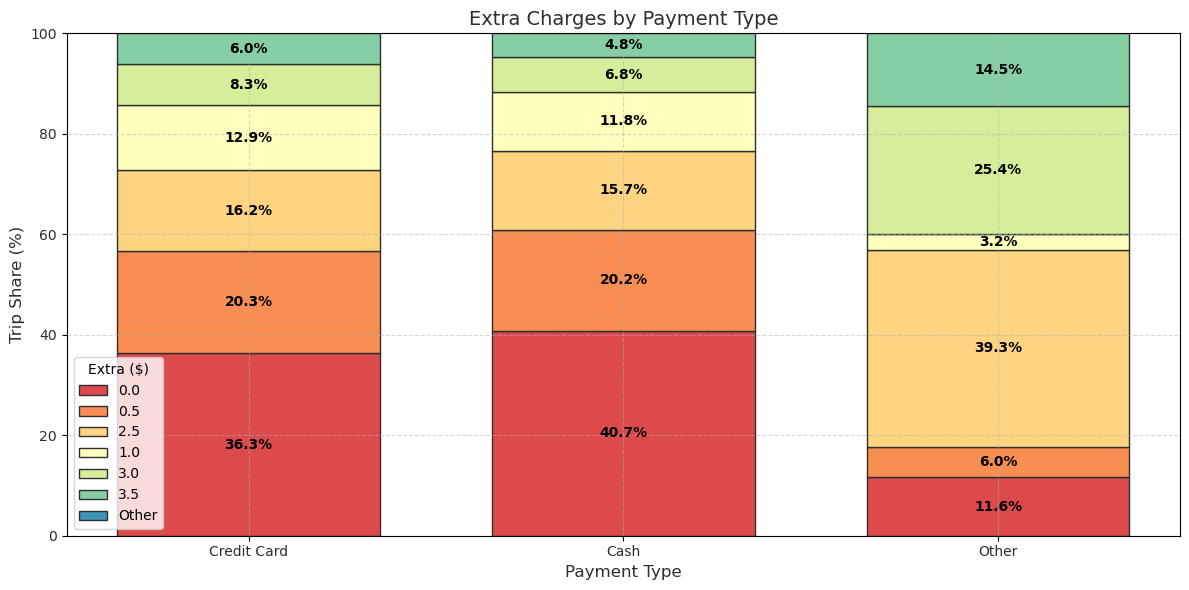

In [859]:
# Filter and prepare
df_payment = df.copy()
df_payment['extra'] = df_payment['extra'].round(2)

# Group and count
payment_counts = df_payment.groupby(['payment_type', 'extra']).size().unstack(fill_value=0)

keep_types = ['1.0', '2.0']  # '1.0': Credit Card, '2.0': Cash
filtered_counts = payment_counts.loc[keep_types]
filtered_counts.index = filtered_counts.index.map({'1.0': 'Credit Card', '2.0': 'Cash'})

other_types = payment_counts.index.difference(keep_types)
other_sum = payment_counts.loc[other_types].sum()
filtered_counts.loc['Other'] = other_sum

# Getting top extras and bucket the rest
top_extras = filtered_counts.sum().sort_values(ascending=False).head(6).index.tolist()
filtered_counts = filtered_counts[top_extras].copy()
filtered_counts['Other'] = payment_counts.drop(columns=top_extras, errors='ignore').sum()

# Normalize
pct_df = (filtered_counts.T / filtered_counts.T.sum()).T * 100

# Plot with theme
plt.figure(figsize=(12, 6))
bottoms = np.zeros(len(pct_df))

for extra in pct_df.columns:
    bars = plt.bar(pct_df.index, pct_df[extra], bottom=bottoms, label=str(extra), width=0.7,
                   color=sns.color_palette("Spectral", n_colors=len(pct_df.columns))[list(pct_df.columns).index(extra)],
                   edgecolor=theme_colors['contrast'])
    
    # Add % labels
    for i, val in enumerate(pct_df[extra]):
        if val > 3:  # show label only if visually significant
            plt.text(i, bottoms[i] + val/2, f'{val:.1f}%', ha='center', va='center',
                     fontsize=10, color='black', fontweight='bold')
    
    bottoms += pct_df[extra]

plt.title("Extra Charges by Payment Type", fontsize=14, color=theme_colors['contrast'])
plt.xlabel("Payment Type", fontsize=12, color=theme_colors['contrast'])
plt.ylabel("Trip Share (%)", fontsize=12, color=theme_colors['contrast'])
plt.xticks(color=theme_colors['contrast'])
plt.yticks(color=theme_colors['contrast'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Extra ($)')
plt.tight_layout()
plt.show()


Based on the plot, payment_type does not significantly help in deciding the extra amount for majority of rides.

<Figure size 1000x600 with 0 Axes>

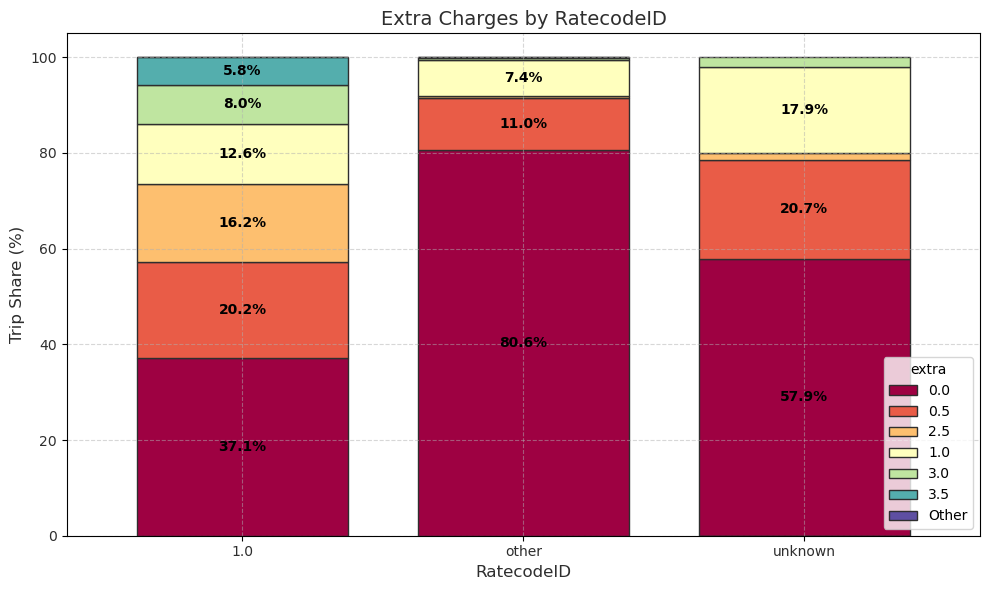

In [863]:
plt.figure(figsize=(10, 6))
df_copy = df.copy()
df_copy['extra'] = df_copy['extra'].round(2)
rate_counts = df_copy.groupby(['RatecodeID', 'extra']).size().unstack(fill_value=0)

# Top extras
top_extras = rate_counts.sum().sort_values(ascending=False).head(6).index.tolist()
rate_counts['Other'] = rate_counts.drop(columns=top_extras, errors='ignore').sum(axis=1)
rate_counts = rate_counts[top_extras + ['Other']]

# Normalize
rate_pct = (rate_counts.T / rate_counts.sum(axis=1)).T * 100

# Plot
ax = rate_pct.plot(kind='bar', stacked=True, colormap='Spectral',
                   edgecolor=theme_colors['contrast'], figsize=(10, 6), width=0.75)

for idx, bar in enumerate(ax.patches):
    height = bar.get_height()
    if height > 3:
        ax.text(
            bar.get_x() + bar.get_width()/2, bar.get_y() + height/2,
            f"{height:.1f}%", ha='center', va='center', fontsize=10, color='black', fontweight='bold'
        )

plt.title("Extra Charges by RatecodeID", fontsize=14, color=theme_colors['contrast'])
plt.xlabel("RatecodeID", fontsize=12, color=theme_colors['contrast'])
plt.ylabel("Trip Share (%)", fontsize=12, color=theme_colors['contrast'])
plt.xticks(rotation=0, color=theme_colors['contrast'])
plt.yticks(color=theme_colors['contrast'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


RatecodeID = 1.0 serves as a meaningful signal for predicting extra charges, as it often aligns with structured, rule-based surcharges like night or peak-hour fees.

After a detailed analysis of extra amount, we discovered that extra charges are not applied randomly but follow predictable, rule-based patterns. These patterns are primarily driven by pickup time, including both the hour of day and day of the week. So I have designed a logic for deciding the extra amount:
<br>
- $0.50 is added for night rides (8 PM to 6 AM) or early mornings (6 AM to 8 AM).

- $1.00 applies during weekday peak hours (Monday to Friday, 4 PM to 8 PM).

- $2.50 is charged on weekend evenings (Saturday and Sunday, 6 PM to 9 PM).

- $3.00 is added for late-night rides on Friday and Saturday (10 PM to Midnight).

- If none of these conditions match, there's no extra charge ($0.00).

Now I choose the rule-based logic because of its interpretability, Efficiency and Accuracy.

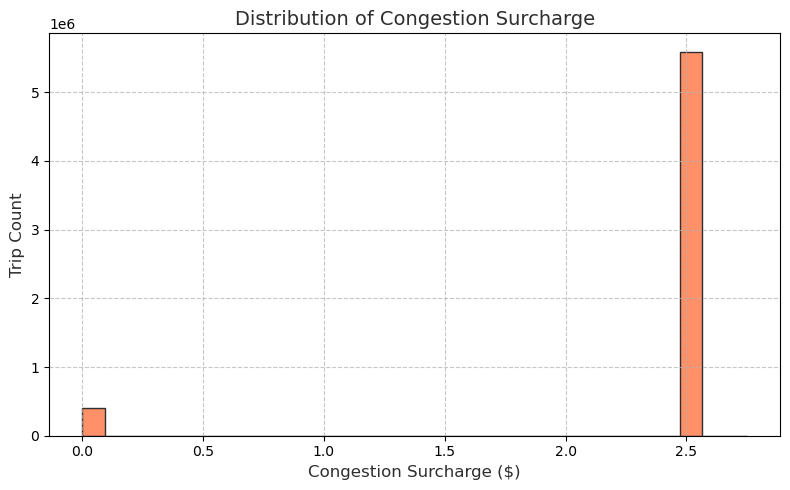

In [870]:
plt.figure(figsize=(8, 5))
sns.histplot(df['congestion_surcharge'], bins=30, kde=False, color=theme_colors['highlight'], edgecolor=theme_colors['contrast'])
plt.title("Distribution of Congestion Surcharge", fontsize=14, color=theme_colors['contrast'])
plt.xlabel("Congestion Surcharge ($)", fontsize=12, color=theme_colors['contrast'])
plt.ylabel("Trip Count", fontsize=12, color=theme_colors['contrast'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [872]:
df['congestion_surcharge'].value_counts().sort_index()

congestion_surcharge
0.00     400412
0.50          4
0.75         68
2.50    5578313
2.75         76
Name: count, dtype: int64

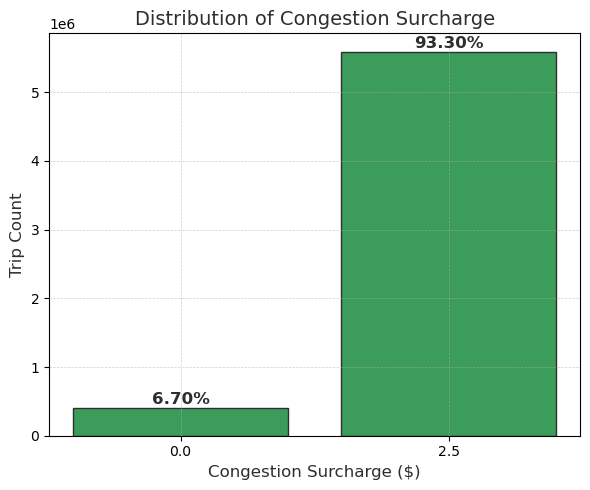

In [880]:
# Counting congestion surcharge values
surcharge_counts = df['congestion_surcharge'].value_counts().sort_index()
surcharge_main = surcharge_counts.loc[[0.00, 2.50]]
surcharge_pct = surcharge_main / surcharge_main.sum() * 100

# Plot
plt.figure(figsize=(6, 5))
bars = plt.bar(surcharge_main.index.astype(str), surcharge_main.values,
               color=theme_colors['calm'], edgecolor=theme_colors['contrast'])

# Annotate percentages on top of bars
for bar, pct in zip(bars, surcharge_pct):
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 20000,
             f"{pct:.2f}%",
             ha='center',
             va='bottom',
             fontsize=12,
             color=theme_colors['contrast'],
             fontweight='bold')

# Labels and styling
plt.title("Distribution of Congestion Surcharge", fontsize=14, color=theme_colors['contrast'])
plt.xlabel("Congestion Surcharge ($)", fontsize=12, color=theme_colors['contrast'])
plt.ylabel("Trip Count", fontsize=12, color=theme_colors['contrast'])
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()

Based on the data, a $\$2.50$ congestion surcharge dominates, appearing in the vast majority of trips (~5.57 million), while other values are rare and likely noise or outdated entries. This consistency strongly supports treating it as flat, rule-based fee of $\$2.50$ for all predictions to ensure simplicity and alignment with observed patterns.

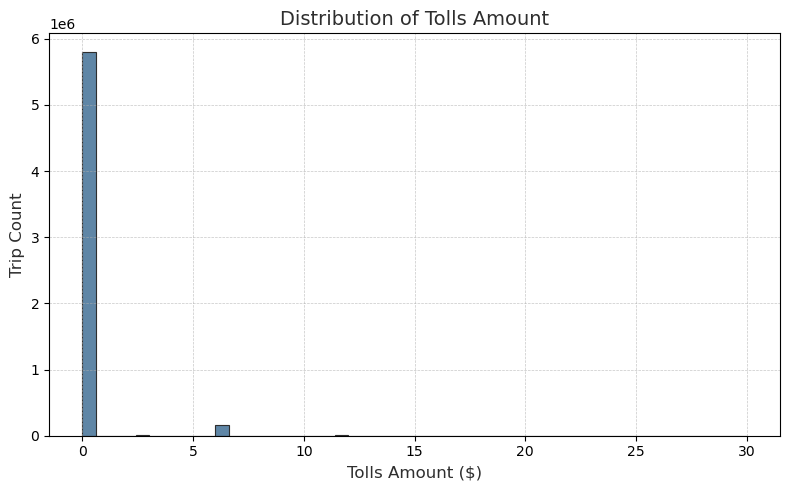

In [883]:
plt.figure(figsize=(8, 5))
sns.histplot(df['tolls_amount'], bins=50, kde=False,
             color=theme_colors['accent'], edgecolor=theme_colors['contrast'])

plt.title("Distribution of Tolls Amount", fontsize=14, color=theme_colors['contrast'])
plt.xlabel("Tolls Amount ($)", fontsize=12, color=theme_colors['contrast'])
plt.ylabel("Trip Count", fontsize=12, color=theme_colors['contrast'])
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


In [885]:
df['tolls_amount'].value_counts().sort_index()

tolls_amount
0.00     5792314
0.01          33
0.02           2
0.05           1
0.06           1
          ...   
29.87          2
29.90          3
29.94          1
29.99          9
30.00          9
Name: count, Length: 701, dtype: int64

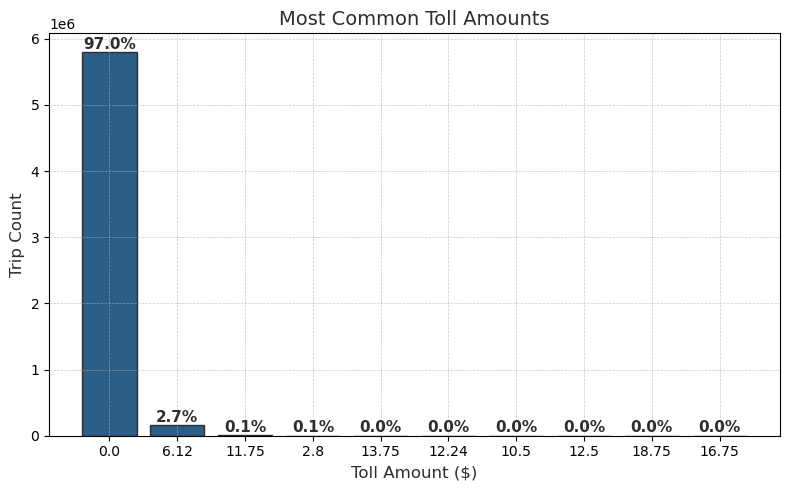

In [891]:
top_tolls = df['tolls_amount'].value_counts().sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
bars = plt.bar(top_tolls.index.astype(str), top_tolls.values,
               color=theme_colors['accent'], edgecolor=theme_colors['contrast'])

total_tolls = top_tolls.sum()
for bar, value in zip(bars, top_tolls.values):
    pct = (value / total_tolls) * 100
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 5000,
             f"{pct:.1f}%",
             ha='center',
             va='bottom',
             fontsize=11,
             color=theme_colors['contrast'],
            fontweight = 'bold')

plt.title("Most Common Toll Amounts", fontsize=14, color=theme_colors['contrast'])
plt.xlabel("Toll Amount ($)", fontsize=12, color=theme_colors['contrast'])
plt.ylabel("Trip Count", fontsize=12, color=theme_colors['contrast'])
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


Exploratory analysis revealed that approximately 97% of trips have a toll amount of $\$0$. The remaining values are scattered across various uncommon amounts (e.g., $\$6.12$, $\$11.75$), typically influenced by specific route-based tolls such as bridges and tunnels. Since such route-level information is not available in our dataset, we treat tolls_amount as a sparse feature.

We apply a rule-based logic where tolls_amount is set to $\$0.0$ for the vast majority of trips. Advanced modeling or prediction is deferred unless more granular routing data becomes available in future iterations.


For MTA Tax it should be treated as a fixed, rule-based charge of $\$0.50$, as it is a standard regulatory fee applied uniformly across nearly all yellow taxi rides in NYC. It does not depend on pickup time, trip distance, location, or payment type, making a constant value the most accurate and efficient choice.

The Improvement Surcharge should be modeled as a constant $\$0.30$ flat fee, since it is a regulatory charge applied uniformly across eligible NYC yellow taxi trips. It does not vary by time, distance, or location, making rule-based logic both appropriate and accurate for fare prediction.

## Logic for Total Amount Prediction

- **Hybrid Approach:** Combines machine learning (Random Forest) with rule-based logic for accurate interpretable predictions.
- **Fare Prediction:** fare_amount is predicted using a Random Forest model. For JFK trips, a fixed flat fare rule is applied.
- **Extra Charges:** Estimate using rule-based logic based on pickup hour, weekday/weekend patterns, and night/peak hours.
- **Congestion Surcharge:** Set to $\$2.50$ as a flat rate.
- **Tolls Amount:** Defaluted to $\$0$ as we don't have route data to add tolls amount on particular route.
- **MTA Tax:** Fixed at $\$0.50$ for all trips.
- **Improvement Surcharge:** Fixed at $\$0.30$ for all trips.

**Final Total Amount Formula**<br>

total_amount = predicted_fare + estimated_extra + congestion_surcharge + tolls_amount + mta_tax + improvement_surcharge

<br>
This setup balances predictive accuracy, operational simlicity, and transparency.

In [938]:
from fare_predictor_ import predict_total_amount

In [942]:
# Sample the data
df_sampled = df.sample(n=500_000, random_state=42).copy()

# Ensure 'is_weekend' is numeric (in case used 'Weekday'/'Weekend' earlier for plots)
if df_sampled['is_weekend'].dtype == 'object':
    df_sampled['is_weekend'] = df_sampled['is_weekend'].map({'Weekday': 0, 'Weekend': 1})

# Run total amount prediction using hybrid logic
df_sampled['predicted_total'] = predict_total_amount(df_sampled)

# Evaluate performance
mae_total = mean_absolute_error(df_sampled['total_amount'], df_sampled['predicted_total'])
r2_total = r2_score(df_sampled['total_amount'], df_sampled['predicted_total'])

# Print Results
print(" Total Amount Prediction on 500,000 Sampled Rides:")
print(f"MAE: ${mae_total:.2f}")
print(f"R² Score: {r2_total:.4f}")

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.5s finished


 Total Amount Prediction on 500,000 Sampled Rides:
MAE: $2.36
R² Score: 0.8736


Tested on 500,000 random trips, the model achieved a MAE of $\$2.36$ and an $R^2$ of 0.8736, reflecting decent accuracy and a good fit.

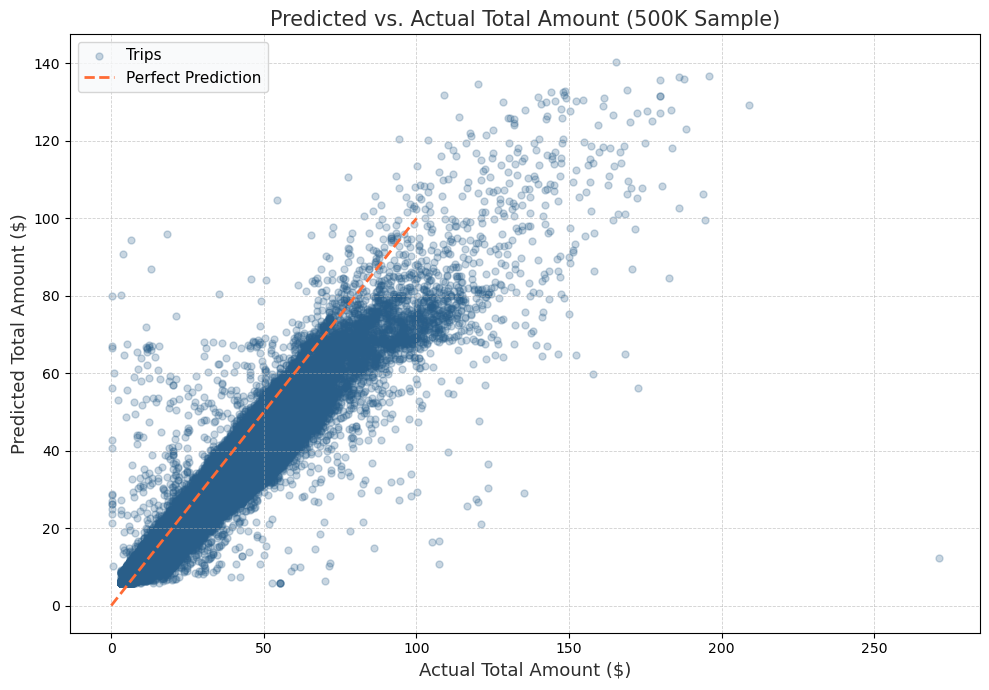

In [958]:
plt.figure(figsize=(10, 7))

# Scatter: Actual vs Predicted
plt.scatter(df_sampled['total_amount'], df_sampled['predicted_total'], alpha=0.25, s=25, color=theme_colors['accent'], label='Trips')

# Idea Prediction line
plt.plot([0, 100], [0, 100], color=theme_colors['highlight'], linestyle='--', linewidth=2, label='Perfect Prediction'
)

plt.xlabel("Actual Total Amount ($)", fontsize=13, color=theme_colors['contrast'])
plt.ylabel("Predicted Total Amount ($)", fontsize=13, color=theme_colors['contrast'])
plt.title("Predicted vs. Actual Total Amount (500K Sample)", fontsize=15, color=theme_colors['contrast'])
plt.legend(loc='upper left', fontsize=11, frameon=True, facecolor=theme_colors['neutral'])

plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.6)
plt.tight_layout()
plt.show()


The scatter plot of predicted vs. actual total amounts shows strong alignment, with most points lying close to the diagonal line- indicatng accurate predictions.

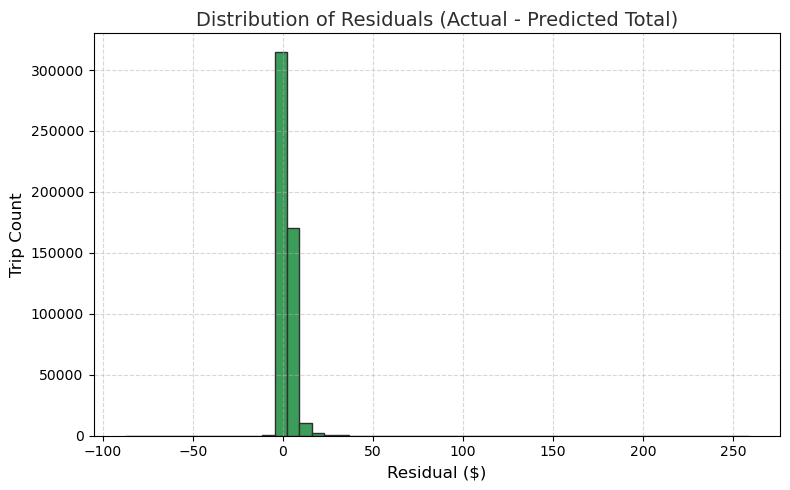

In [947]:
residuals = df_sampled['total_amount'] - df_sampled['predicted_total']
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=50, color=theme_colors['calm'], edgecolor=theme_colors['contrast'])
plt.title("Distribution of Residuals (Actual - Predicted Total)", fontsize=14, color=theme_colors['contrast'])
plt.xlabel("Residual ($)", fontsize=12)
plt.ylabel("Trip Count", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

The residuals are tightly centered around zero, indicating that most prediction errors are minimal. Although there's a sparse right tail due to a few underpredictions, the overall shape supports the reliability of the model.

## Summary

- Loaded and cleaned NYC Yellow Taxi trip data for 7M+ records
- Conducted Extensive exploratory data analysis (EDA) on:
    - Fare patterns by time (hour/day)
    - Distributions of all fare components (extra, congestion_surcharge, tolls_amount etc)
    - Correlations with categorical features (RatecodeID, payment_type)
- Build a hybrid fare prediction model:
    - Used a Random Forest Regressor for standard metered rides.
    - Applied a fixed flat fare of $\$52$ for JFK trips (RatecodeID = 2.0)
- Designed rule-based logic for additional charges based on temporal pattersn:
    - extra: varies with pickup time/day using well defined rules
    - congestion: fixed at $\$2.50$ based on majority distributions
    - tolls_amount: assumed $\$0.00$ for simplicity
    - mta_tax: $\$0.50$, improvement: $\$0.30$ fixed value
- Combined all components into a unified predict_total_amount() pipeline.


## Business Value

- Enables accurate fare estimation before ride start, improving user transparency and trust.
- Can be used by fleet managers for anomaly detection, route pricing, and revenue optimization.
- The hybrid rule-ML approach ensures interpretability and regulatory alignment (e.g, fixed JFK fares)
- Scalable pipeline can be adapted to newer months or expanded with GPS, weather, or traffic data.

## Few Limitations

- **Tolls Modeling :** Currently assumed to be $\$0.00$ due to sparsity and unpredictability. However, tolls can vary by bridge/tunnel crossings, and this simplification may slighly impact total accuracy.
- **Rule-Based Assumptions:** The extra and congestion_surcharge components rely on the time-based heuristics derived from 2020 patterns. These may evolve over time due to fare policy changes.
- **No Use of Geospatial Features:** Location IDs are treated as categorical variables. Geohash encoding or distance to airports/bridges could enhance model granularity.

## Future Enhancements

- **Tolls Amount Prediction Using Map-Based Logic :** Integrating route-based estimation using pickup/dropoff geolocation and known toll routes (may be usign google maps API)
- **Incorporate Real-Time features :** Using weather, traffic congestion, or event data for real-time fare prediction adjustments.
- **Model Monitoring & Drift Detection :** As fare rules change, incorporating drift detection to periodically retrain models or revising logic.